In [1]:
%matplotlib inline
import ast
import json
import matplotlib.pyplot as plt
import pycountry_convert as pc
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import patheffects
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter


In [2]:
df = pd.read_csv("../out/categorized.csv", index_col=0)

In [3]:
df.columns

Index(['ecMaxContribution', 'topics', 'cluster', 'euroscivoc_keywords',
       'cordis_keywords', 'categories', 'subcategories', 'subsubcategories'],
      dtype='object')

In [4]:
with open("../categorization/categories.json") as f:
    categories_d = json.load(f)

In [5]:
# colors
blue = "#4477AA"
pink = "#EE6677"
green = "#228833"
dirtyellow = "#CCBB44"
lightblue = "#66CCEE"
purple = "#AA3377"
grey = "#BBBBBB"
orange = "#EE7733"
green2 = "#009988"
yellow = "#DDAA33"
red = "#CC3311"
darkblue = "#004488"
colors = [blue, pink, green, dirtyellow, lightblue, purple, grey, orange, green2, yellow, red, darkblue]
activityType_colors = [blue, lightblue, pink, green, dirtyellow, purple]


# Organizations

In [6]:
org_df = pd.read_csv("../data/organization.csv")
extracted_df = pd.read_csv("../out/categorized.csv")
org_df = org_df.merge(right=extracted_df, how="left", left_on="projectID", right_on="id")


## ActivityType

In [7]:
netEcSum = sum(org_df["netEcContribution"].dropna())

### Overall

In [8]:
print(org_df.groupby("activityType")["netEcContribution"].sum())
print(org_df.groupby("activityType")["netEcContribution"].sum().div(netEcSum).mul(100))


activityType
HES    1.289856e+10
OTH    2.190128e+09
PRC    1.030183e+10
PUB    1.296007e+09
REC    1.010741e+10
Name: netEcContribution, dtype: float64
activityType
HES    35.034246
OTH     5.948687
PRC    27.981166
PUB     3.520132
REC    27.453114
Name: netEcContribution, dtype: float64


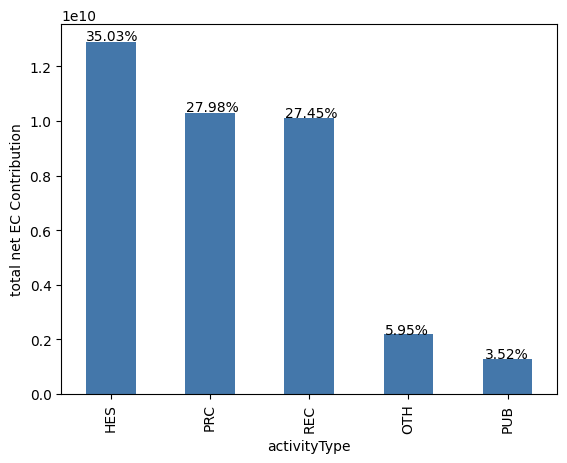

In [9]:
ax = org_df.groupby("activityType")["netEcContribution"].sum().sort_values(ascending=False).plot.bar(color=blue)
ax.set_ylabel("total net EC Contribution")
for p in ax.patches:
    ax.annotate(f"{p.get_height() / netEcSum * 100:.2f}%", (p.get_x() * 1.005, p.get_height()* 1.005))

### Per cluster

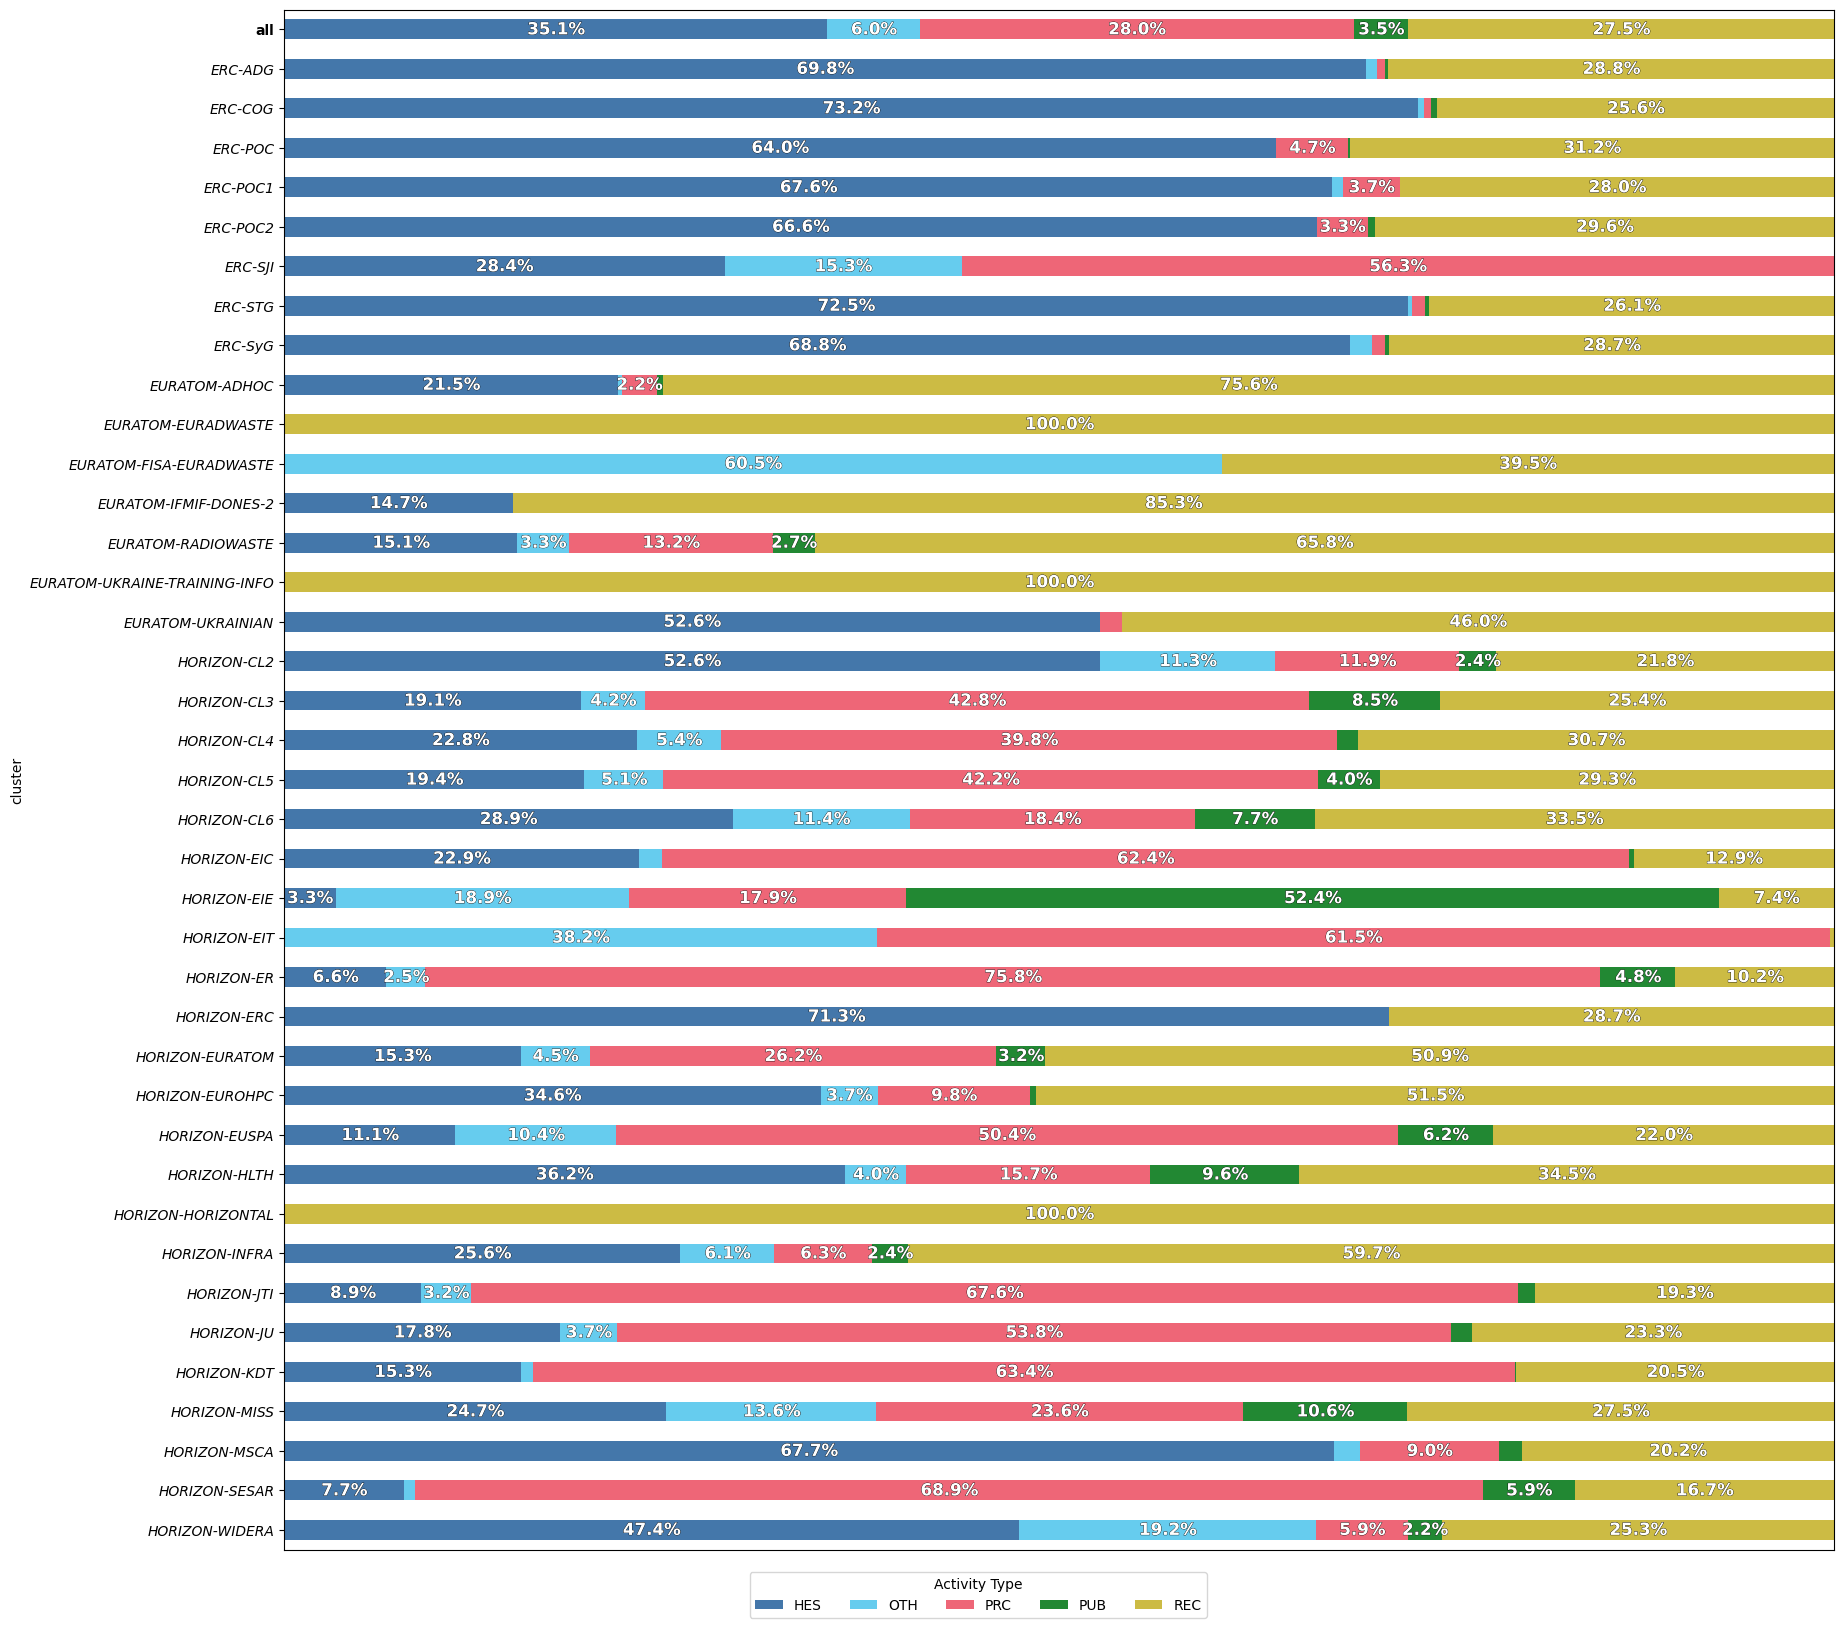

In [10]:
df_cluster_activityType_perc = org_df.groupby(["cluster","activityType"])["netEcContribution"].sum().unstack(fill_value=0)
df_cluster_activityType_perc.loc["all"] = df_cluster_activityType_perc.sum()
df_cluster_activityType_perc = df_cluster_activityType_perc.div(df_cluster_activityType_perc.sum(axis=1), axis=0).mul(100)
# Sort index
df_cluster_activityType_perc = df_cluster_activityType_perc.loc[sorted(df_cluster_activityType_perc.index, key=lambda x: x.casefold(), reverse=True)]

ax = df_cluster_activityType_perc.plot.barh(stacked=True, color=[blue, lightblue, pink, green, dirtyellow], figsize=(20,20))
ax.set_xmargin(0)
ax.set_xticks([])
ax.legend(title="Activity Type", ncol=5, bbox_to_anchor=(0.6, -0.01))


for label in ax.get_yticklabels():
    if label.get_text() == "all":
        label.set_fontweight("bold")
    else:
        label.set_style("italic")

for c in ax.containers:
    labels = [f'{w:0.1f}%' if (w := v.get_width()) > 2 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='white', fontsize=12, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])


### Per organization

/tmp/ipykernel_29970/2386690083.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22)


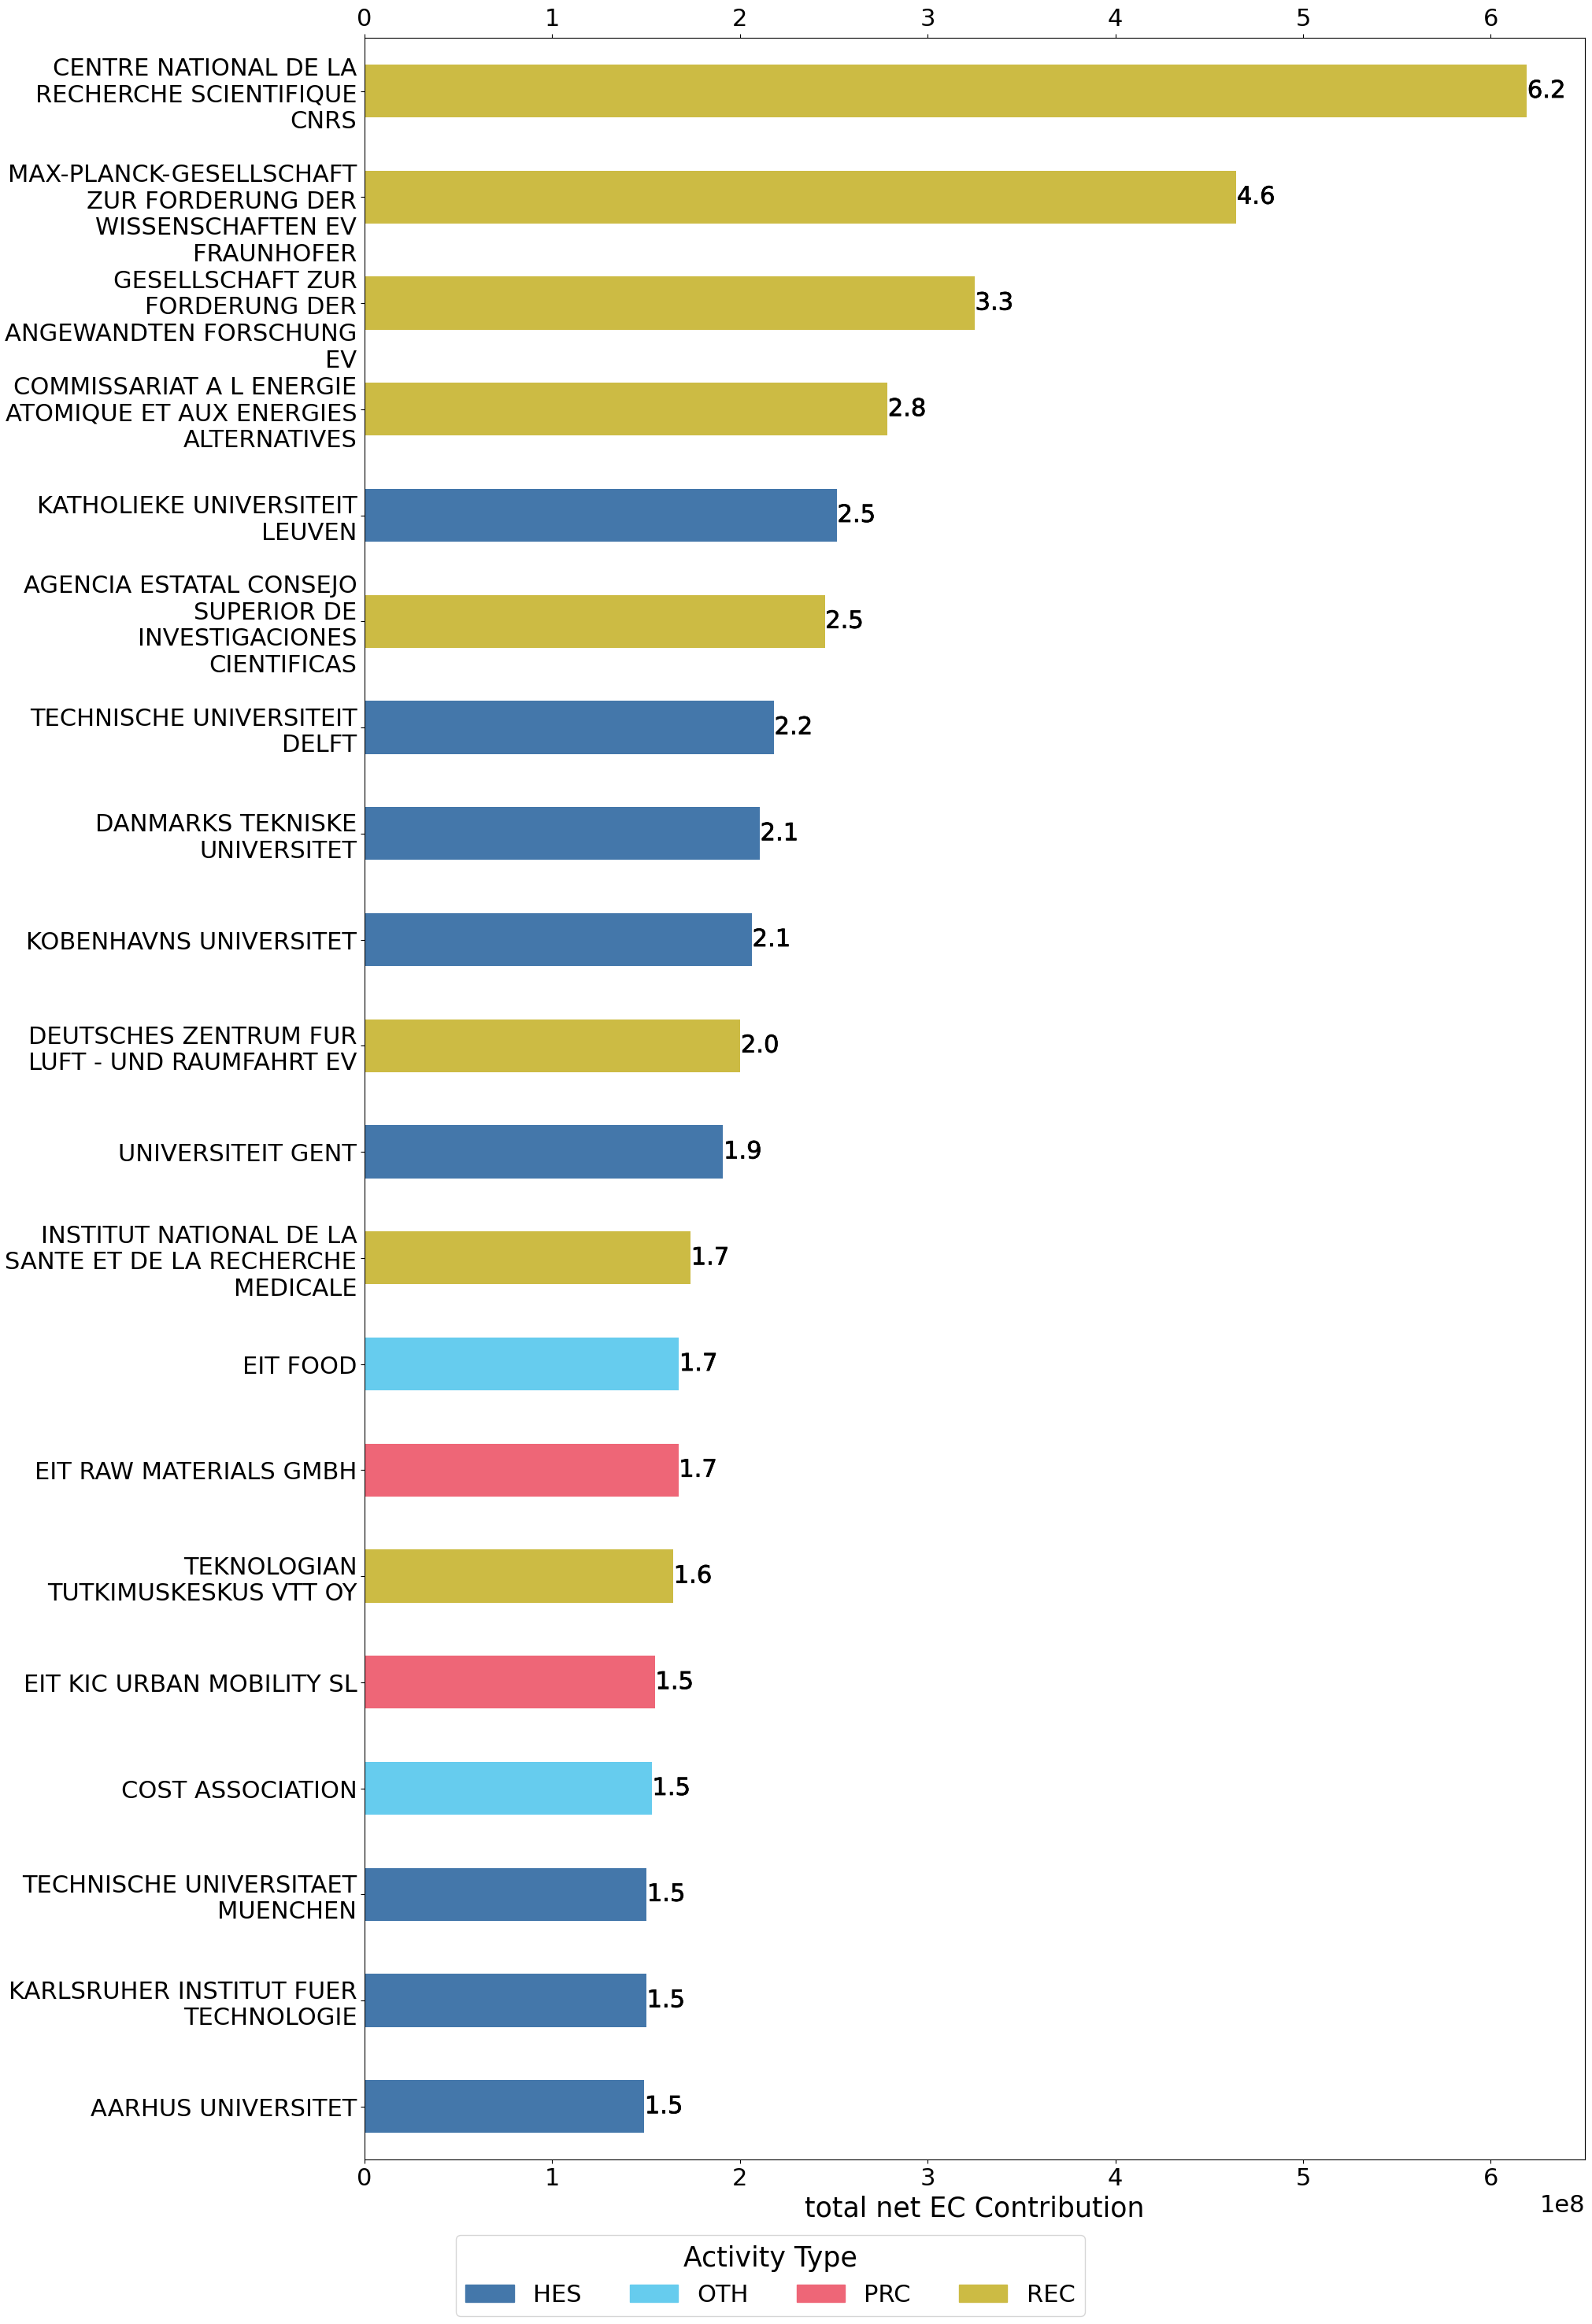

In [11]:
activityType_colors_dict = {
    "HES": blue,
    "OTH": lightblue,
    "PRC": pink,
    "PUB": green,
    "REC": dirtyellow
}
N = 20

org_df_grouped = org_df.groupby(["name", "activityType"])["netEcContribution"].sum().sort_values(ascending=False).head(N).sort_values()
bar_colors = org_df_grouped.index.get_level_values("activityType").map(activityType_colors_dict)

ax = org_df.groupby(["name"])["netEcContribution"].sum().sort_values(ascending=False).head(N).sort_values().plot.barh(color=bar_colors, figsize=(20, 35), fontsize=20)

ax.set_xlabel("total net EC Contribution", fontsize=25)
ax.set_ylabel("")

ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22)
ax.set_yticklabels(labels=ax.get_yticklabels(), wrap=True, fontsize=22)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

formatter = ScalarFormatter(useOffset=True, useMathText=False)
formatter.set_scientific(True)
ax.xaxis.set_major_formatter(formatter)
ax.ticklabel_format(style="scientific", axis="x", scilimits=(0,0))
ax.xaxis.get_offset_text().set_fontsize(22)

legend_patches = [Patch(color=color, label=label) for label, color in activityType_colors_dict.items() if label in org_df_grouped.index.get_level_values("activityType").unique()]
ax.legend(handles=legend_patches, title="Activity Type", ncols=5, fontsize=22, title_fontsize=25, bbox_to_anchor=(0.6, -0.03))

for c in ax.containers:
    labels = [f'{w/(10**8):0.1f}' if (w := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', padding=0.5, color='black', fontsize=22,
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])


## Location
### Overall

In [12]:
def get_country_name(iso):
    if pd.isna(iso):
        return None
    if iso == "EL":
        return "Greece"
    if iso == "VA":
        return "Vatican City"
    if iso == "UK":
        return "United Kingdom"
    if iso == "XK":
        return "Kosovo"

    return pc.country_alpha2_to_country_name(iso)
    

In [13]:
ax = org_df.groupby("country")["netEcContribution"].sum().sort_values(ascending=False).head(10).plot.bar(color=blue, figsize=(25,10), fontsize=22)

country_labels = [get_country_name(c.get_text()) for c in ax.get_xticklabels()]
ax.set_xticklabels(labels=country_labels, fontsize=22)
ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel("netEcContribution", fontsize=22)

formatter = ScalarFormatter(useOffset=True, useMathText=False)
formatter.set_scientific(True)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(22)

for p in ax.patches:
    ax.annotate(f"{p.get_height() / netEcSum * 100:.2f}%", (p.get_x() * 1.005, p.get_height()* 1.005), fontsize=22)


In [14]:
def get_continent(iso):
    if pd.isna(iso):
        return None
    if iso == "XK" or iso == "VA":
        return "Europe"

    country_name = get_country_name(iso)
    country_code = pc.country_name_to_country_alpha2(country_name)
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    return pc.convert_continent_code_to_continent_name(continent_code)


org_df["continent"] = org_df.apply(lambda row: get_continent(row.country), axis=1)


In [15]:
ax = org_df.groupby("continent")["netEcContribution"].sum().sort_values(ascending=False).head(10).plot.bar(color=blue, figsize=(25,10), fontsize=22)

ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22)
ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel("netEcContribution", fontsize=22)

formatter = ScalarFormatter(useOffset=True, useMathText=False)
formatter.set_scientific(True)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(22)

for p in ax.patches:
    ax.annotate(f"{p.get_height() / netEcSum * 100:.2f}%", (p.get_x() * 1.005, p.get_height()* 1.005), fontsize=22)


In [16]:
EU_countries = "Austria, Belgium, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden".split(", ")

def get_in_eu(iso):
    if pd.isna(iso):
        return None
    
    return get_country_name(iso) in EU_countries

org_df["in_EU"] = org_df.apply(lambda row: get_in_eu(row.country), axis=1)


In [17]:
org_df.groupby("in_EU")["netEcContribution"].sum().div(netEcSum).mul(100)

in_EU
False     8.162137
True     91.834549
Name: netEcContribution, dtype: float64

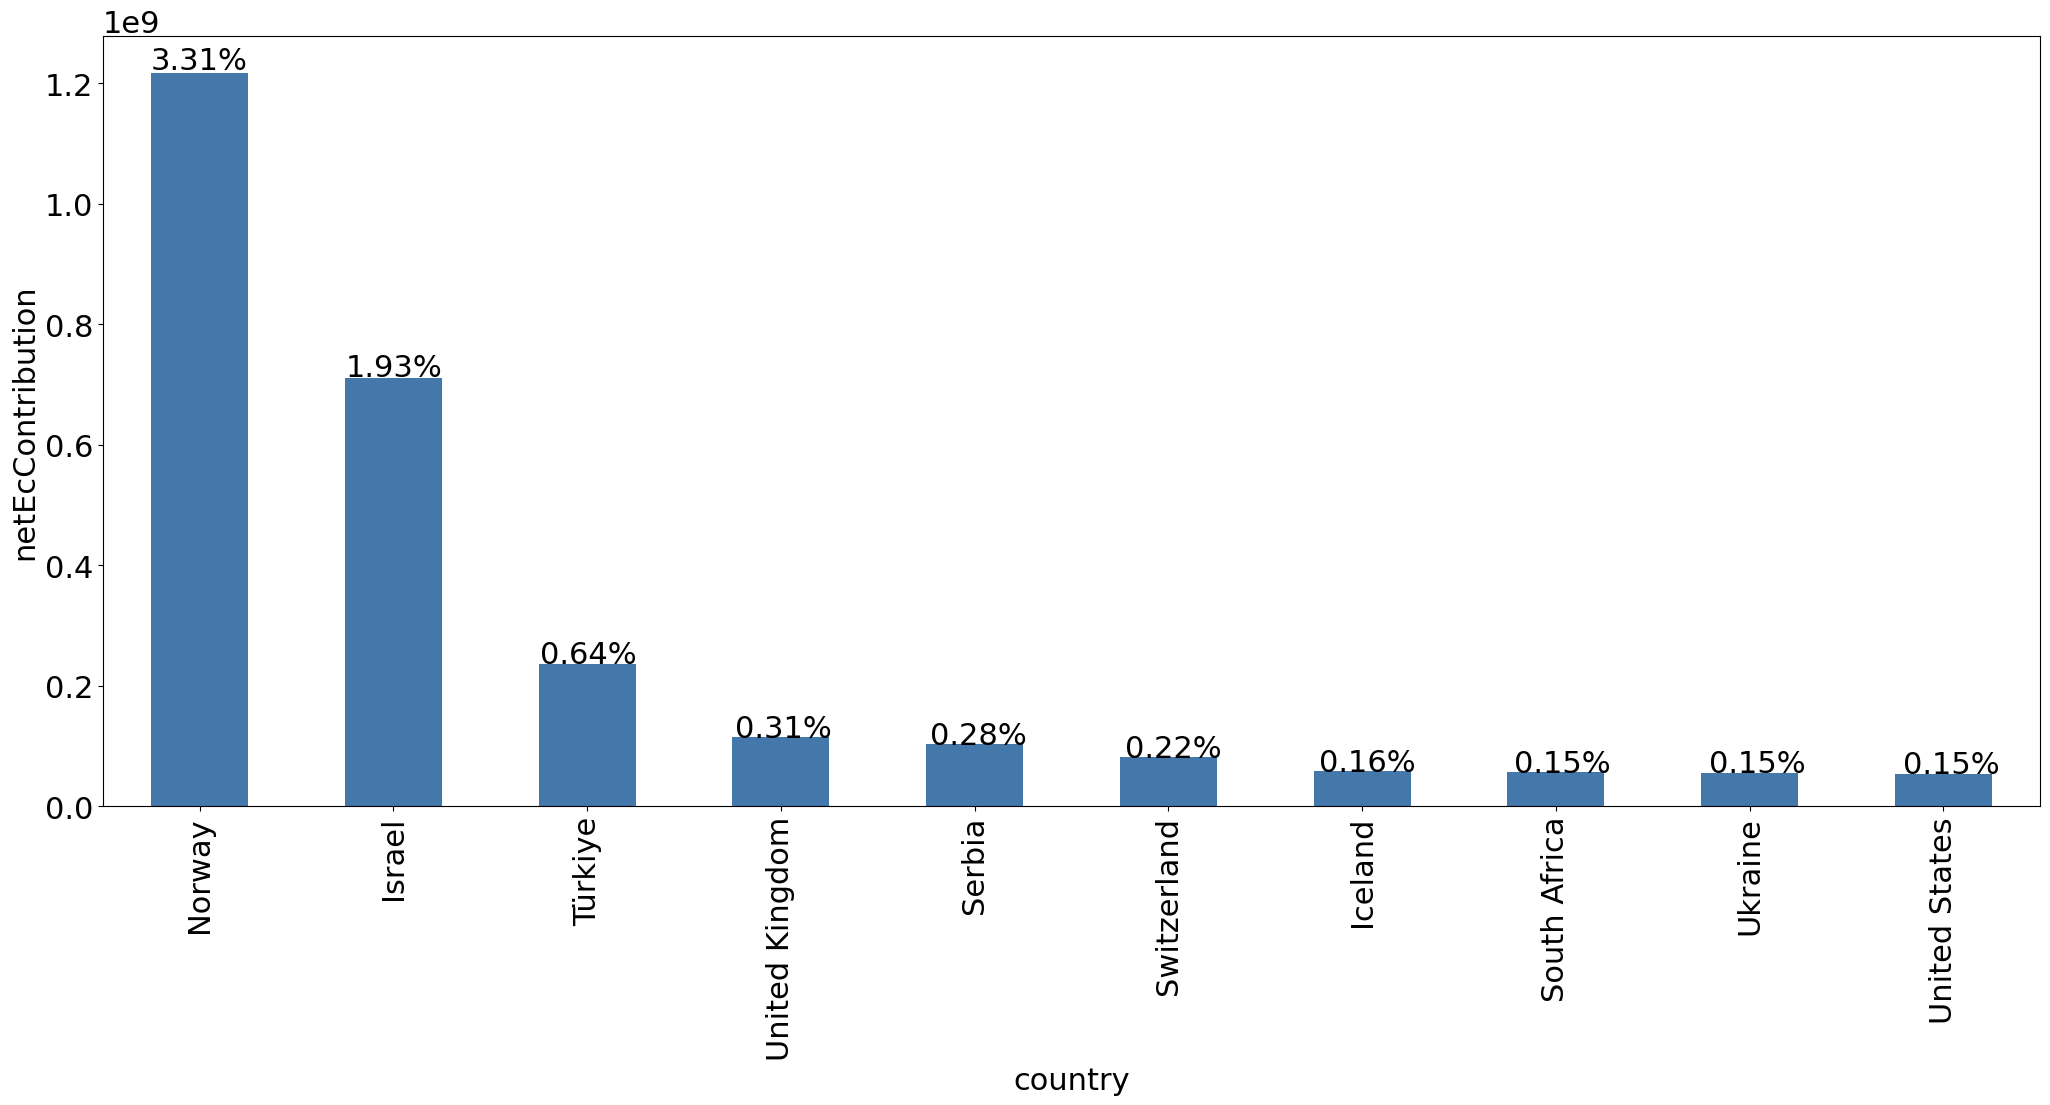

In [18]:
ax = org_df[org_df["in_EU"] == False].groupby("country")["netEcContribution"].sum().sort_values(ascending=False).head(10).plot.bar(color=blue, figsize=(25,10), fontsize=22)

# ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=22)
country_labels = [get_country_name(c.get_text()) for c in ax.get_xticklabels()]
ax.set_xticklabels(labels=country_labels, fontsize=22)
ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel("netEcContribution", fontsize=22)

formatter = ScalarFormatter(useOffset=True, useMathText=False)
formatter.set_scientific(True)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(22)

for p in ax.patches:
    ax.annotate(f"{p.get_height() / netEcSum * 100:.2f}%", (p.get_x() * 1.005, p.get_height()* 1.005), fontsize=22)


## Per category

In [19]:
categories_activityType_netEc = defaultdict(lambda: defaultdict(float))
subcategories_activityType_netEc = defaultdict(lambda: defaultdict(float))
subsubcategories_activityType_netEc = defaultdict(lambda: defaultdict(float))

def fill_categories_activityType_dicts(ecmax, activityType, categories, subcategories, subsubcategories):
    if pd.isna(categories):
        return
    if pd.isna(activityType):
        return

    categories = ast.literal_eval(categories)
    for category in categories:
        categories_activityType_netEc[category.upper()][activityType] += ecmax
        
    if pd.isna(subcategories):
        return
    subcategories = ast.literal_eval(subcategories)
    for _, subcat in subcategories:
        subcategories_activityType_netEc[subcat.upper()][activityType] += ecmax
    
    if pd.isna(subsubcategories):
        return
    subsubcategories = ast.literal_eval(subsubcategories)
    for _, subsubcat in subsubcategories:
        subsubcategories_activityType_netEc[subsubcat.upper()][activityType] += ecmax
        
_ = org_df.apply(lambda row: fill_categories_activityType_dicts(row.ecMaxContribution, row.activityType, row.categories, row.subcategories, row.subsubcategories), axis=1)


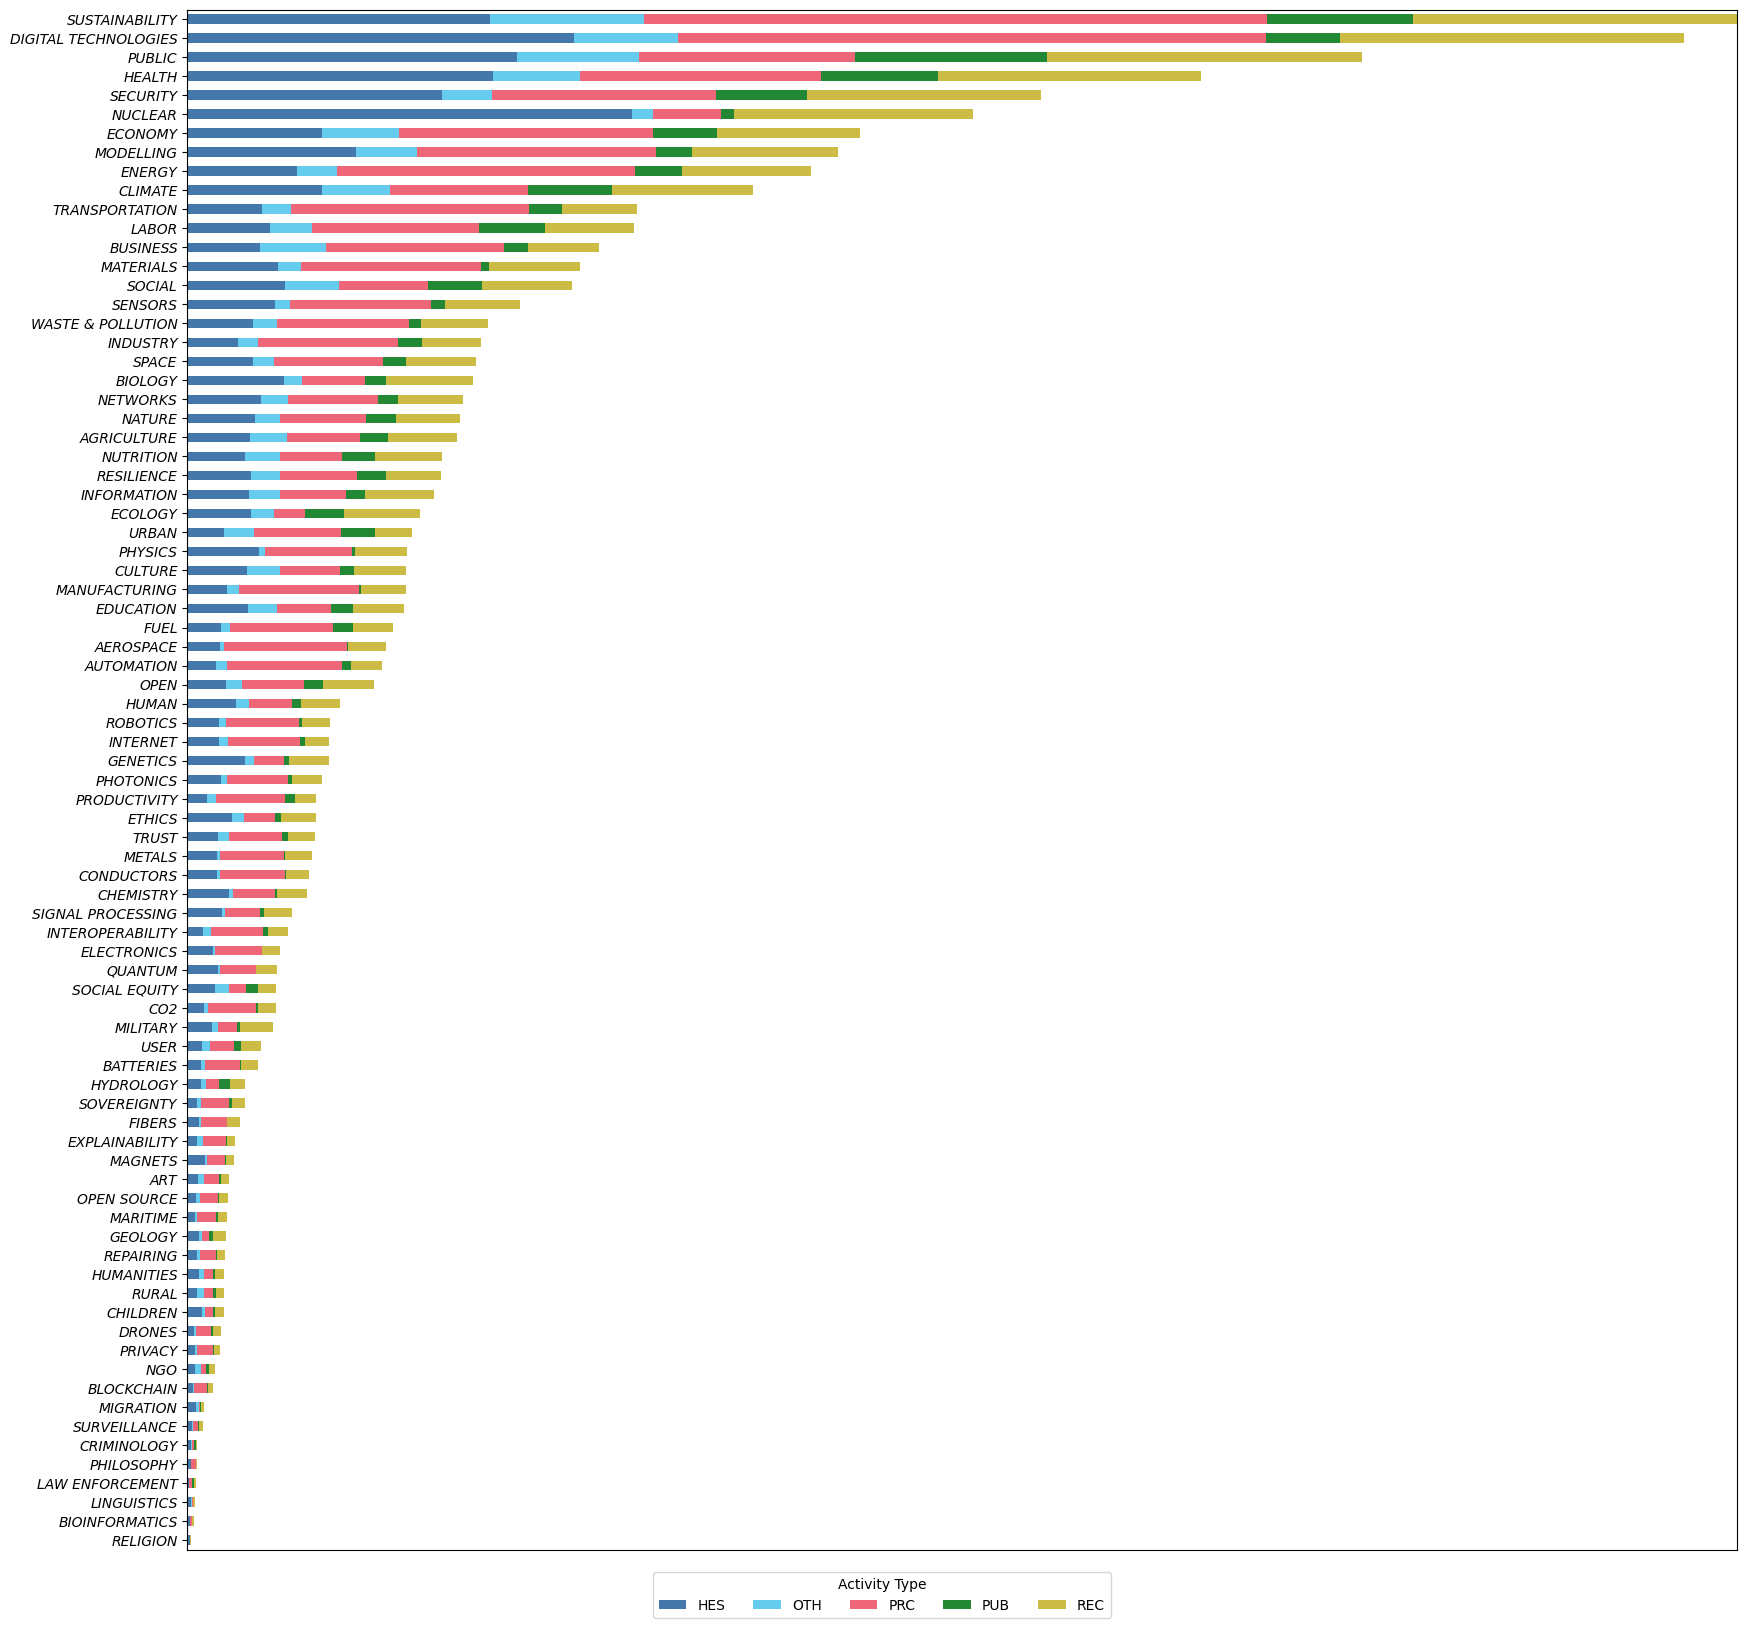

In [20]:
cat_activityType_df = pd.DataFrame.from_dict(categories_activityType_netEc, orient='index')

cat_activityType_df = cat_activityType_df.loc[cat_activityType_df.sum(1).sort_values(ascending=True).index]
cat_activityType_df = cat_activityType_df.loc[:, sorted([str(x) for x in cat_activityType_df.columns])]

ax = cat_activityType_df.plot.barh(stacked=True, color=activityType_colors, figsize=(20,20))
ax.set_xmargin(0)
ax.set_xticks([])
ax.legend(title="Activity Type", ncol=5, bbox_to_anchor=(0.6, -0.01))


for label in ax.get_yticklabels():
    if label.get_text() == "all":
        label.set_fontweight("bold")
    else:
        label.set_style("italic")


In [21]:
def plot_activityType_per_category(category, category_dict):
    cat_df = pd.DataFrame.from_dict(category_dict[category], orient='index')
    cat_df = cat_df.sort_values(0, ascending=False)
    ax = cat_df.plot.bar(color=activityType_colors, legend=False)
    ax.set_title(f"NetEcContribution for Category {category} per ActivityType", fontsize=10)
    

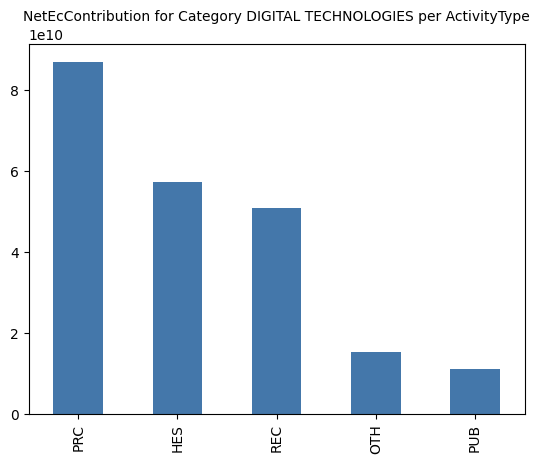

In [22]:
plot_activityType_per_category("DIGITAL TECHNOLOGIES", categories_activityType_netEc)

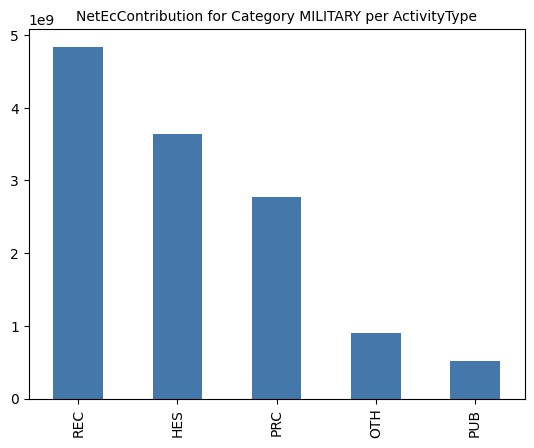

In [23]:
plot_activityType_per_category("MILITARY", categories_activityType_netEc)

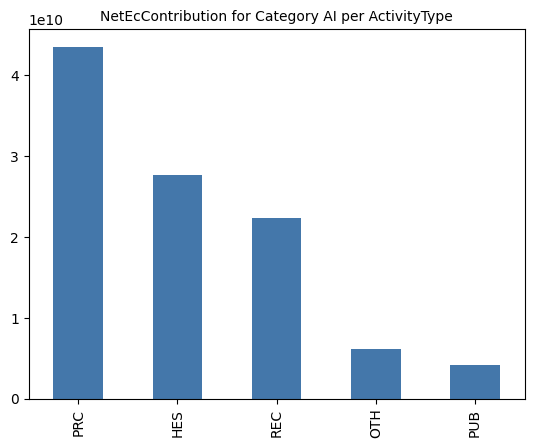

In [24]:
plot_activityType_per_category("AI", subcategories_activityType_netEc)

In [25]:
plot_activityType_per_category("DATA", subcategories_activityType_netEc)

## Other

In [26]:
print("avg number of organisations per project:", org_df.groupby("projectID").size().mean())


avg number of organisations per project: 6.439008336989908


# General

## Number of projects per category

In [27]:
categories_project_counts = defaultdict(int)
categories_project_ecmax = defaultdict(int)
subcategories_project_ecmax = defaultdict(int)
subsubcategories_project_ecmax = defaultdict(int)
all_project_ecmax = defaultdict(int)
all_project_counts = defaultdict(int)

def fill_categories_project_dicts(ecmax, categories, subcategories, subsubcategories):
    if pd.isna(categories):
        return

    categories = ast.literal_eval(categories)
    for category in categories:
        categories_project_counts[category] += 1
        categories_project_ecmax[category] += ecmax
        all_project_ecmax[category] += ecmax
        all_project_counts[category] += 1
        
    if pd.isna(subcategories):
        return
    subcategories = ast.literal_eval(subcategories)
    for _, subcat in subcategories:
        subcategories_project_ecmax[subcat.upper()] += ecmax
        all_project_ecmax[subcat.upper()] += ecmax
        all_project_counts[subcat.upper()] += 1
    
    if pd.isna(subsubcategories):
        return
    subsubcategories = ast.literal_eval(subsubcategories)
    for _, subsubcat in subsubcategories:
        subsubcategories_project_ecmax[subsubcat.upper()] += ecmax
        all_project_ecmax[subsubcat.upper()] += ecmax
        all_project_counts[subcat.upper()] += 1

_ = df.apply(lambda row: fill_categories_project_dicts(row.ecMaxContribution, row.categories, row.subcategories, row.subsubcategories), axis=1)

In [28]:
plt.rcParams["figure.figsize"] = (20,5)
x, y = zip(*sorted(categories_project_counts.items(), key=lambda x: x[1], reverse=True))

top_n = 25
plt.bar(x[:top_n], y[:top_n], zorder=3)
plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("number of projects")
plt.margins(x=0)
plt.title(f"Number of projects per category (Top {top_n})")
plt.show()

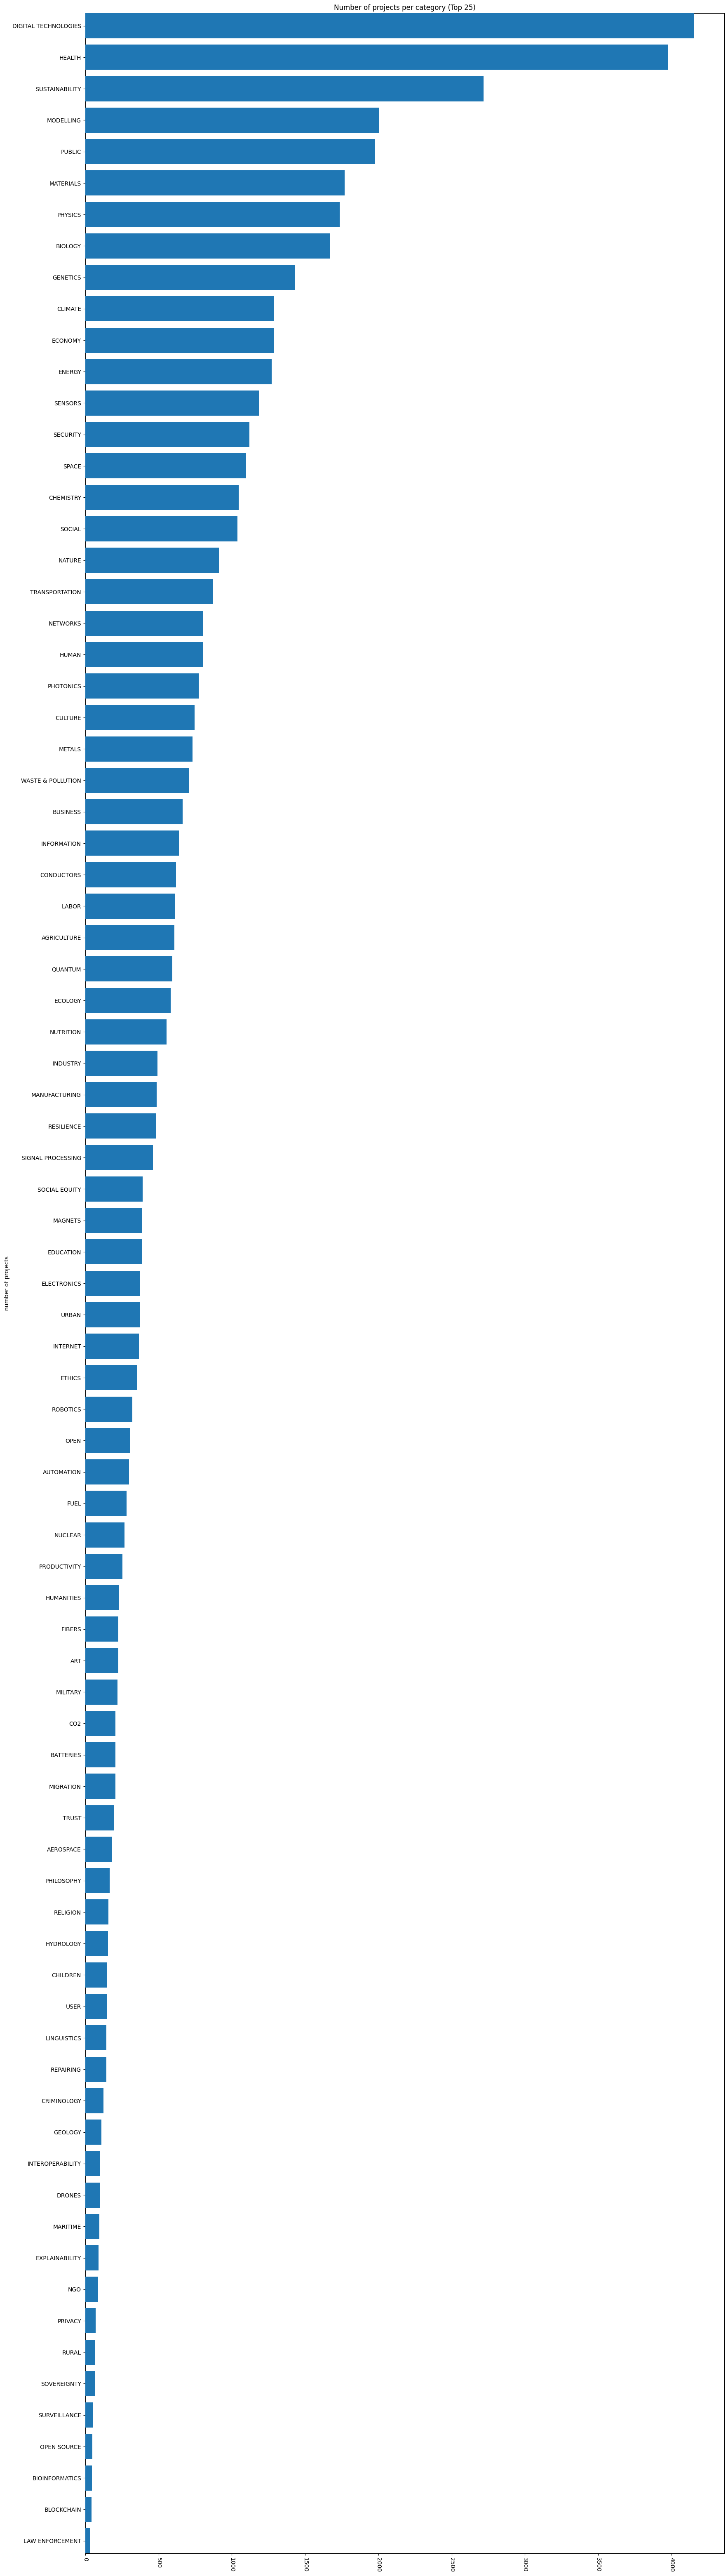

In [29]:
plt.rcParams["figure.figsize"] = (20,80)
x, y = zip(*sorted(categories_project_counts.items(), key=lambda x: x[1]))

plt.barh(x, y, zorder=3)
# plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("number of projects")
plt.margins(y=0)
plt.title(f"Number of projects per category (Top {top_n})")
plt.show()

## EcMaxContribution per category

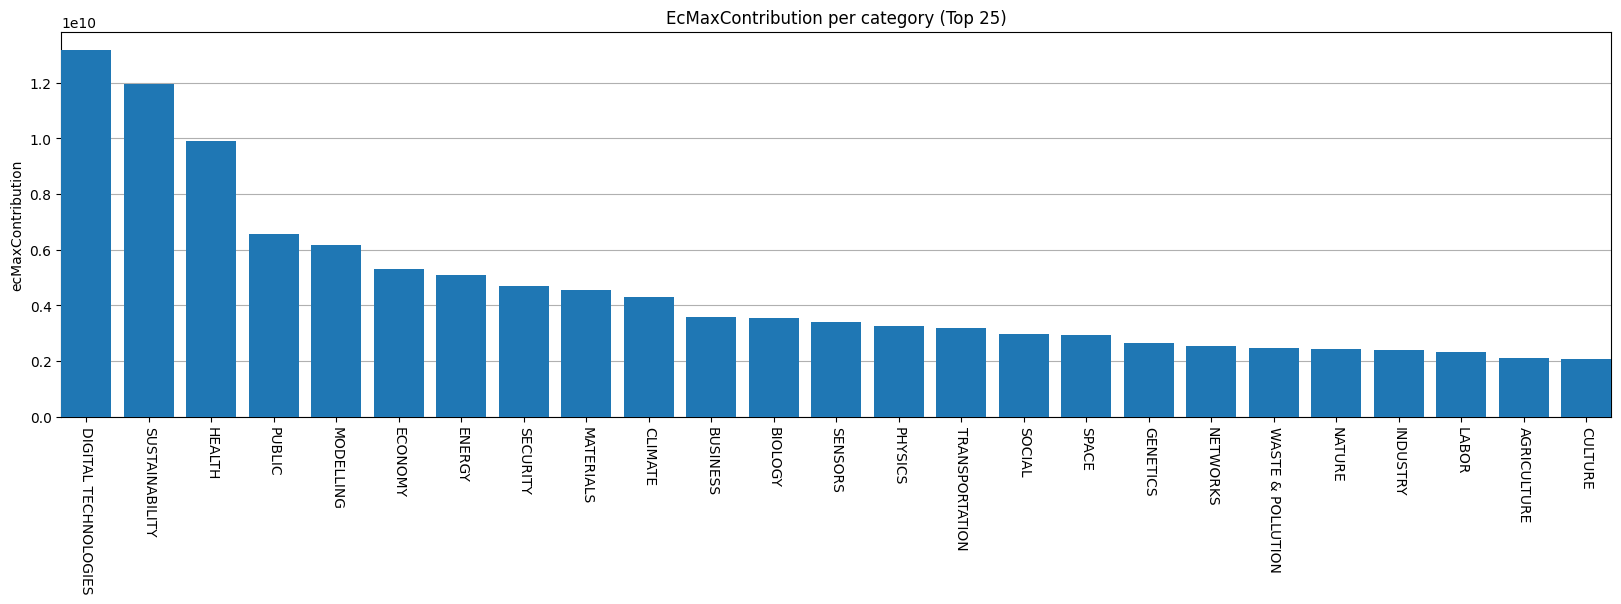

In [30]:
plt.rcParams["figure.figsize"] = (20,5)
x, y = zip(*sorted(categories_project_ecmax.items(), key=lambda x: x[1], reverse=True))

top_n = 25
plt.bar(x[:top_n], y[:top_n], zorder=3)
plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("ecMaxContribution")
plt.margins(x=0)
plt.title(f"EcMaxContribution per category (Top {top_n})")
plt.show()

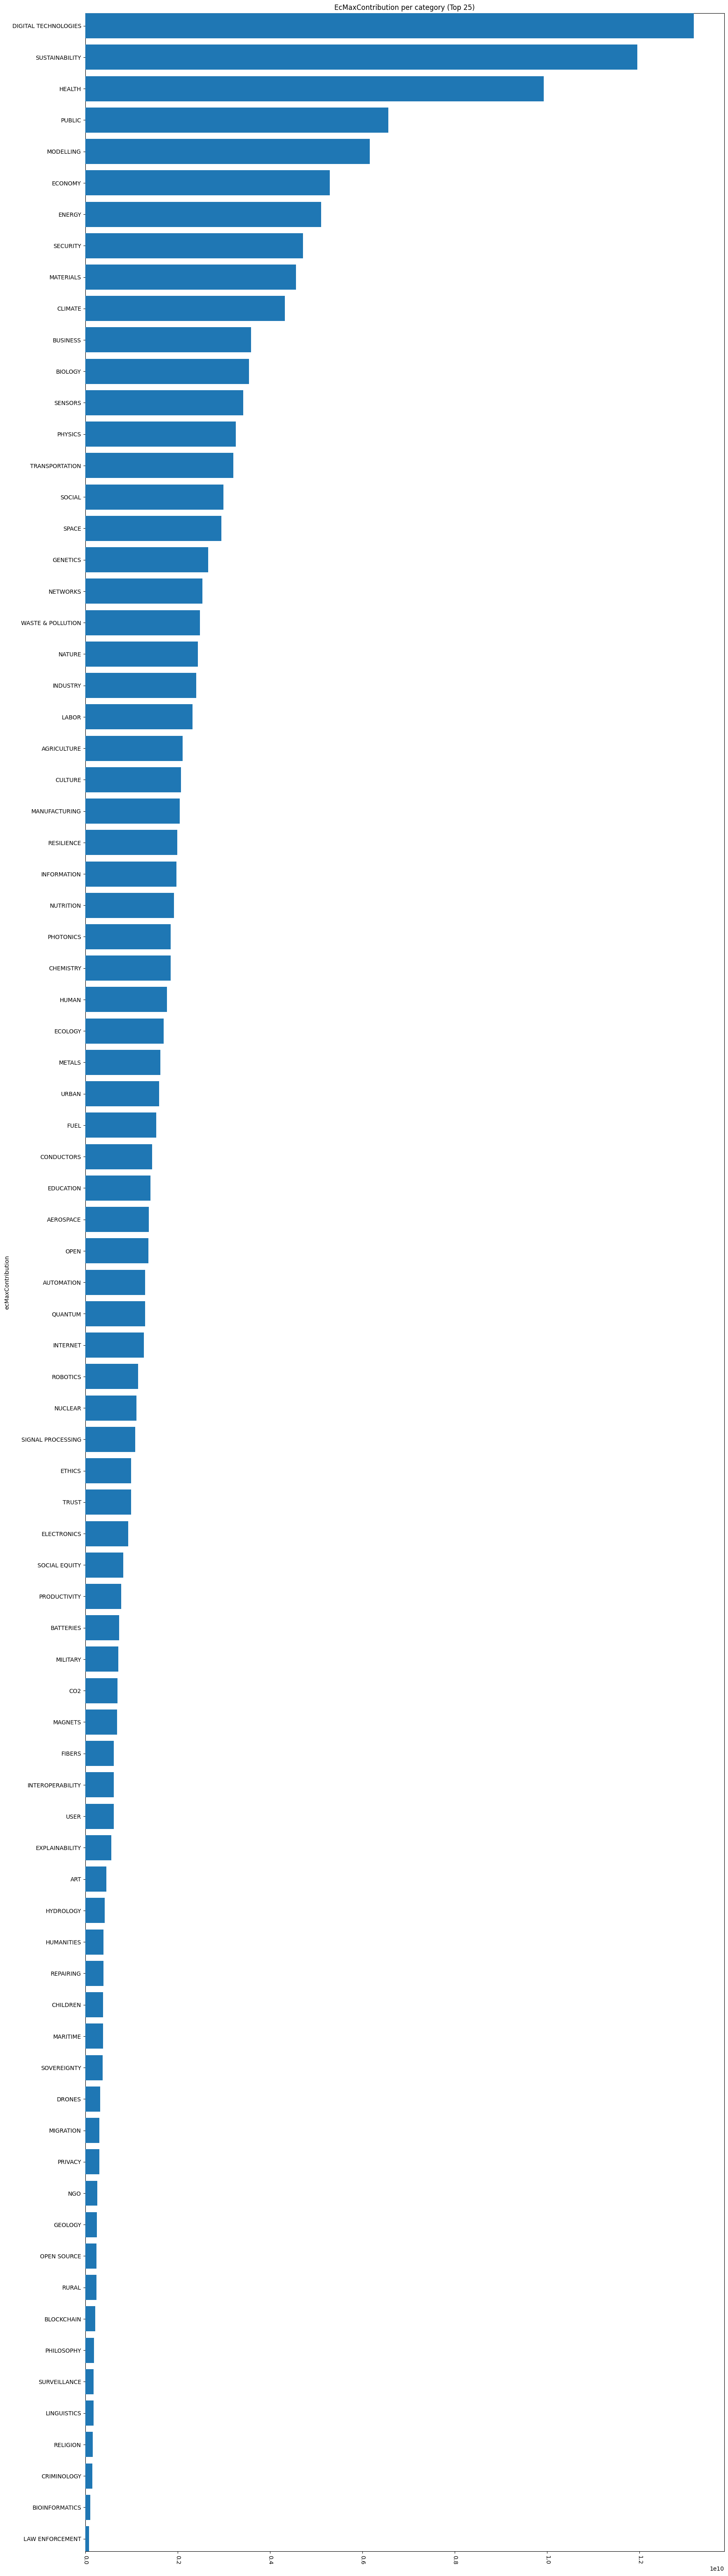

In [31]:
plt.rcParams["figure.figsize"] = (20,80)
x, y = zip(*sorted(categories_project_ecmax.items(), key=lambda x: x[1]))

plt.barh(x, y, zorder=3)
# plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("ecMaxContribution")
plt.margins(y=0)
plt.title(f"EcMaxContribution per category (Top {top_n})")
plt.show()


## Average ecMaxContribution/project

In [32]:
contribution_per_project = {}
for cat in categories_project_counts.keys():
    contribution_per_project[cat] = categories_project_ecmax[cat] / categories_project_counts[cat]

In [33]:
plt.rcParams["figure.figsize"] = (20,5)
x, y = zip(*sorted(contribution_per_project.items(), key=lambda x: x[1], reverse=True))

top_n = 25
plt.bar(x[:top_n], y[:top_n], zorder=3)
plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("avg. ecMaxContribution per project")
plt.margins(x=0)
plt.title(f"Average ecMaxContribution per project (Top {top_n})")
plt.show()

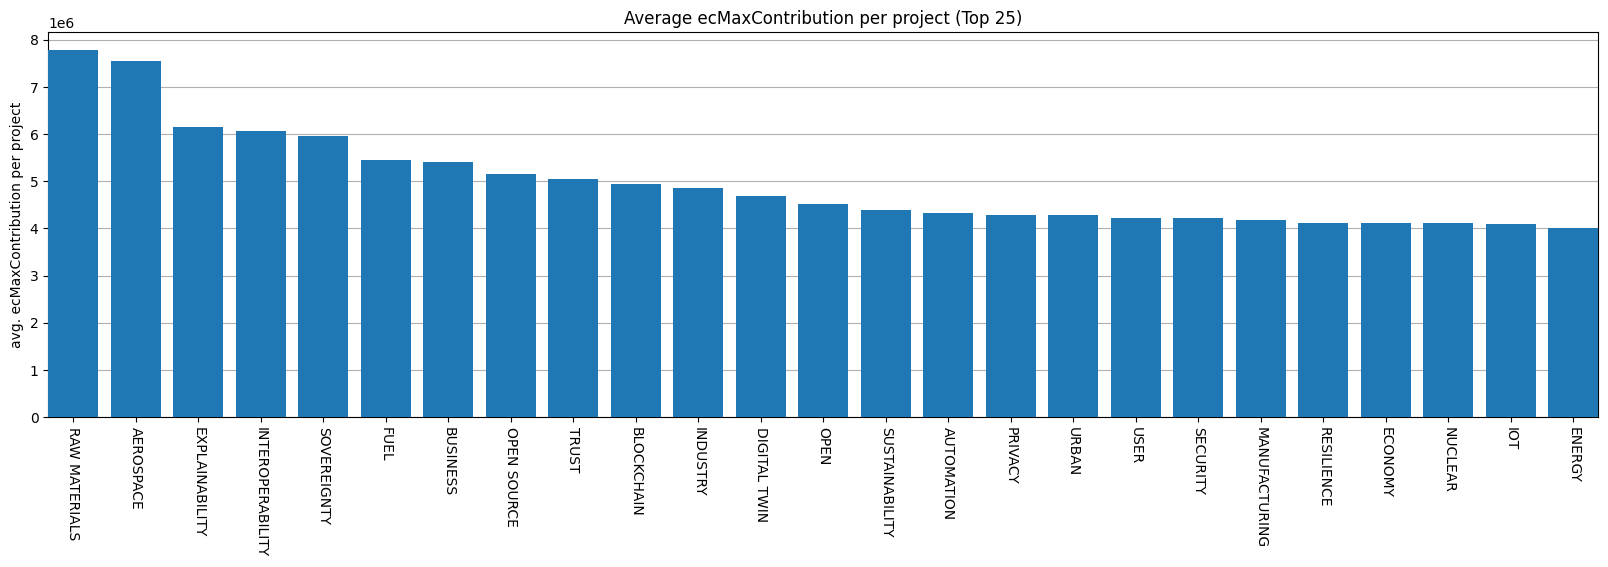

ALL


In [34]:
contribution_per_project_all = {}
for cat in all_project_counts.keys():
    contribution_per_project_all[cat] = all_project_ecmax[cat] / all_project_counts[cat]
    
plt.rcParams["figure.figsize"] = (20,5)
x, y = zip(*sorted(contribution_per_project_all.items(), key=lambda x: x[1], reverse=True))

top_n = 25
plt.bar(x[:top_n], y[:top_n], zorder=3)
plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("avg. ecMaxContribution per project")
plt.margins(x=0)
plt.title(f"Average ecMaxContribution per project (Top {top_n})")
plt.show()

print("ALL")

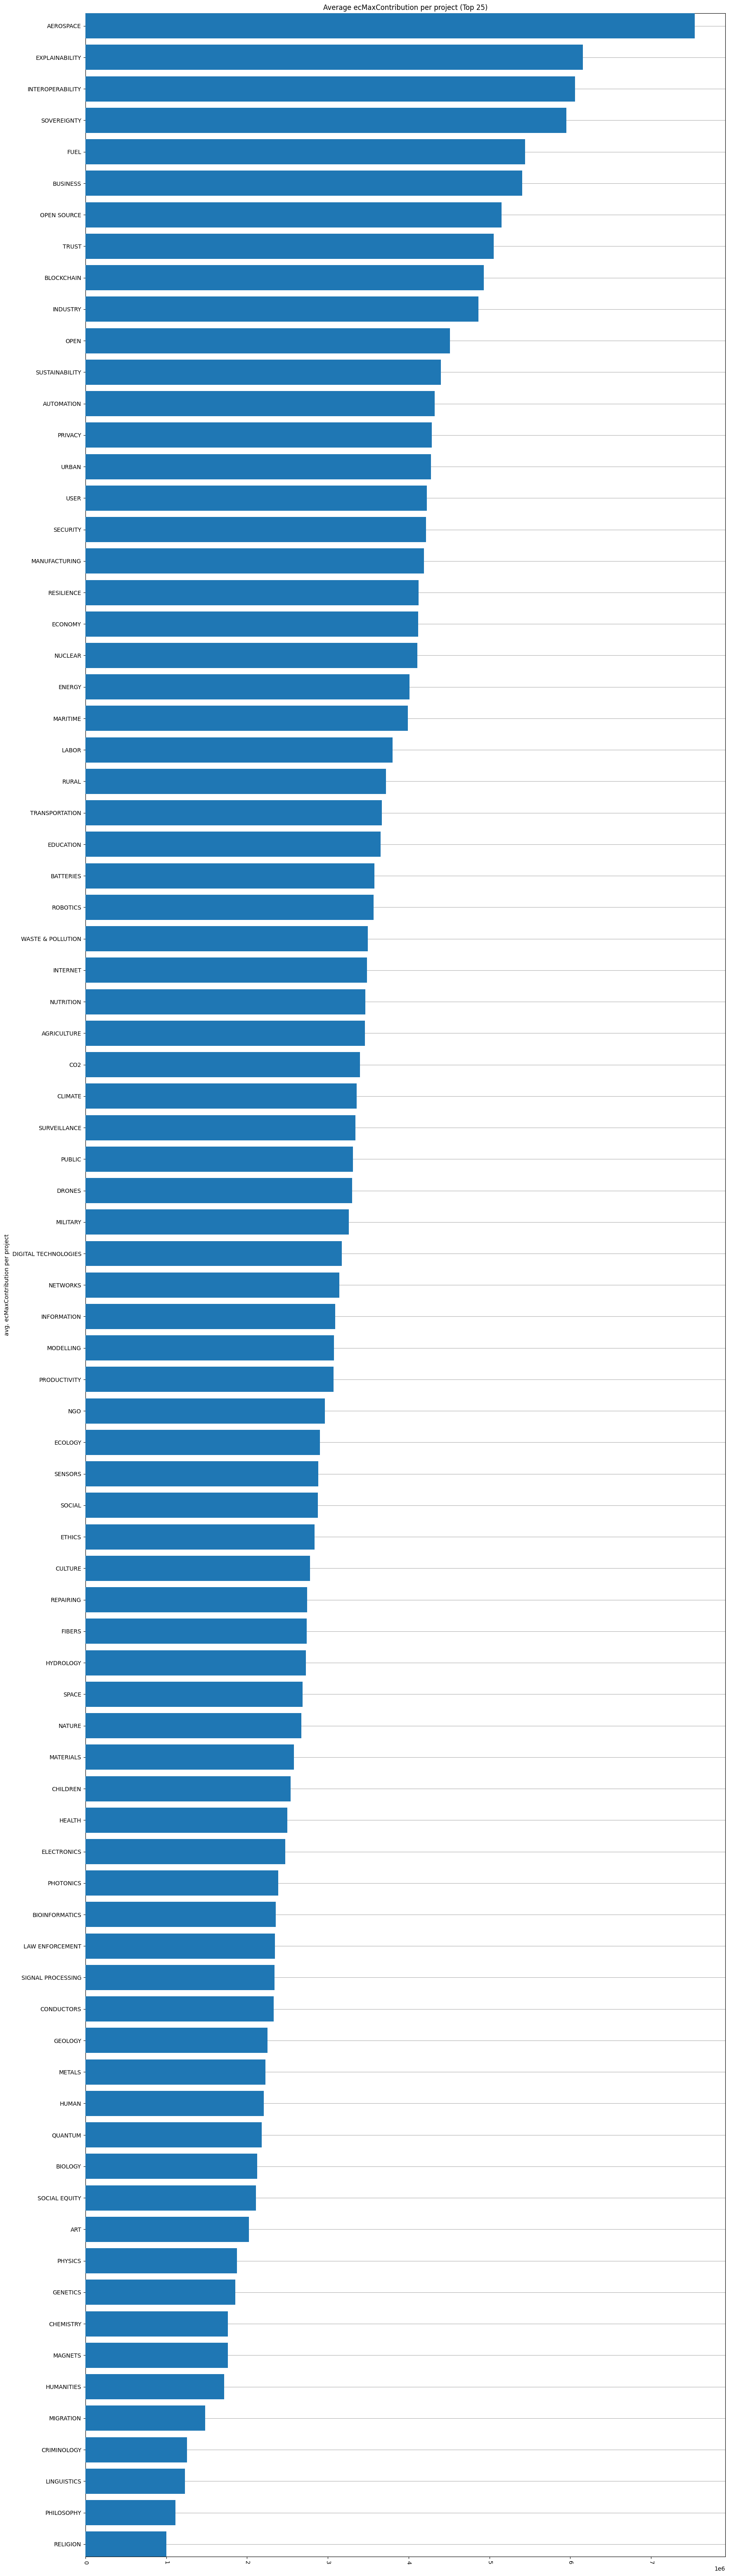

In [35]:
plt.rcParams["figure.figsize"] = (20,80)
x, y = zip(*sorted(contribution_per_project.items(), key=lambda x: x[1]))

plt.barh(x, y, zorder=3)
plt.grid(axis="y", zorder=0)
plt.xticks(rotation=-90)
plt.ylabel("avg. ecMaxContribution per project")
plt.margins(y=0)
plt.title(f"Average ecMaxContribution per project (Top {top_n})")
plt.show()

# Clusters

## Total EcMaxContribution

In [36]:
df["categories"] = df.apply(lambda row: ast.literal_eval(row.categories) if pd.notna(row.categories) else None, axis=1)
df["subcategories"] = df.apply(lambda row: ast.literal_eval(row.subcategories) if pd.notna(row.subcategories) else None, axis=1)
df["subsubcategories"] = df.apply(lambda row: ast.literal_eval(row.subsubcategories) if pd.notna(row.subsubcategories) else None, axis=1)



In [37]:
df_exploded = df.explode("categories").reset_index()
df_exploded = df_exploded.groupby(["categories", "cluster"]).agg(
    num_projects=("id", "count"),
    ecMaxContribution=("ecMaxContribution", "sum")
).reset_index()

Text(0.5, 1.0, 'EcMaxContribution in 1e10')

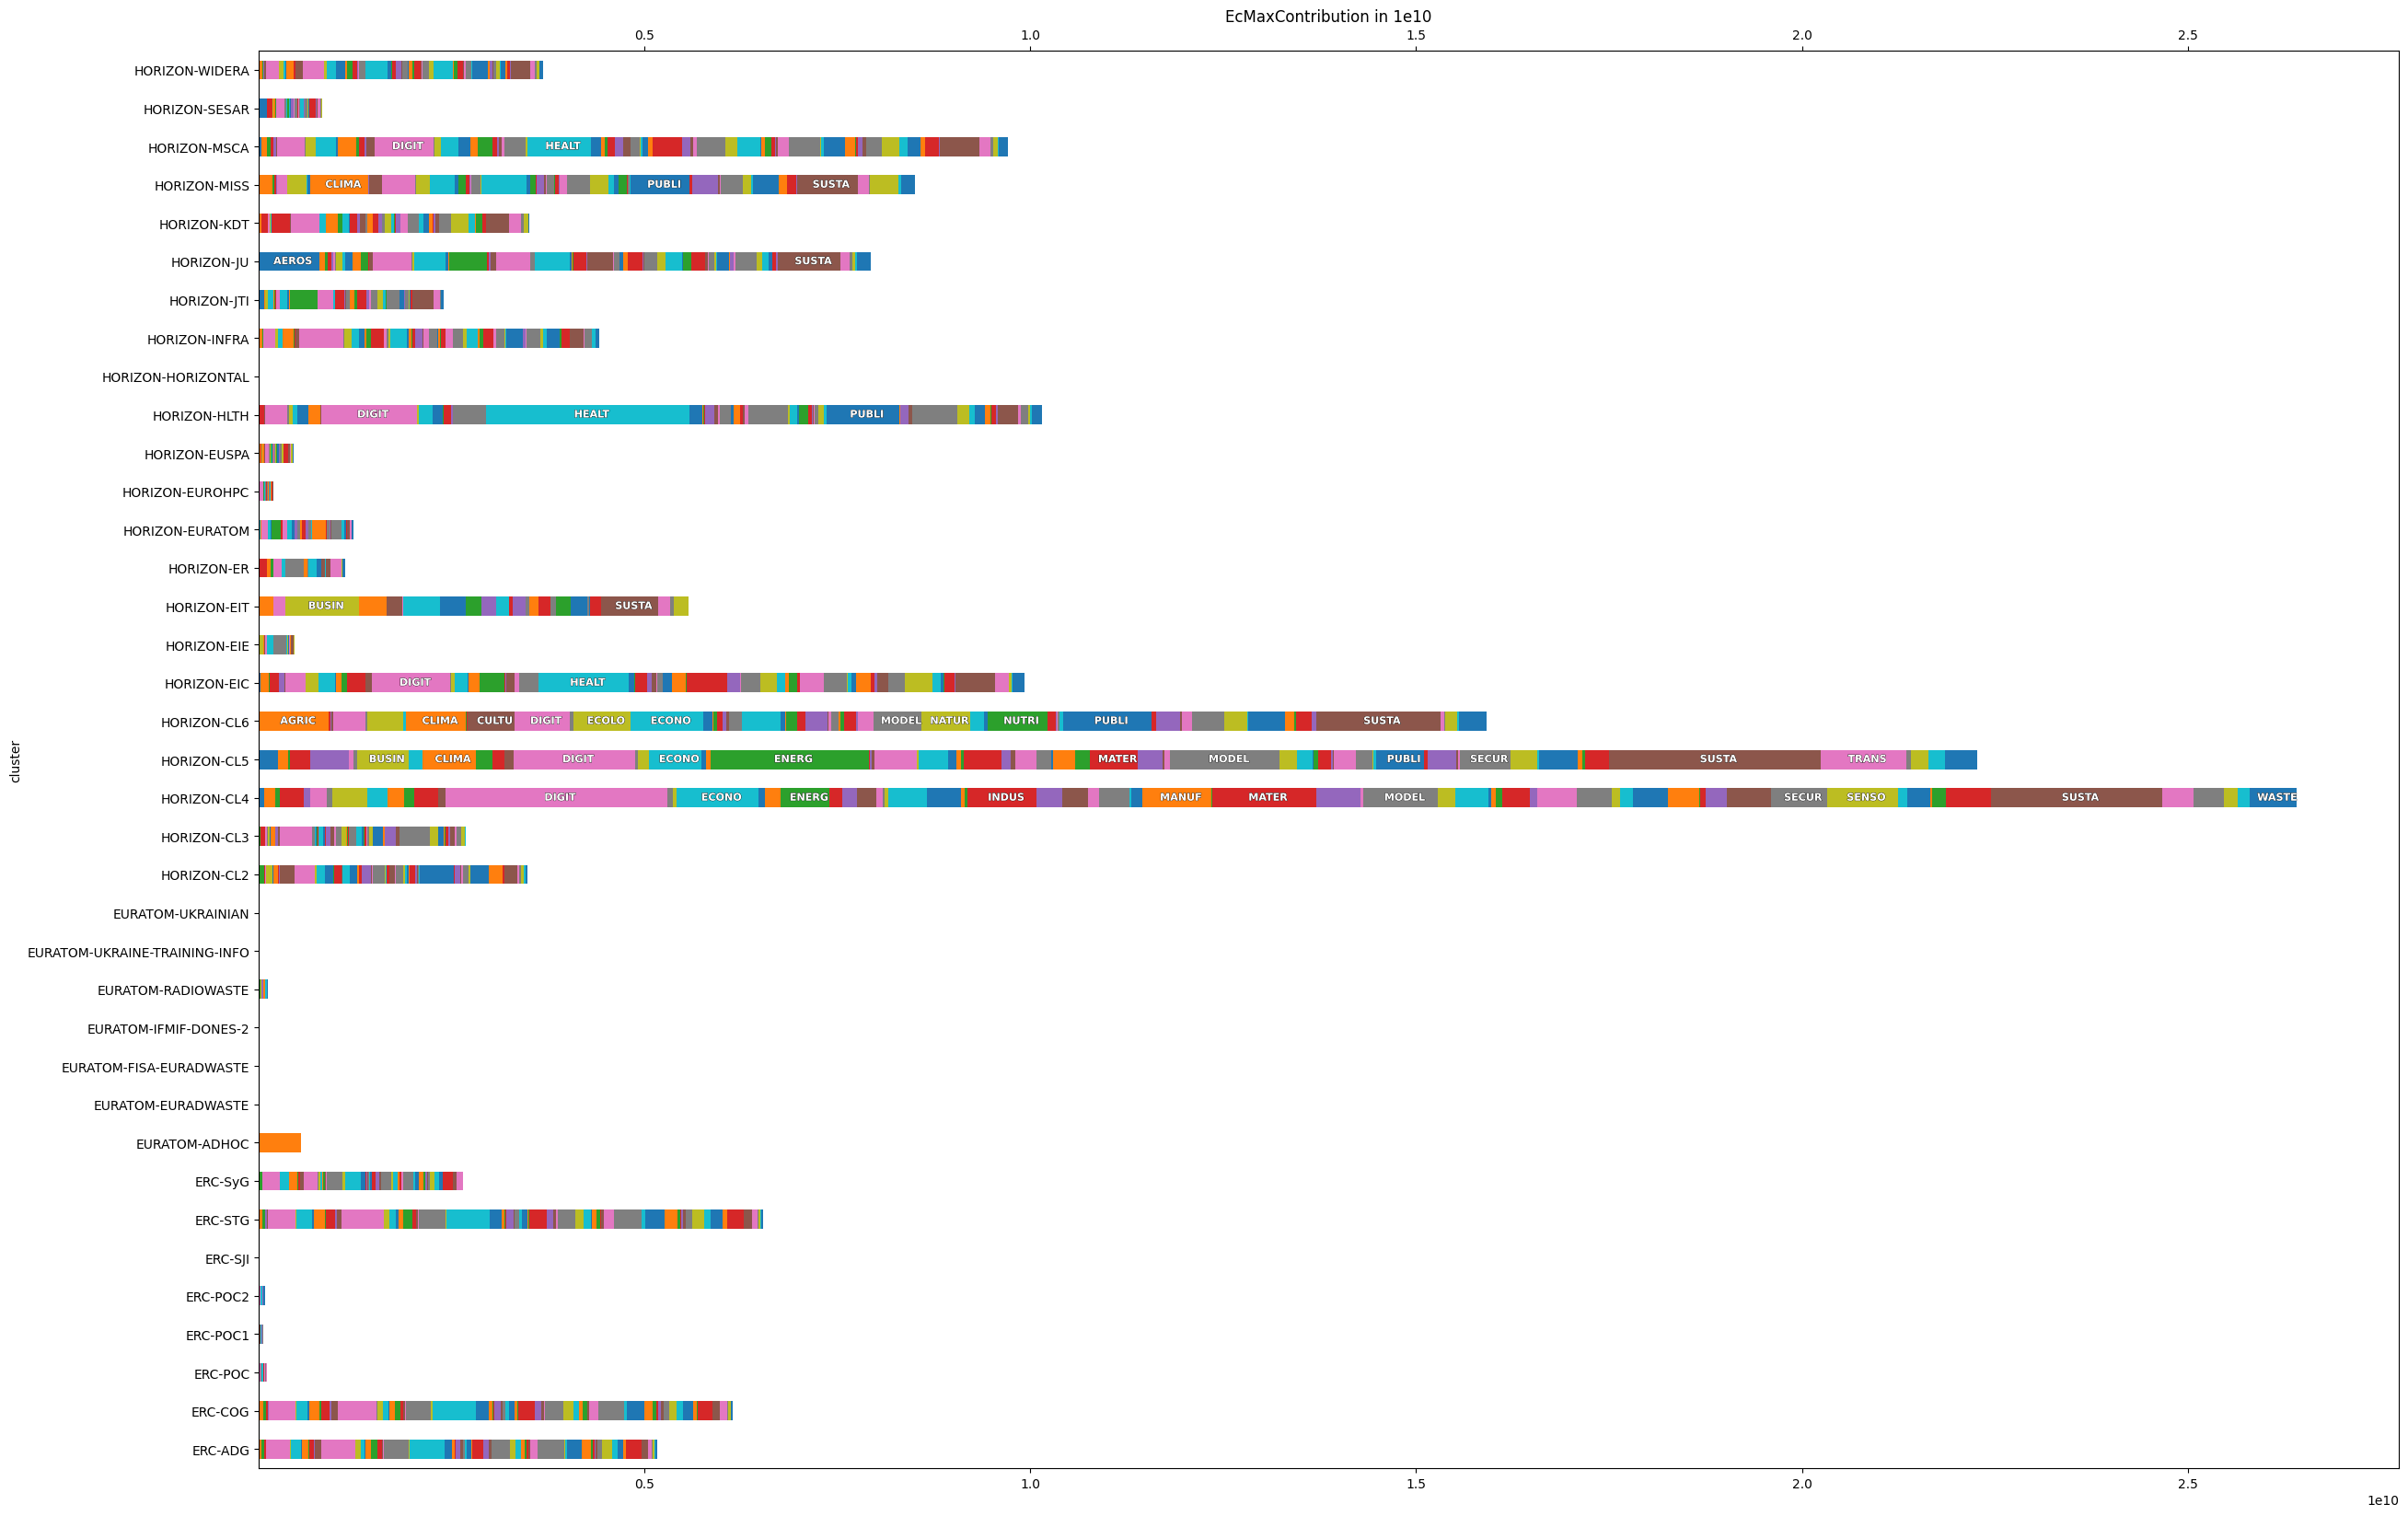

In [38]:
ecmax_per_cluster = df_exploded.groupby(["cluster", "categories"])["ecMaxContribution"].sum().unstack()
ax = ecmax_per_cluster.plot(kind="barh", stacked=True, figsize=((30,20)), legend=None)

min_amount = 0.06 * 1e10
for c, category in zip(ax.containers, ecmax_per_cluster.columns):  # Loop over bars and categories
    labels = [category[:5] if v.get_width() > min_amount else "" for v in c]  # Use category names as labels
    ax.bar_label(c, labels=labels, label_type='center', padding=3, color='white', fontsize=8, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.set_title("EcMaxContribution in 1e10")


Text(0.5, 1.0, 'EcMaxContribution in 1e10')

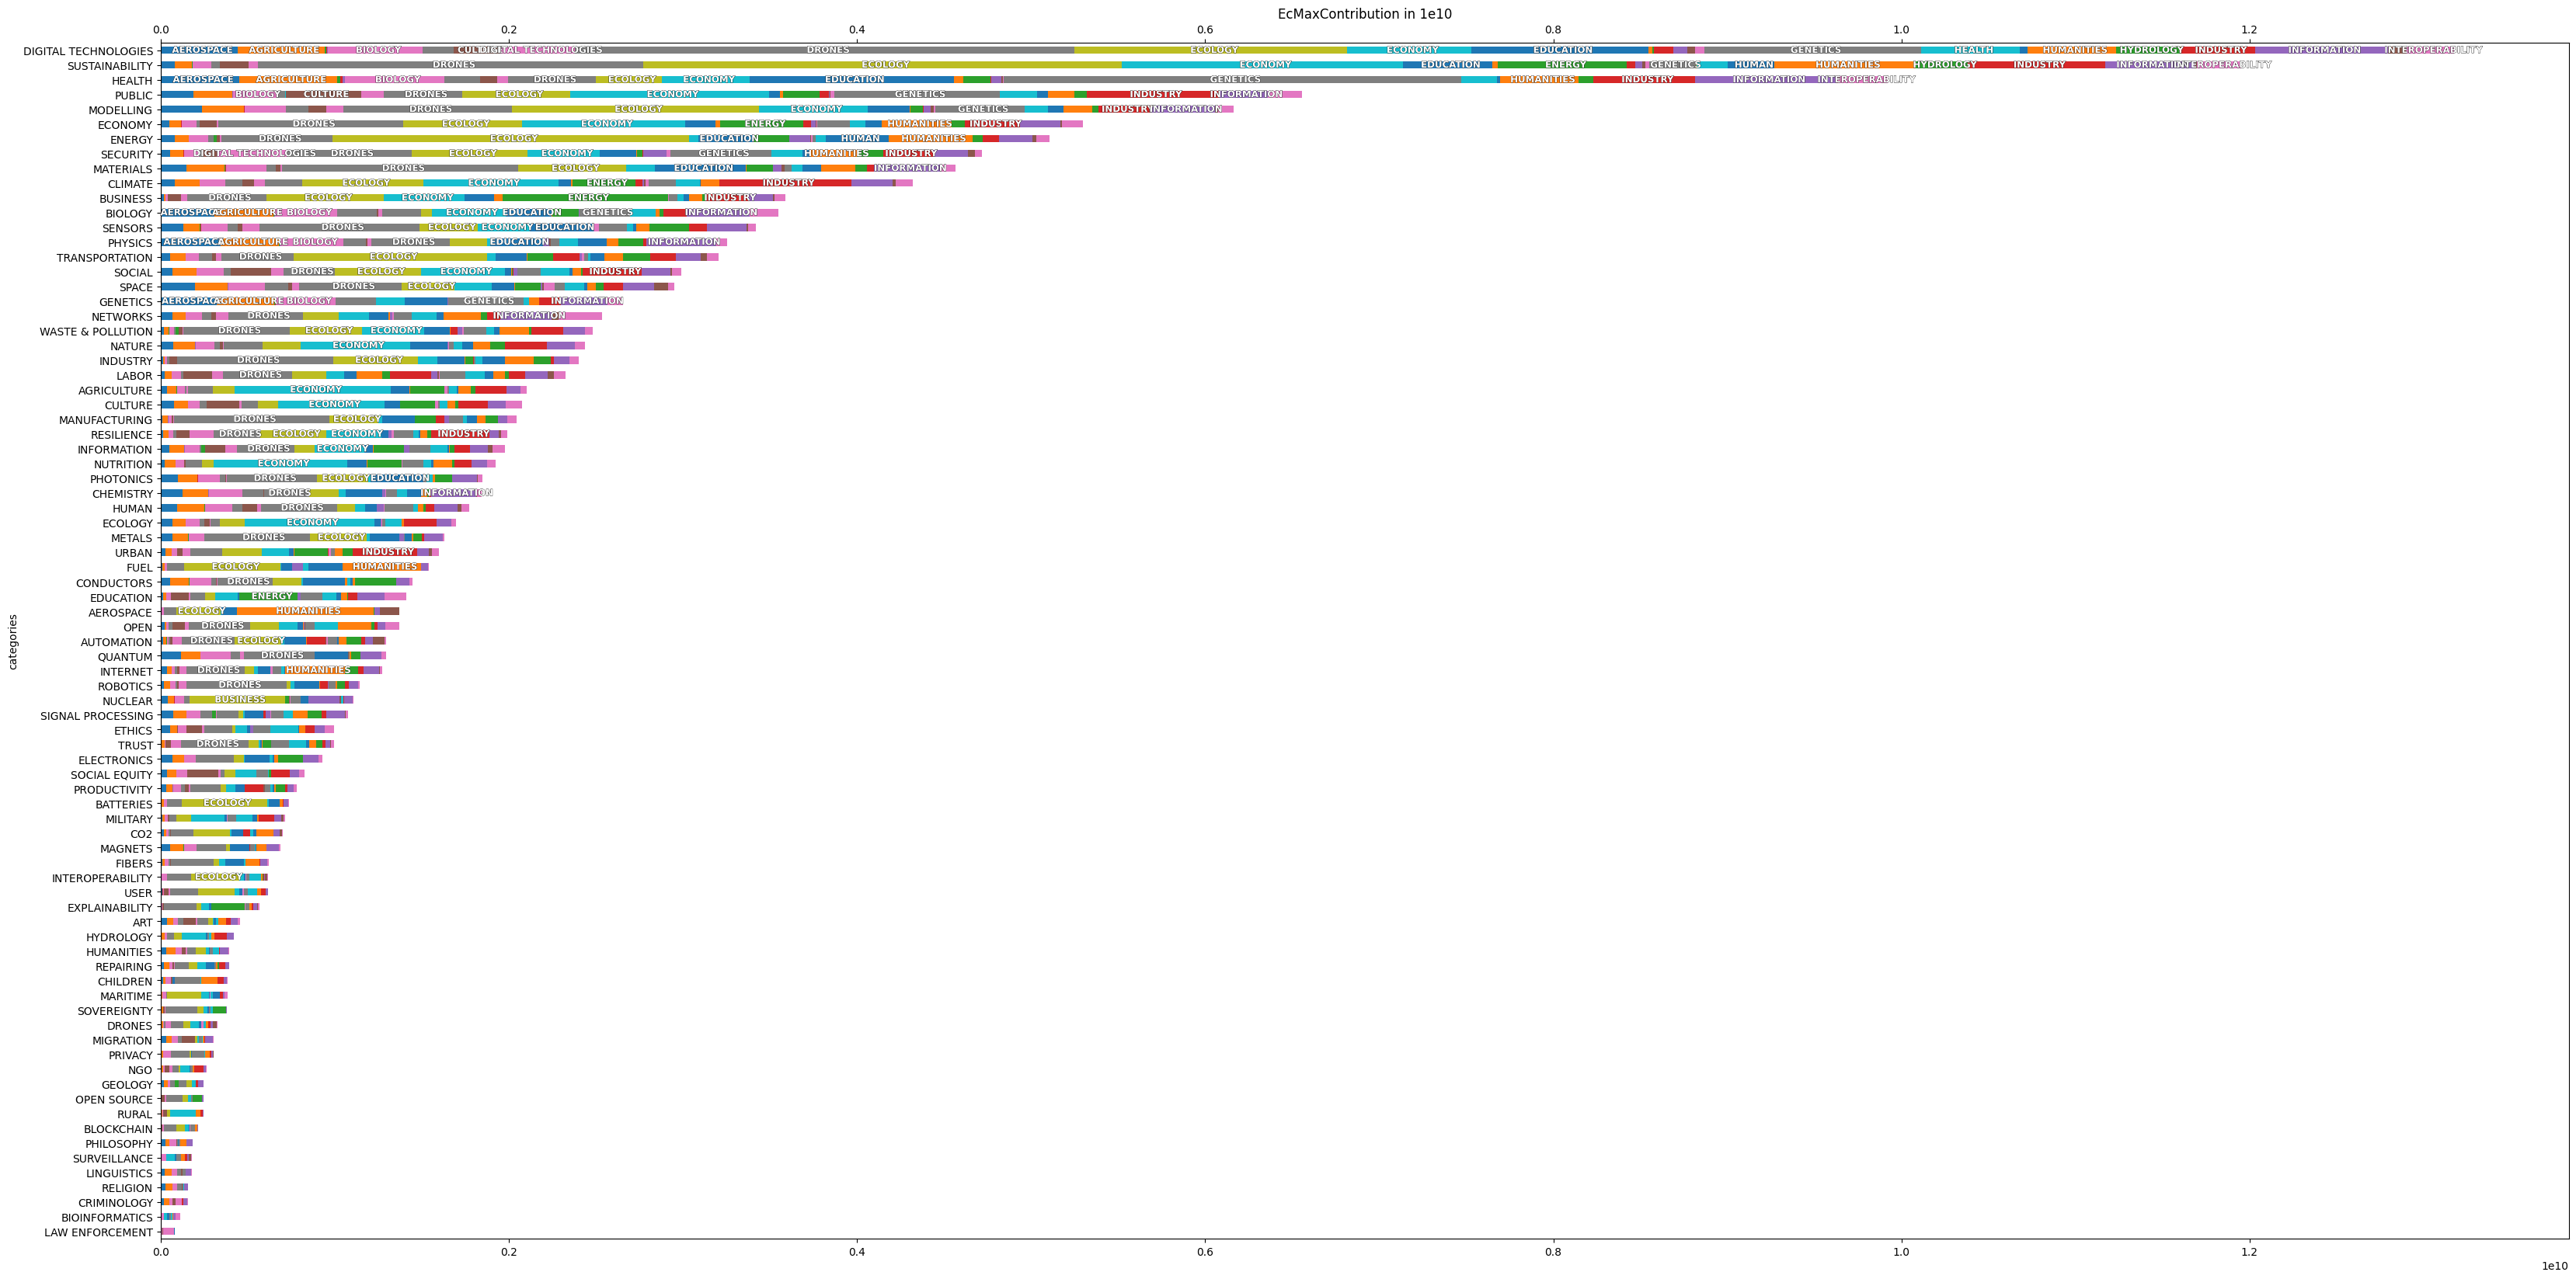

In [39]:
ecmax_per_category = df_exploded.groupby(["categories", "cluster"])["ecMaxContribution"].sum().unstack()

sorted_categories = ecmax_per_category.sum(axis=1).sort_values(ascending=True).index
ecmax_per_category = ecmax_per_category.loc[sorted_categories]

ax = ecmax_per_category.plot(kind="barh", stacked=True, figsize=((40,20)), legend=None)

min_amount = 0.025 * 1e10
for c, category in zip(ax.containers, ecmax_per_cluster.columns):
    labels = [category.replace("HORIZON", "H").replace("EURATOM", "ET") if v.get_width() > min_amount else "" for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=3, color='white', fontsize=8.5, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.set_title("EcMaxContribution in 1e10")


In [40]:
def get_bar_cluster(cluster, top_n = 10):
    cluster_df = ecmax_per_cluster.loc[cluster]
    ax = cluster_df.sort_values(ascending=False).head(top_n).plot.bar(zorder=3)
    ax.grid(axis="y", zorder=0)
    ax.set_title(f"EcMaxContribution for top {top_n} categories in cluster \"{cluster}\"")
    ax.set_ylabel("EcMaxContribution")
    ax.set_xlabel("Category")

plt.rcParams["figure.figsize"] = (20,5)


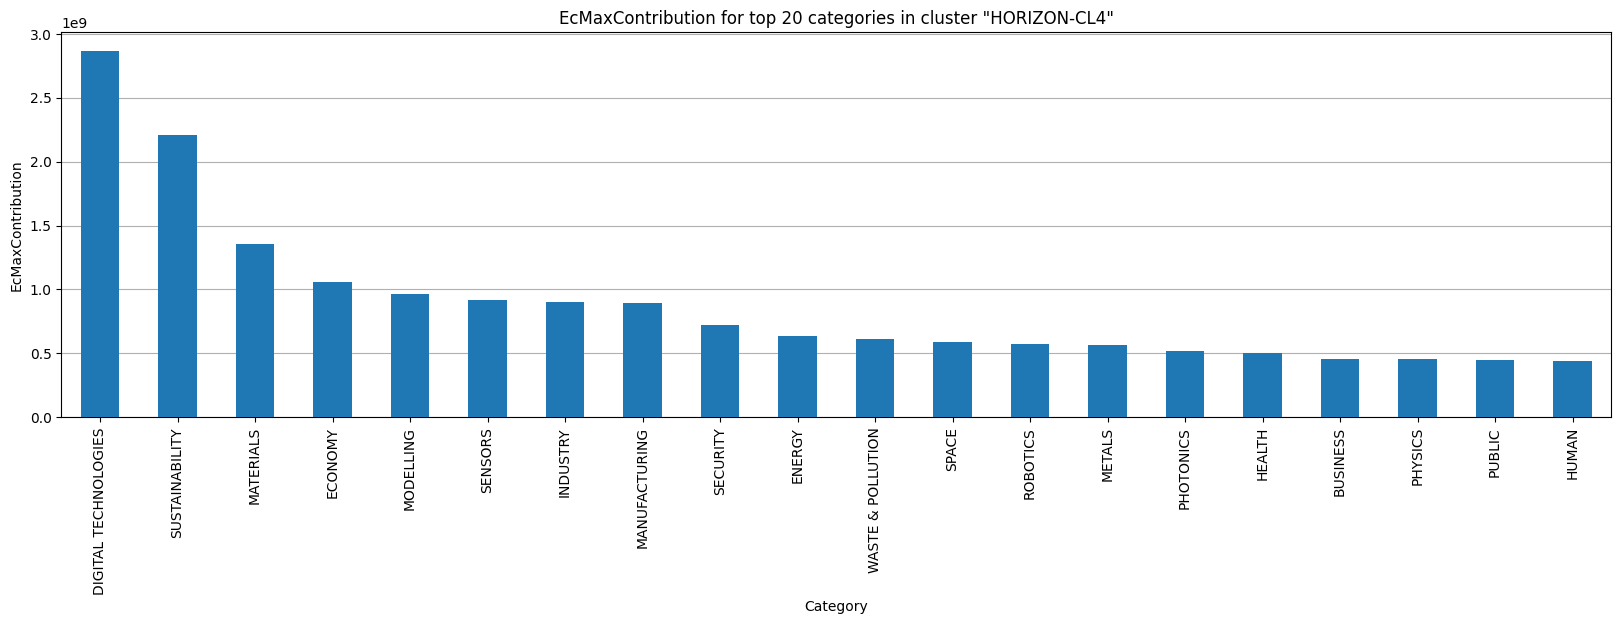

In [41]:
get_bar_cluster("HORIZON-CL4", 20)

In [42]:
def get_bar_category(cat, top_n = 10):
    category_df = ecmax_per_category.loc[cat]
    ax = category_df.sort_values(ascending=False).head(top_n).plot.bar(zorder=3)
    ax.grid(axis="y", zorder=0)
    ax.set_title(f"EcMaxContribution for top {top_n} clusters in category \"{cat}\"")
    ax.set_ylabel("EcMaxContribution")
    ax.set_xlabel("Cluster")

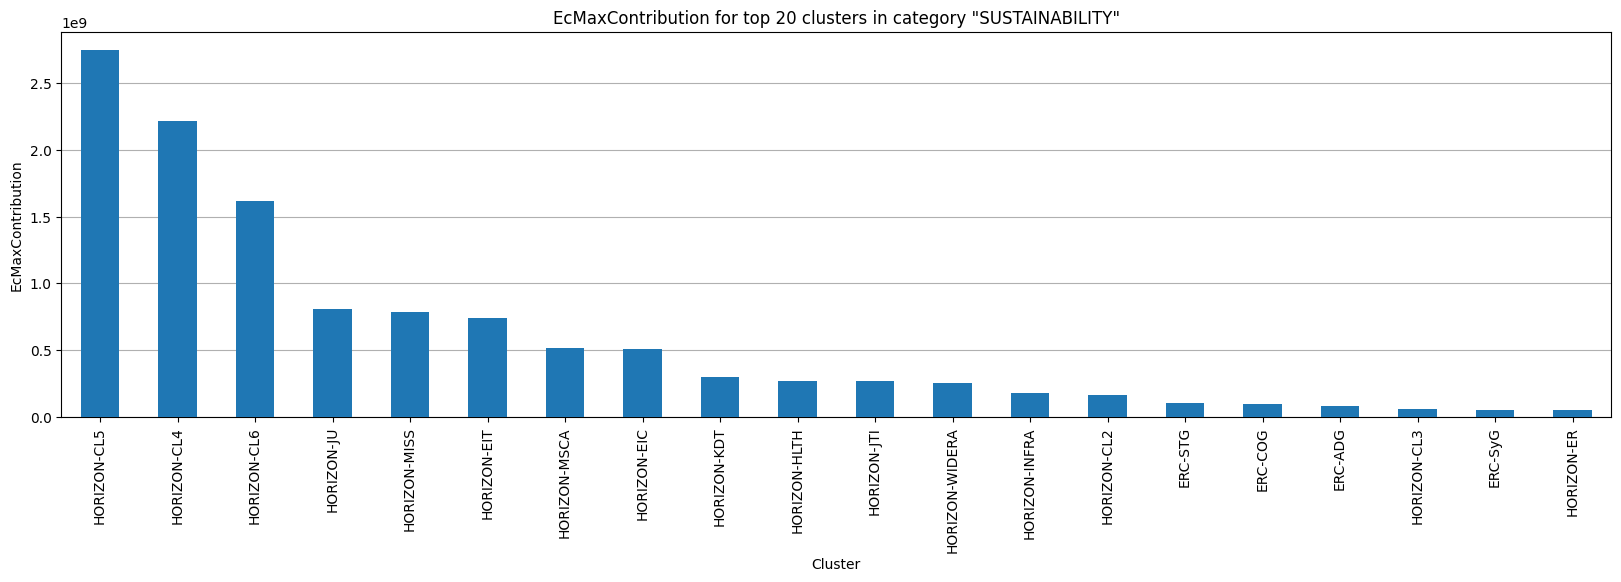

In [43]:
get_bar_category("SUSTAINABILITY", 20)

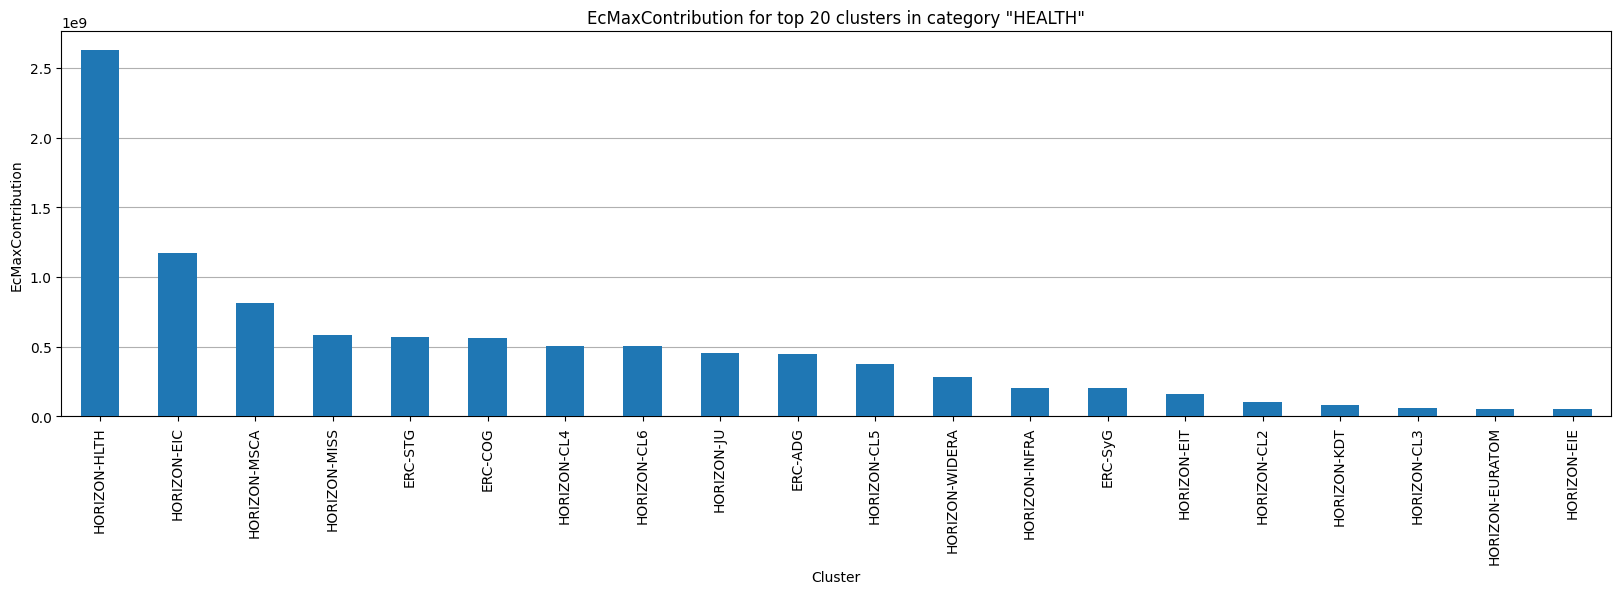

In [44]:
get_bar_category("HEALTH", 20)

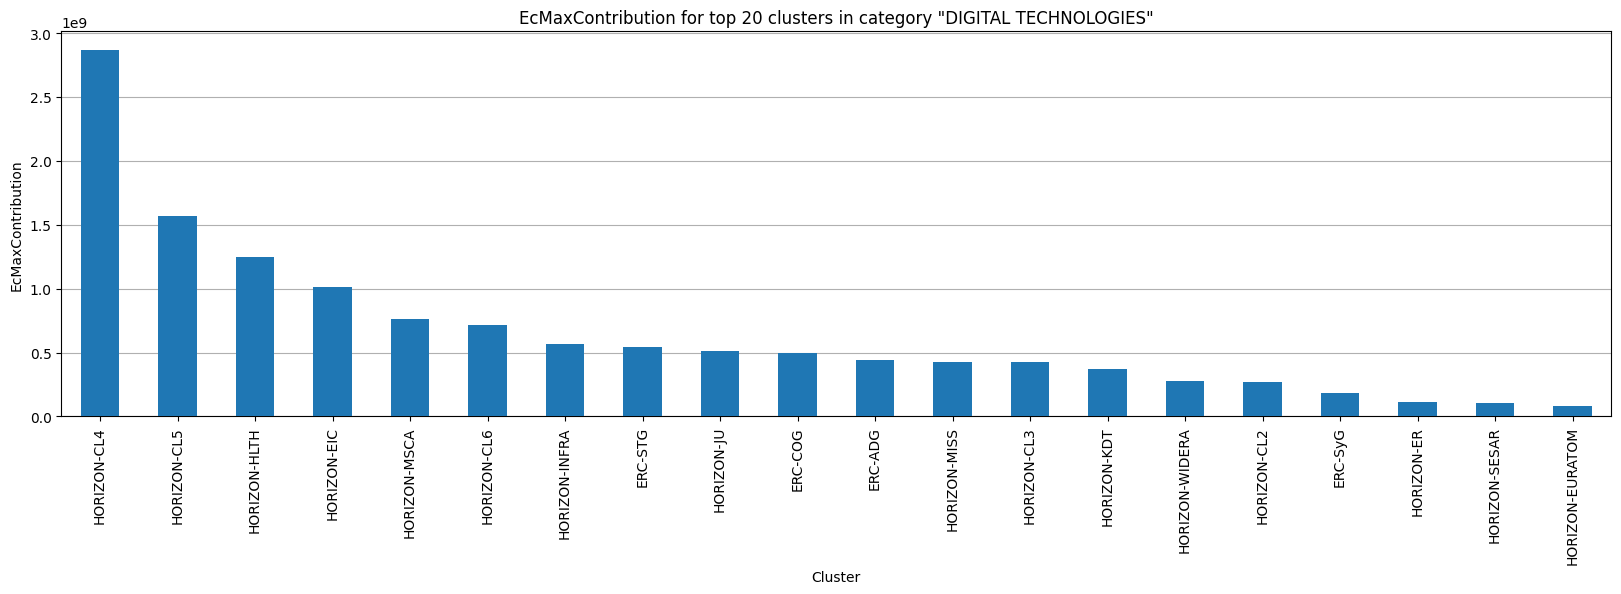

In [45]:
get_bar_category("DIGITAL TECHNOLOGIES", 20)

## Percent of EcMaxContribution

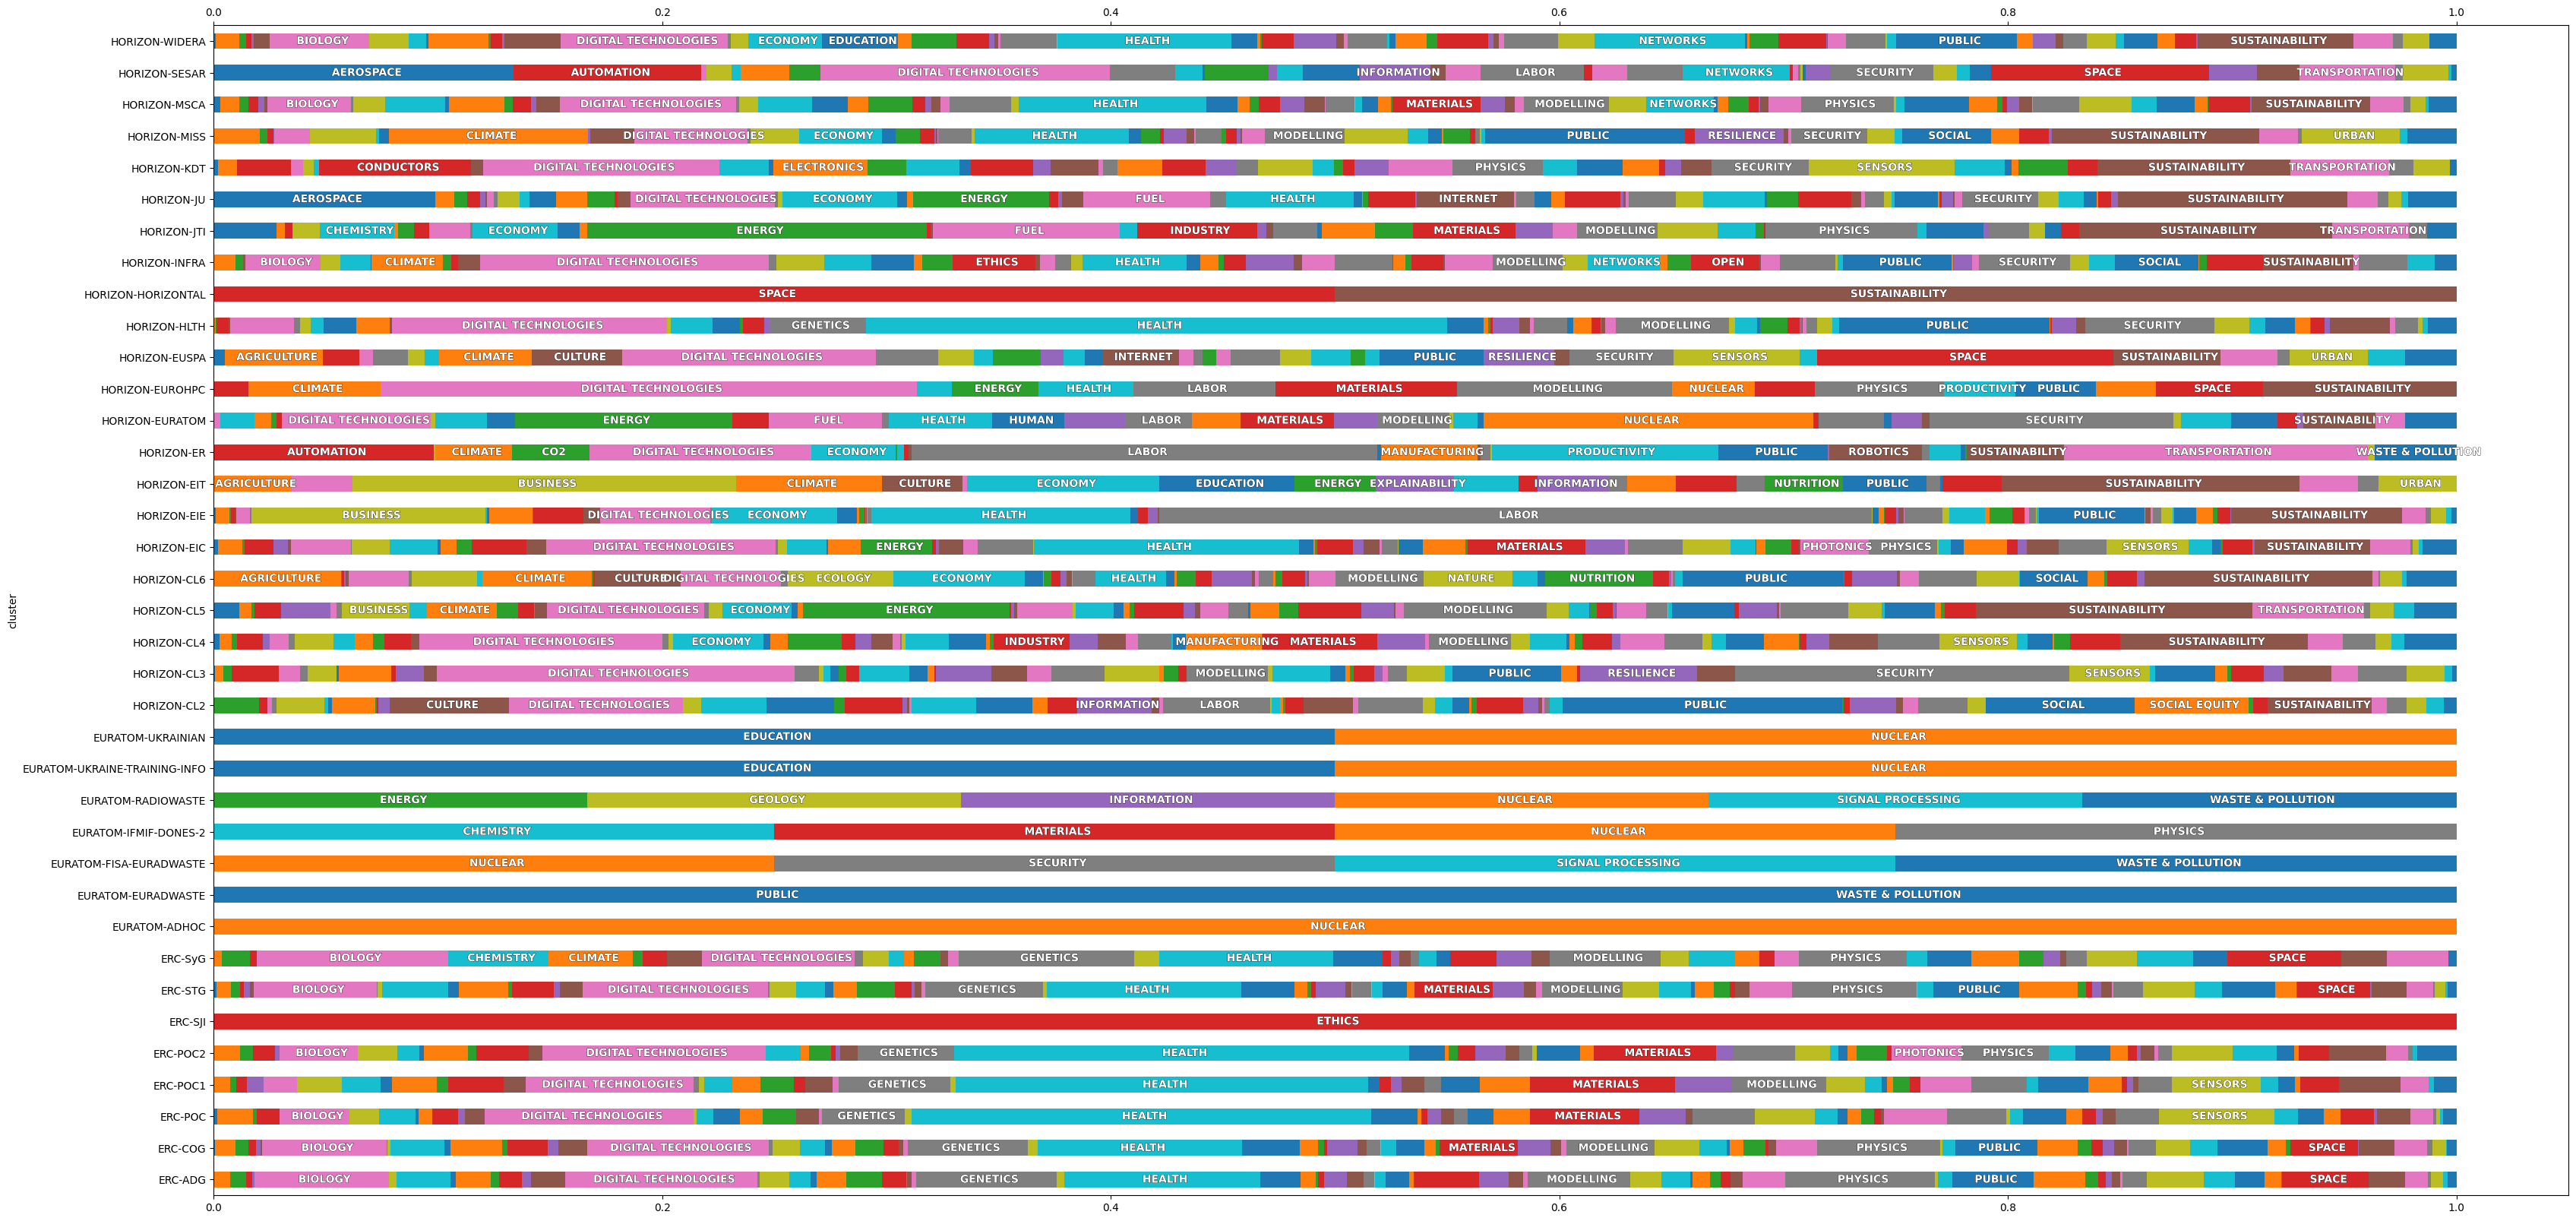

In [46]:
ecmax_per_cluster_perc = ecmax_per_cluster.div(ecmax_per_cluster.sum(axis=1), axis=0)
ax = ecmax_per_cluster_perc.plot(kind="barh", stacked=True, figsize=((40,20)), legend=None)

min_amount = 0.03
for c, category in zip(ax.containers, ecmax_per_cluster_perc.columns):  # Loop over bars and categories
    labels = [category if v.get_width() > min_amount else "" for v in c]  # Use category names as labels
    ax.bar_label(c, labels=labels, label_type='center', padding=3, color='white', fontsize=10, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
# ax.set_title("EcMaxContribution in 1e10")

In [47]:
ecmax_per_category_perc = ecmax_per_category.div(ecmax_per_category.sum(axis=1), axis=0)

Text(0.5, 1.0, 'Distribution of ecMaxContribution per category over clusters, categories from most to least funded (top to bottom)')

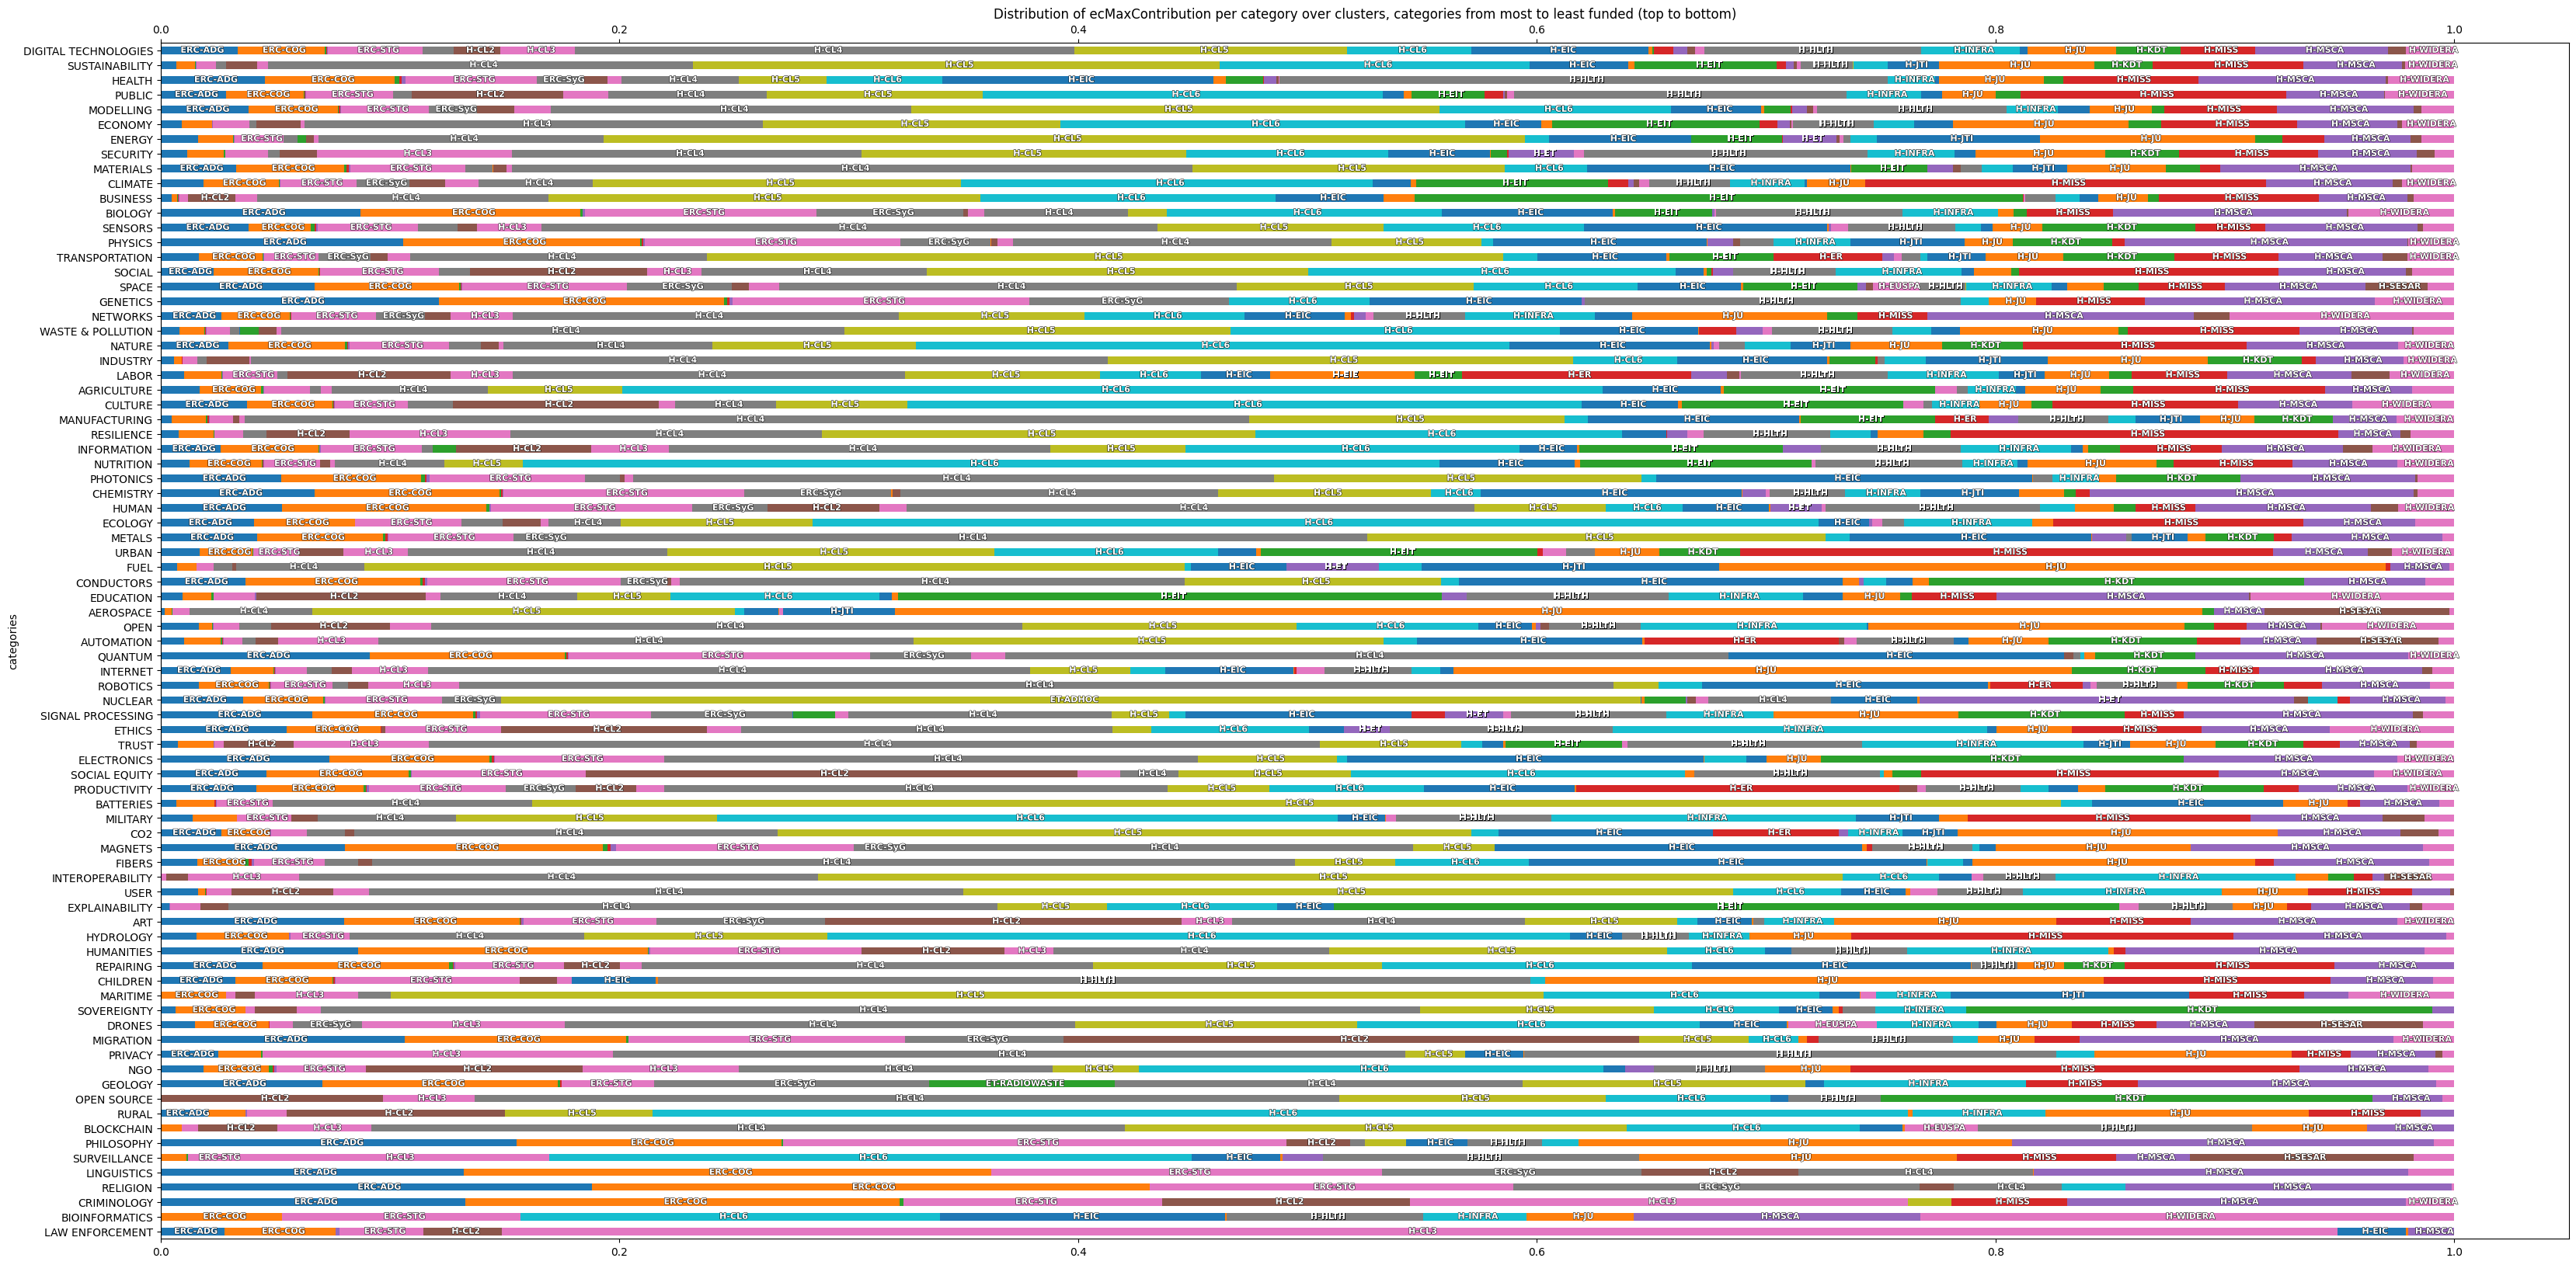

In [48]:
ax = ecmax_per_category_perc.plot(kind="barh", stacked=True, figsize=((40,20)), legend=None)

min_amount = 0.02
for c, category in zip(ax.containers, ecmax_per_category_perc.columns):  # Loop over bars and categories
    labels = [category.replace("HORIZON", "H").replace("EURATOM", "ET") if v.get_width() > min_amount else "" for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=3, color='white', fontsize=8, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.7, foreground='black')])
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.set_title("Distribution of ecMaxContribution per category over clusters, categories from most to least funded (top to bottom)")

# Co-occurences

In [49]:
def get_coocurrences_cat(cat):
    coocurrence_dict = defaultdict(int)
    
    df_cat = df[df["categories"].apply(lambda x: cat in x if isinstance(x, list) else False)]
    def update_coocurrence_dict(row):
        for other_cat in row.categories:
            if other_cat == cat:
                continue
            coocurrence_dict[other_cat] += row.ecMaxContribution
    df_cat.apply(lambda row: update_coocurrence_dict(row), axis=1)
    
    coocurrences = sorted(coocurrence_dict.items(), key=lambda x: x[1], reverse=True)
    x = [x[0] for x in coocurrences]
    y = [x[1] for x in coocurrences]
    top_n = 15
    plt.bar(x[:top_n], y[:top_n])
    plt.ylabel(f"ecMaxContribution co-occuring with \"{cat}\"")
    plt.margins(x=0)
    plt.title("")


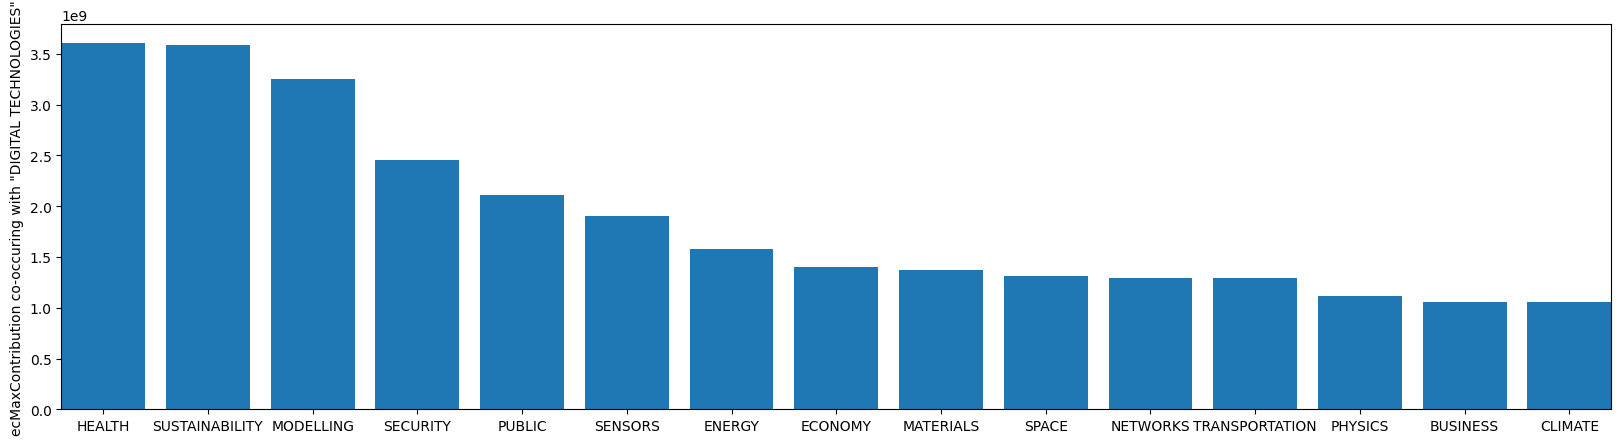

In [50]:
get_coocurrences_cat("DIGITAL TECHNOLOGIES")

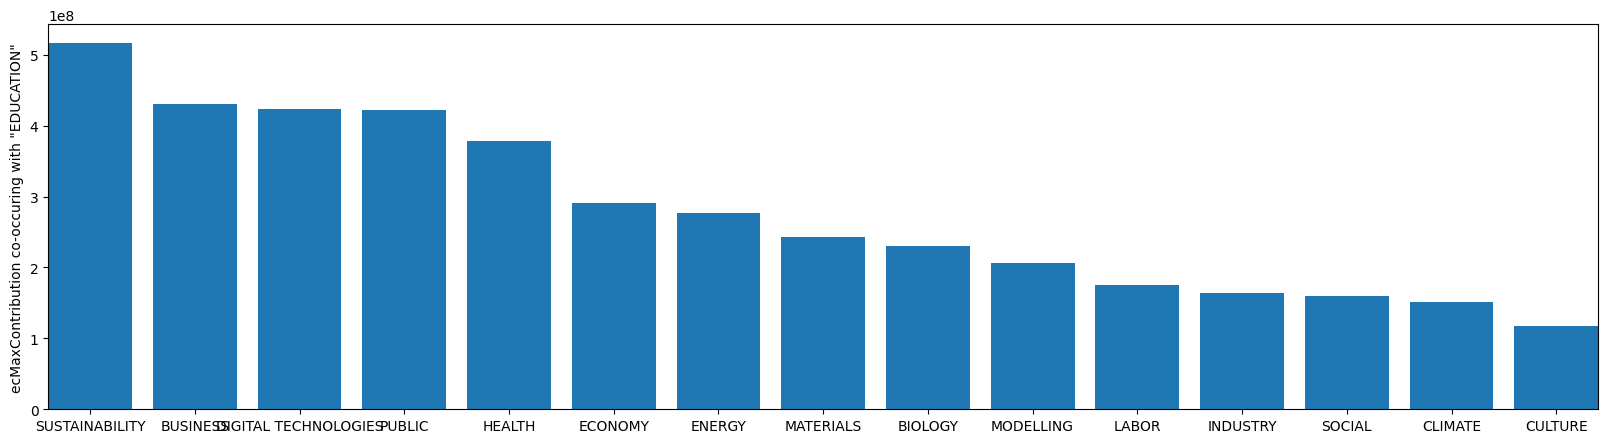

In [51]:
get_coocurrences_cat("EDUCATION")

In [52]:
# RELATIVE TO FUNDING OF OTHER CATEGORY
def get_coocurrences_cat_relative(cat):
    coocurrence_dict = defaultdict(int)
    
    df_cat = df[df["categories"].apply(lambda x: cat in x if isinstance(x, list) else False)]
    def update_coocurrence_dict(row):
        for other_cat in row.categories:
            if other_cat == cat:
                continue
            coocurrence_dict[other_cat] += row.ecMaxContribution
    df_cat.apply(lambda row: update_coocurrence_dict(row), axis=1)
    
    for other_cat in coocurrence_dict:
        coocurrence_dict[other_cat] /= categories_project_ecmax[other_cat]
    
    coocurrences = sorted(coocurrence_dict.items(), key=lambda x: x[1], reverse=True)
    x = [x[0] for x in coocurrences]
    y = [x[1] for x in coocurrences]
    top_n = 15
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.bar(x[:top_n], y[:top_n])
    xticklabels = ["\n".join(l.get_text().split()) for l in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(f"ecMaxContribution co-occuring with \"{cat}\"/\necMaxContribution of category")
    ax.margins(x=0)
    ax.set_title("")


/tmp/ipykernel_29970/4128878117.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


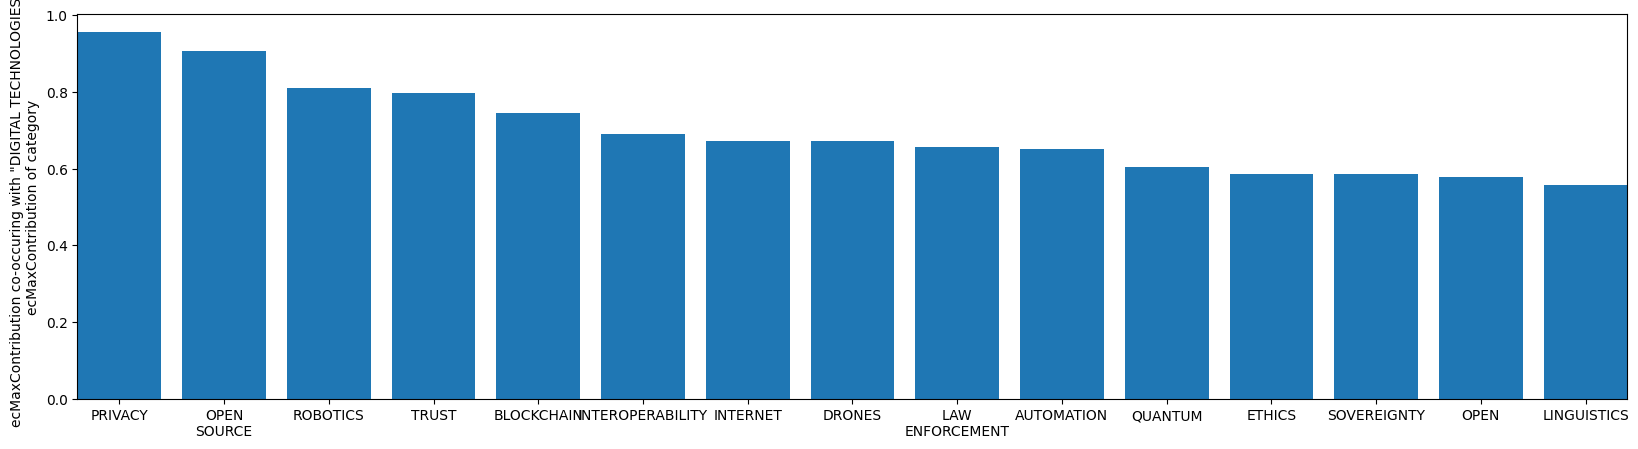

In [53]:
get_coocurrences_cat_relative("DIGITAL TECHNOLOGIES")

/tmp/ipykernel_29970/4128878117.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


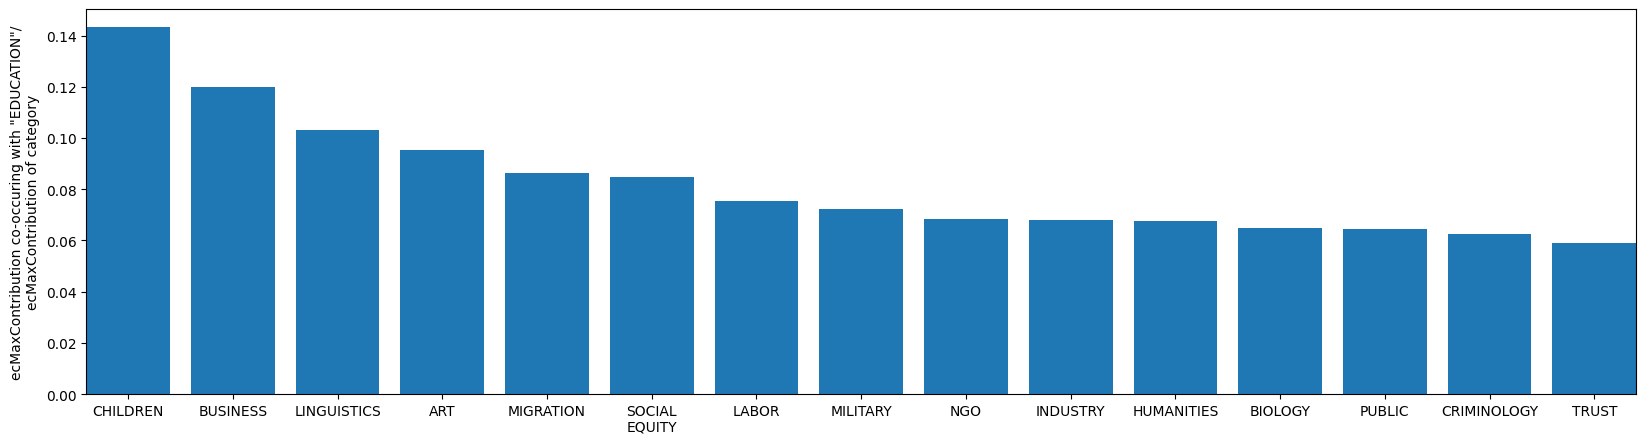

In [54]:
get_coocurrences_cat_relative("EDUCATION")

In [55]:
# RELATIVE TO FUNDING OF OTHER CATEGORY
def get_coocurrences_subcat_relative(cat, supercat_exclude):
    coocurrence_dict = defaultdict(int)
    
    df_cat = df[df["subcategories"].apply(lambda x: cat in np.array(x)[:, 1] if isinstance(x, list) else False)]
    def update_coocurrence_dict(row):
        for other_cat in row.categories:
            if other_cat == cat or other_cat == supercat_exclude:
                continue
            coocurrence_dict[other_cat] += row.ecMaxContribution
        
        for _, other_cat in row.subcategories:
            if other_cat == cat or other_cat == supercat_exclude:
                continue
            coocurrence_dict[other_cat.upper()] += row.ecMaxContribution
    df_cat.apply(lambda row: update_coocurrence_dict(row), axis=1)
    
    for other_cat in coocurrence_dict:
        coocurrence_dict[other_cat.upper()] /= all_project_ecmax[other_cat.upper()]
    
    coocurrences = sorted(coocurrence_dict.items(), key=lambda x: x[1], reverse=True)
    x = [x[0] for x in coocurrences]
    y = [x[1] for x in coocurrences]
    top_n = 15
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.bar(x[:top_n], y[:top_n])
    xticklabels = ["\n".join(l.get_text().split()) for l in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(f"ecMaxContribution co-occuring with \"{cat}\"/\necMaxContribution of category")
    ax.margins(x=0)
    ax.set_title("")


/tmp/ipykernel_29970/4047770663.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


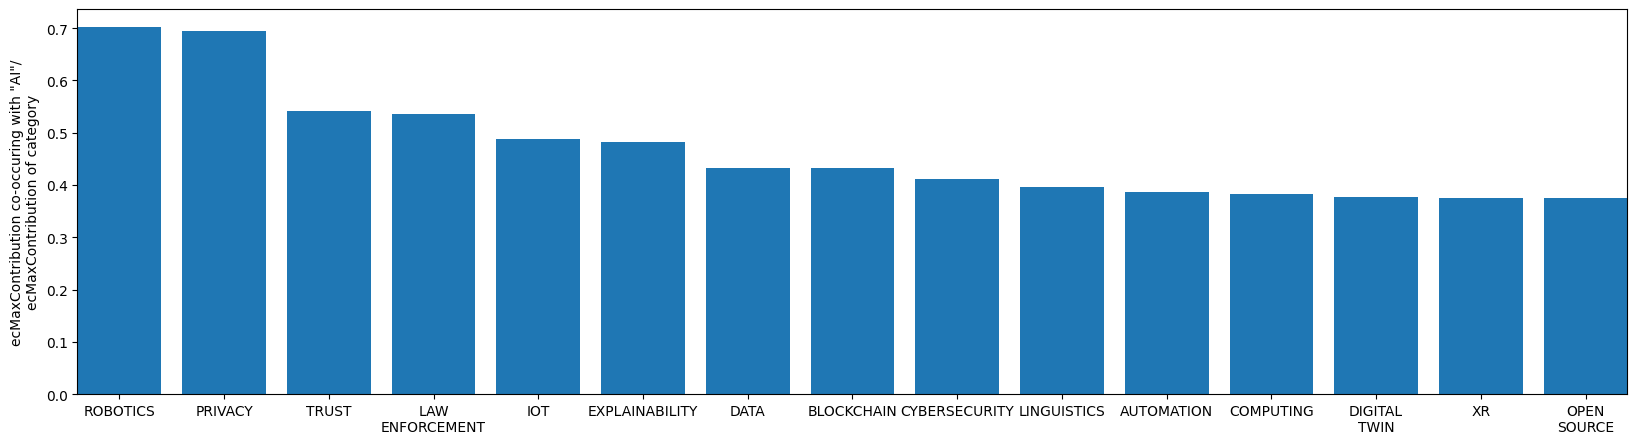

In [56]:
get_coocurrences_subcat_relative("AI", "DIGITAL TECHNOLOGIES")

/tmp/ipykernel_29970/4128878117.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


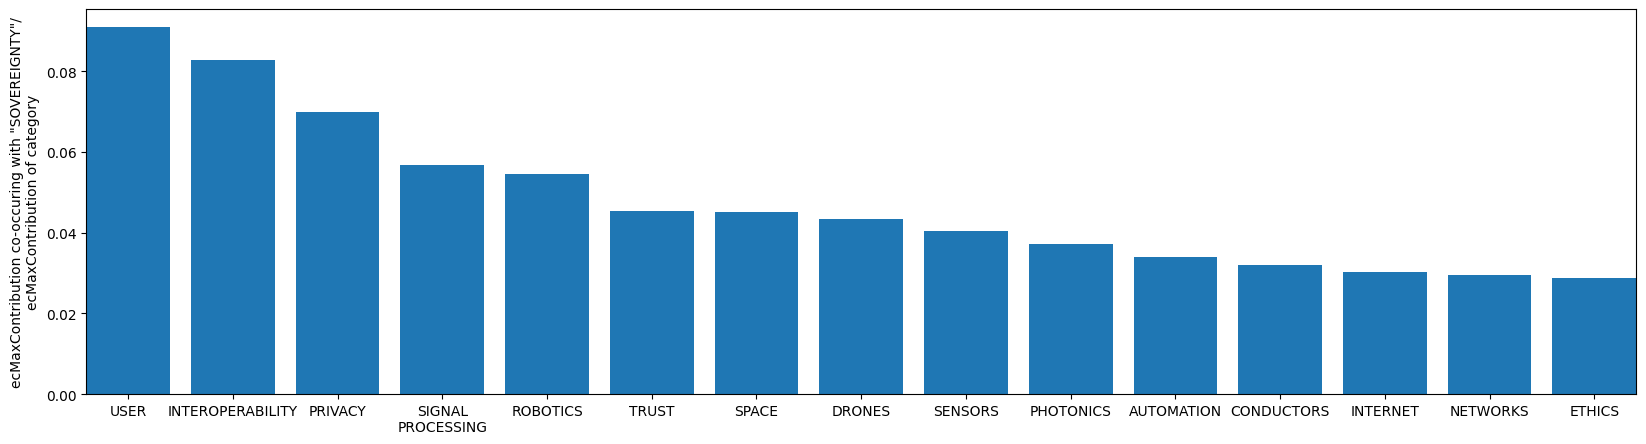

In [57]:
get_coocurrences_cat_relative("SOVEREIGNTY")

/tmp/ipykernel_29970/4128878117.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


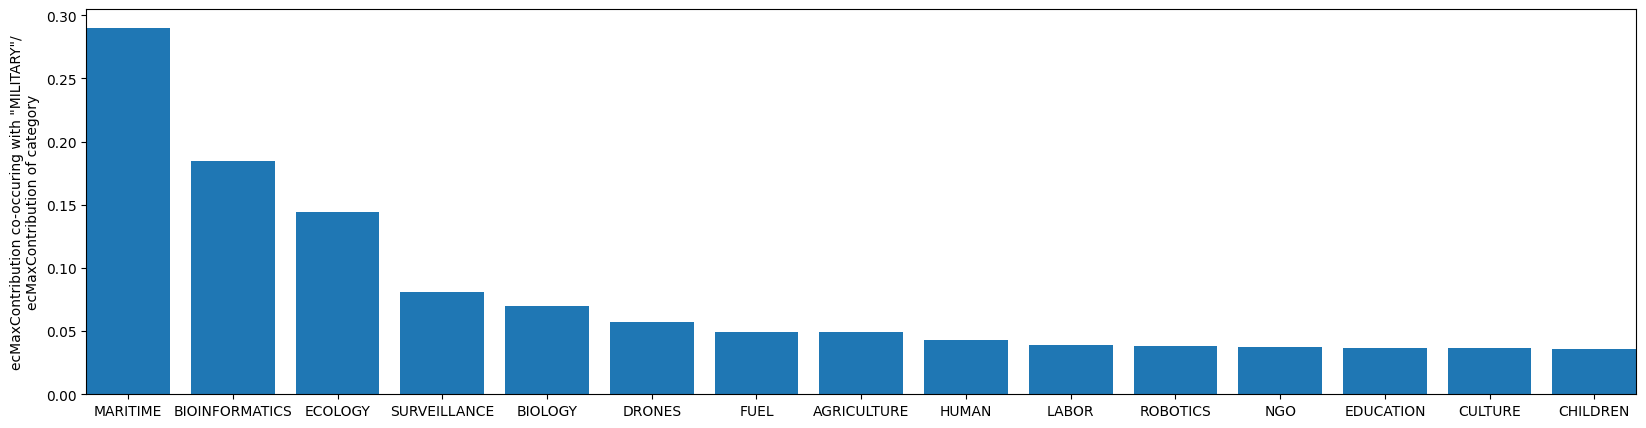

In [58]:
get_coocurrences_cat_relative("MILITARY")

In [59]:
def get_all_coocurrences():
    coocurrence_dict = defaultdict(int)
    def update_coocurrence_dict(row):
        if row.categories is None:
            return
        passed = []
        for cat in row.categories:
            passed.append(cat)
            for other_cat in row.categories:
                if other_cat in passed:
                    continue
                tup = tuple(sorted((cat, other_cat)))
                coocurrence_dict[tup] += row.ecMaxContribution
    df.apply(lambda row: update_coocurrence_dict(row), axis=1)

    return coocurrence_dict
    
all_coocurrences = get_all_coocurrences()

In [60]:
all_coocurrences_sorted = sorted(all_coocurrences.items(), key=lambda x: x[1], reverse=True)

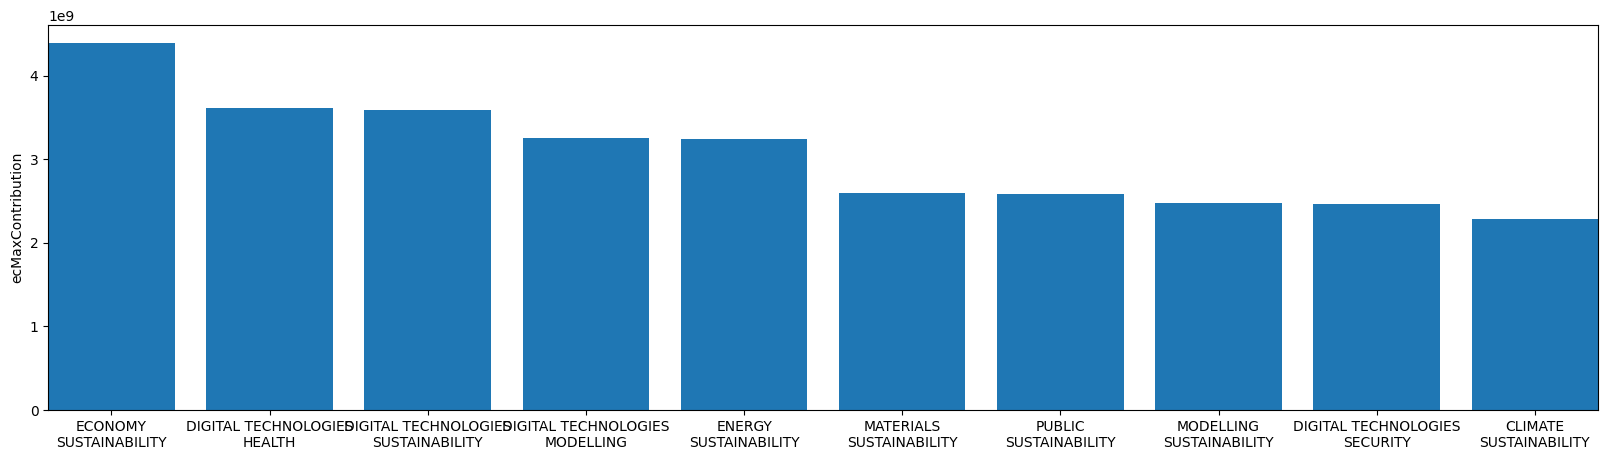

In [61]:
x = [f"{t[0]}\n{t[1]}" for t, v in all_coocurrences_sorted]
y = [v for t, v in all_coocurrences_sorted]
n = 10
plt.bar(x[:n], y[:n])
plt.ylabel("ecMaxContribution")
plt.margins(x=0)

In [62]:
rel_coocurrences = {}
for (c1, c2), val in all_coocurrences.items():
    rel_coocurrences[(c1, c2)] = val/(categories_project_ecmax[c1] + categories_project_ecmax[c2])
rel_coocurrences_sorted = sorted(rel_coocurrences.items(), key=lambda x: x[1], reverse=True)

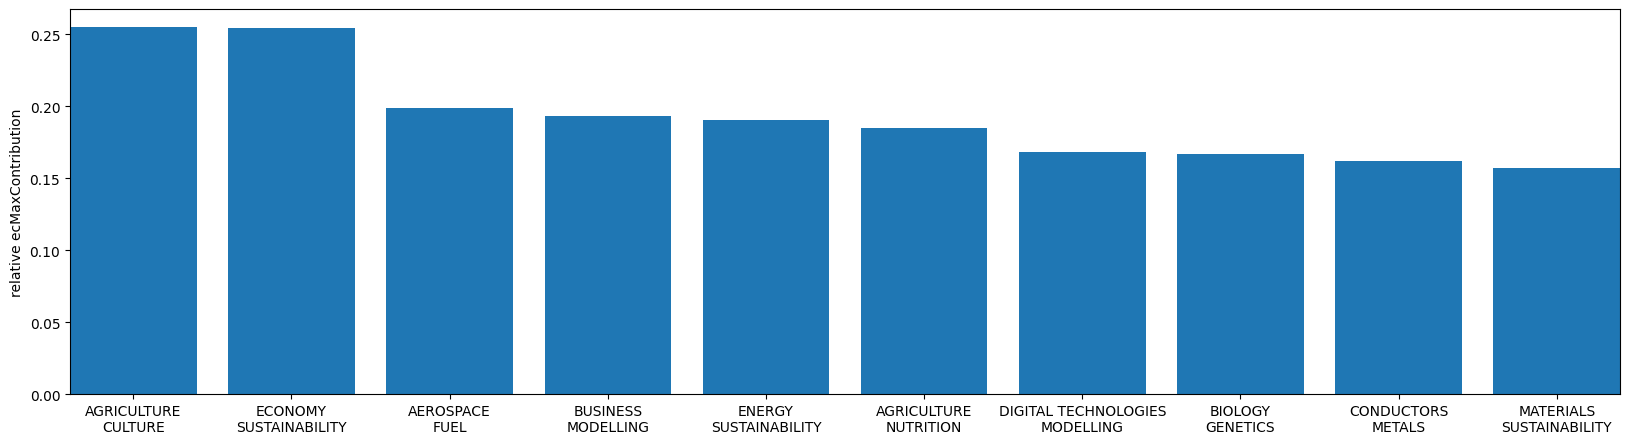

In [63]:
plt.rcParams["figure.figsize"] = (20,5)
x = [f"{t[0]}\n{t[1]}" for t, v in rel_coocurrences_sorted]
y = [v for t, v in rel_coocurrences_sorted]
n = 10
plt.bar(x[:n], y[:n])
plt.ylabel("relative ecMaxContribution")
plt.margins(x=0)

Note to the above: agriculture and "culture" might refer to culture in the biological sense.

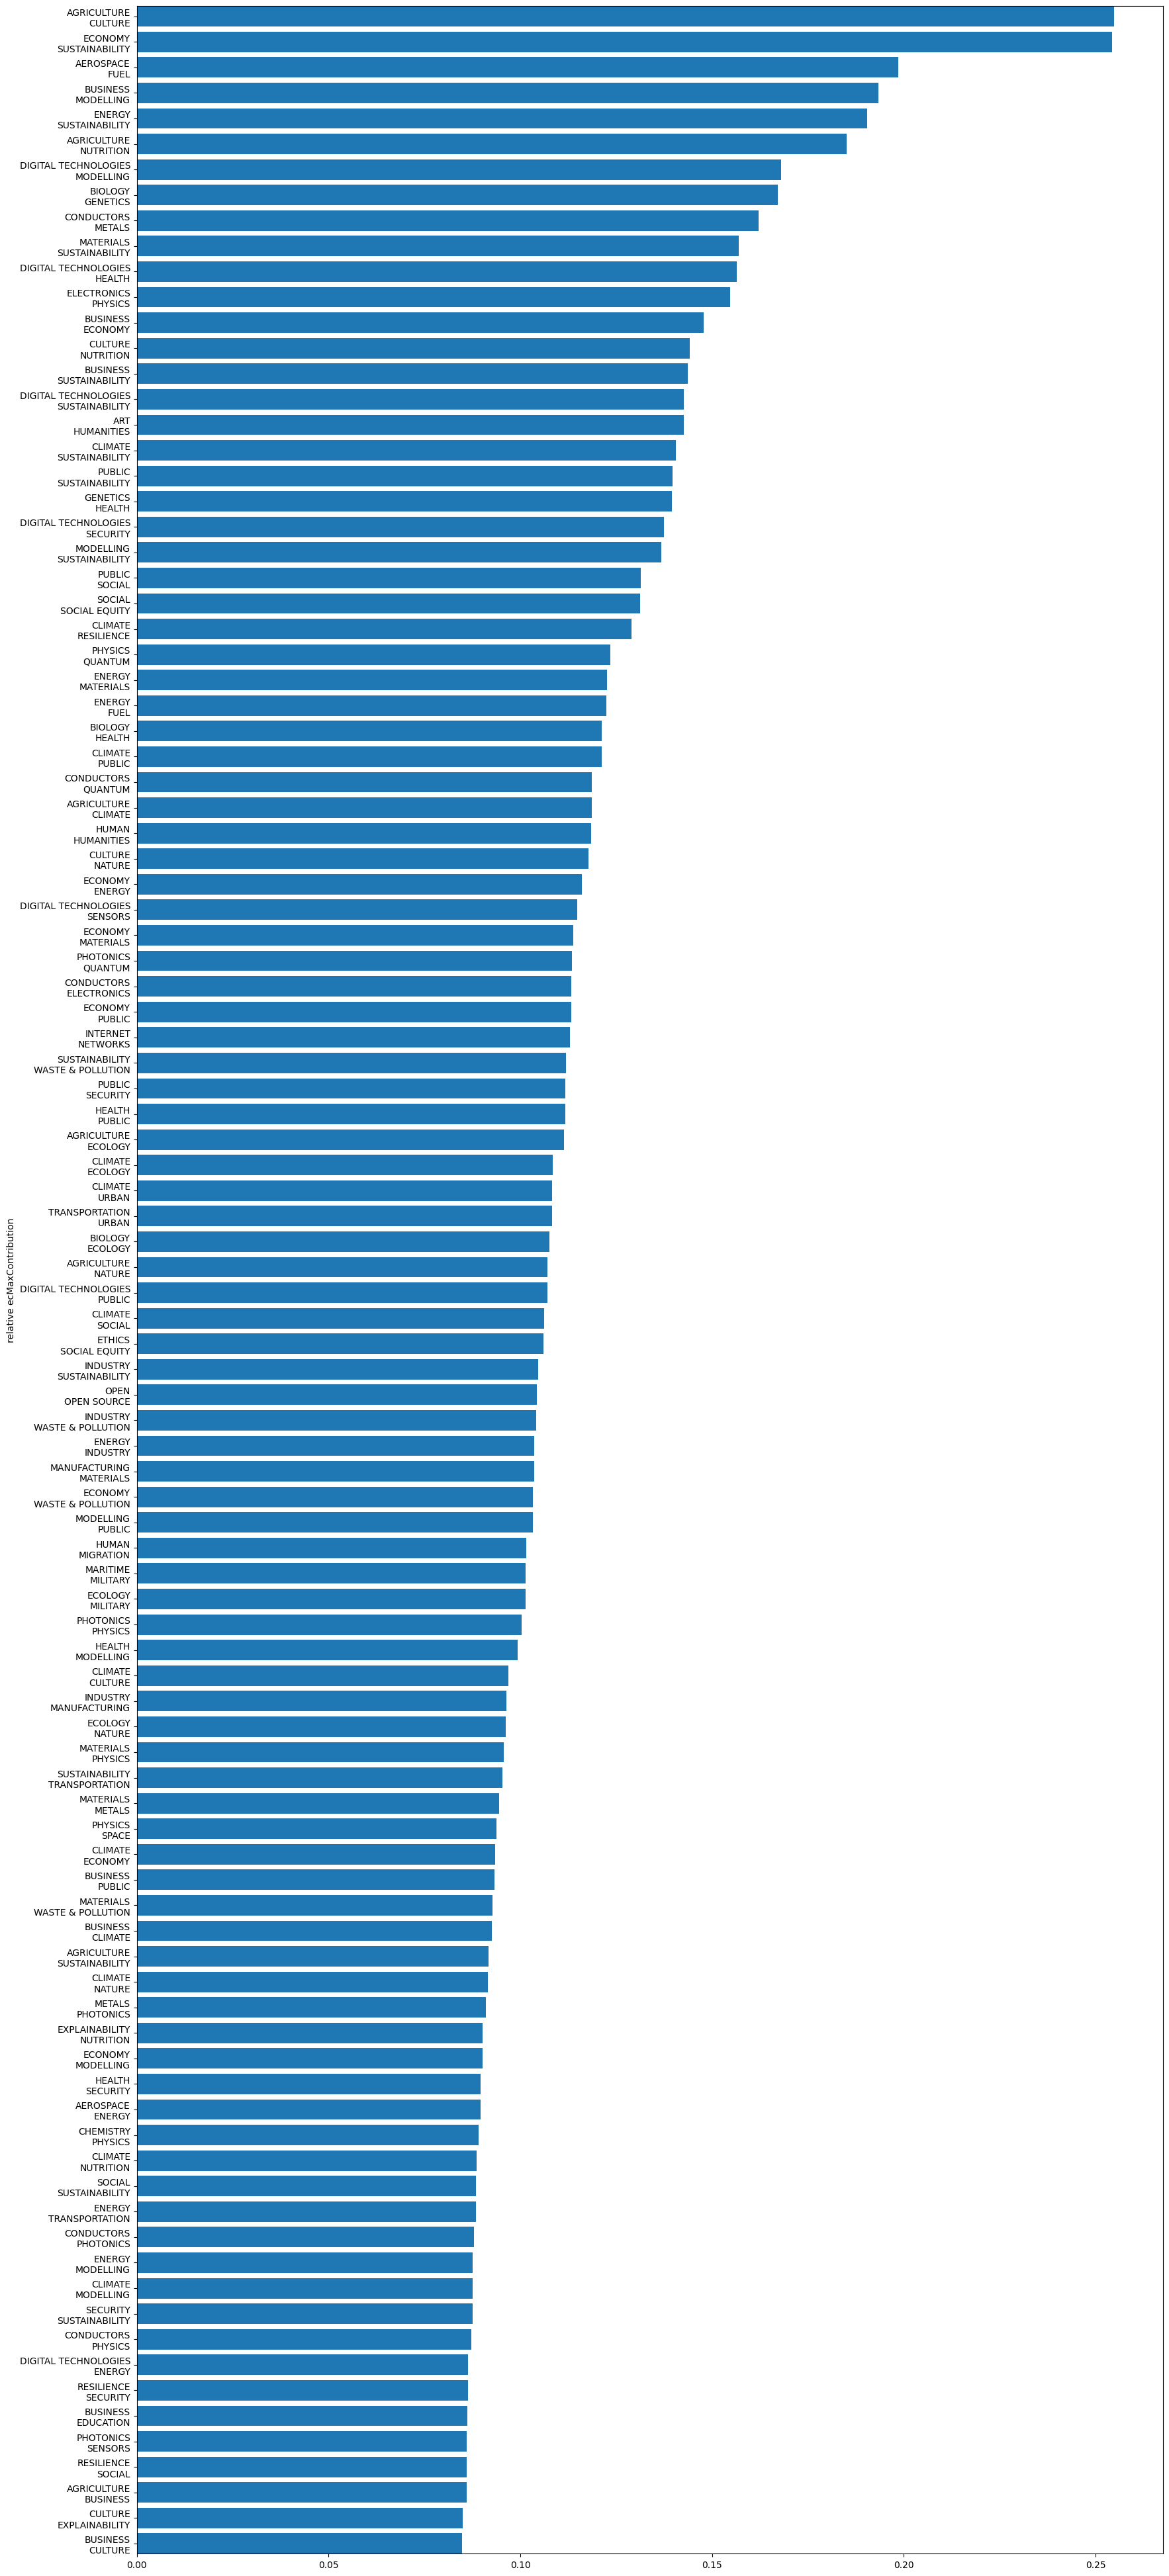

In [64]:
plt.rcParams["figure.figsize"] = (20,50)
rel_coocurrences_sorted_desc = sorted(rel_coocurrences.items(), key=lambda x: x[1])

n=100
x = [f"{t[0]}\n{t[1]}" for t, v in rel_coocurrences_sorted_desc[-n:]]
y = [v for t, v in rel_coocurrences_sorted_desc[-n:]]
plt.barh(x, y)
plt.ylabel("relative ecMaxContribution")
plt.margins(y=0)

In [65]:
# RELATIVE TO FUNDING OF OTHER CATEGORY
def get_coocurrences_subcat_perc_projects(cat, supercat_exclude):
    coocurrence_dict = defaultdict(int)
    df_cat = df[df["subcategories"].apply(lambda x: cat in np.array(x)[:, 1] if isinstance(x, list) else False)]
    def update_coocurrence_dict(row):
        for other_cat in row.categories:
            if other_cat == cat or other_cat == supercat_exclude:
                continue
            coocurrence_dict[other_cat] += 1
        
        for _, other_cat in row.subcategories:
            if other_cat == cat or other_cat == supercat_exclude:
                continue
            coocurrence_dict[other_cat.upper()] += 1
    df_cat.apply(lambda row: update_coocurrence_dict(row), axis=1)
    
    coocurrences = sorted(coocurrence_dict.items(), key=lambda x: x[1], reverse=True)
    for c, count in coocurrences:
        print(f"{c}: {count/all_project_counts[cat]*100:.2f}%")

In [66]:
get_coocurrences_subcat_perc_projects("AI", "DIGITAL TECHNOLOGIES")

HEALTH: 21.59%
COMPUTING: 20.82%
DATA: 20.47%
MODELLING: 18.04%
SUSTAINABILITY: 12.95%
SENSORS: 11.57%
SECURITY: 11.33%
NETWORKS: 9.06%
ROBOTICS: 8.13%
PHYSICS: 7.56%
BIOLOGY: 7.40%
PUBLIC: 7.32%
MATERIALS: 6.71%
SPACE: 6.55%
ECONOMY: 6.13%
ENERGY: 5.86%
TRANSPORTATION: 5.78%
CLIMATE: 5.63%
HUMAN: 5.51%
INFORMATION: 5.51%
AUTOMATION: 5.17%
GENETICS: 5.13%
SOCIAL: 4.36%
LABOR: 4.32%
MANUFACTURING: 4.24%
INTERNET: 4.16%
IOT: 3.93%
TRUST: 3.89%
PHOTONICS: 3.82%
RESILIENCE: 3.78%
CYBERSECURITY: 3.70%
SIGNAL PROCESSING: 3.66%
DIGITAL TWIN: 3.66%
NATURE: 3.62%
BUSINESS: 3.59%
CHEMISTRY: 3.51%
INDUSTRY: 3.05%
WASTE & POLLUTION: 2.97%
AGRICULTURE: 2.78%
EXPLAINABILITY: 2.66%
CULTURE: 2.62%
METALS: 2.58%
OPEN: 2.58%
ECOLOGY: 2.54%
QUANTUM: 2.51%
NUTRITION: 2.39%
XR: 2.35%
CONDUCTORS: 2.16%
PRODUCTIVITY: 2.16%
ETHICS: 2.12%
MAGNETS: 1.93%
URBAN: 1.93%
ELECTRONICS: 1.89%
ICT: 1.89%
EDUCATION: 1.66%
USER: 1.66%
PRIVACY: 1.50%
DRONES: 1.50%
AEROSPACE: 1.31%
INTEROPERABILITY: 1.16%
HUMANITIES: 1.16%

In [67]:
plt.rcParams["figure.figsize"] = (20,5)

# Subcategories

In [68]:
with open("../categorization/subcategories.json", "r") as f:
    subcat_dict = json.load(f)

In [69]:
subcat_dict

{'MATERIALS': {'raw materials': ['secondary raw materials',
   'cricial raw materals',
   'raw materials'],
  'bio-materials': ['biocomposites', 'biomaterials'],
  'polymers': ['polymers', 'polymer sciences']},
 'DIGITAL TECHNOLOGIES': {'AI': ['llm',
   'reinforcement learning',
   'computational intelligence',
   'ml',
   'natural language processing',
   'ai',
   'human-in-the-loop',
   'nlp',
   'machine learning',
   'neural network',
   'deep learning',
   'artificial neural networks',
   'computer vision',
   'deep-learning',
   'artificial intelligence',
   'federated learning',
   'hybrid ai',
   'swarm learning',
   'large language model',
   'neural networks',
   'large language models',
   'deep neural networks',
   'generative ai'],
  'XR': ['vr',
   'extended reality',
   'xr',
   'augmented reality',
   'mixed reality',
   'ar',
   'virtual reality'],
  'COMPUTING': ['cloud',
   'cloud computing',
   'computer',
   'supercomputers',
   'operating systems',
   'computers',

In [70]:
def get_subcategories(supercat, other = True):
    supercat_df = df[df["categories"].apply(lambda x: supercat in x if isinstance(x, list) else False)]
    subcats = defaultdict(int)

    def fill_subcats(row):
        if row.subcategories is None:
            if other:
                subcats["other"] += row.ecMaxContribution
            return
        
        for (superc, subc) in row.subcategories:
            if superc == supercat:
                subcats[subc] += row.ecMaxContribution

    supercat_df.apply(lambda row: fill_subcats(row), axis=1)
    
    plt.bar(subcats.keys(), subcats.values(), zorder=3)
    plt.margins(x=0)
    plt.ylabel("ecMaxContribution")
    plt.grid(axis="y", zorder=0)
    plt.title(f"subcategories of category \"{supercat}\"")


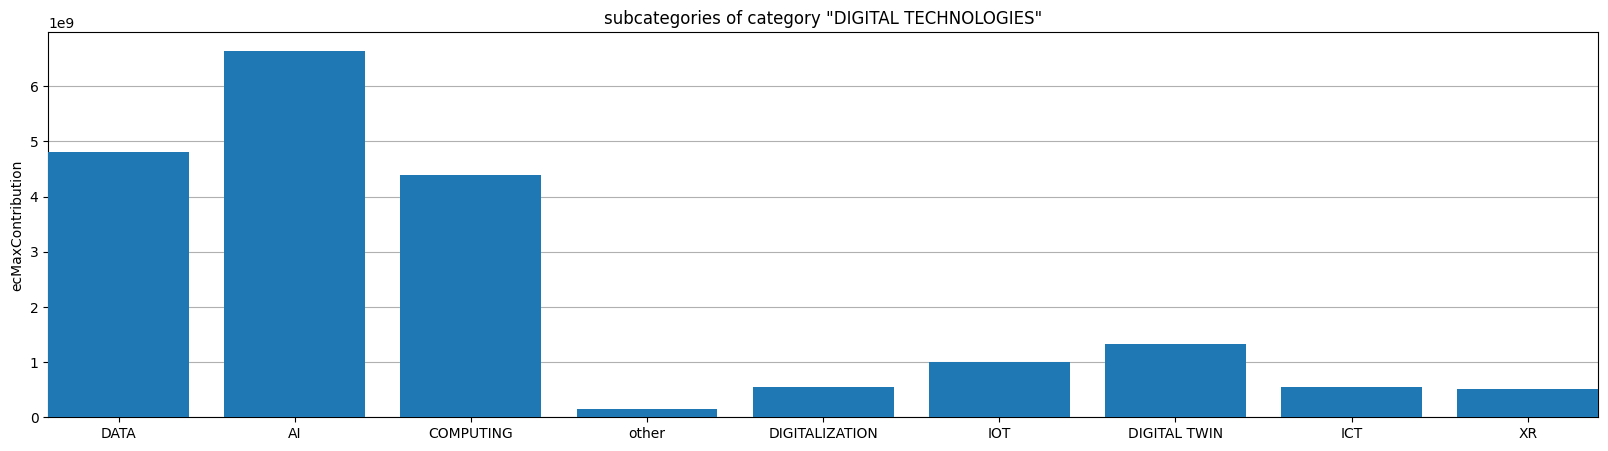

In [71]:
get_subcategories("DIGITAL TECHNOLOGIES")

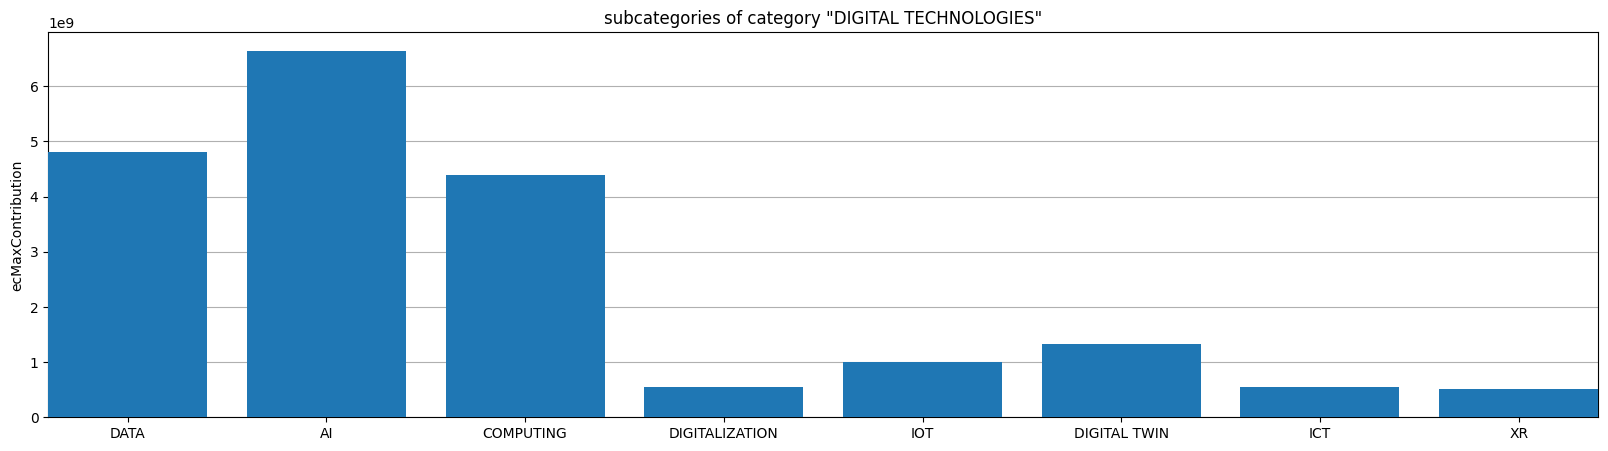

In [72]:
get_subcategories("DIGITAL TECHNOLOGIES", other=False)

In [73]:
def get_subsubcategories(supercat, other = True):
    supercat_df = df[df["subcategories"].apply(lambda x: supercat in np.array(x)[:, 1] if isinstance(x, list) else False)]
    subcats = defaultdict(int)

    def fill_subcats(row):
        if row.subsubcategories is None or len(row.subsubcategories) == 0:
            if other:
                subcats["other"] += row.ecMaxContribution
            return
        
        for (superc, subc) in row.subsubcategories:
            if superc == supercat:
                subcats[subc] += row.ecMaxContribution

    supercat_df.apply(lambda row: fill_subcats(row), axis=1)
    
    plt.bar(subcats.keys(), subcats.values(), zorder=3)
    plt.margins(x=0)
    plt.ylabel("ecMaxContribution")
    plt.grid(axis="y", zorder=0)
    plt.title(f"subsubcategories of subcategory \"{supercat}\"")


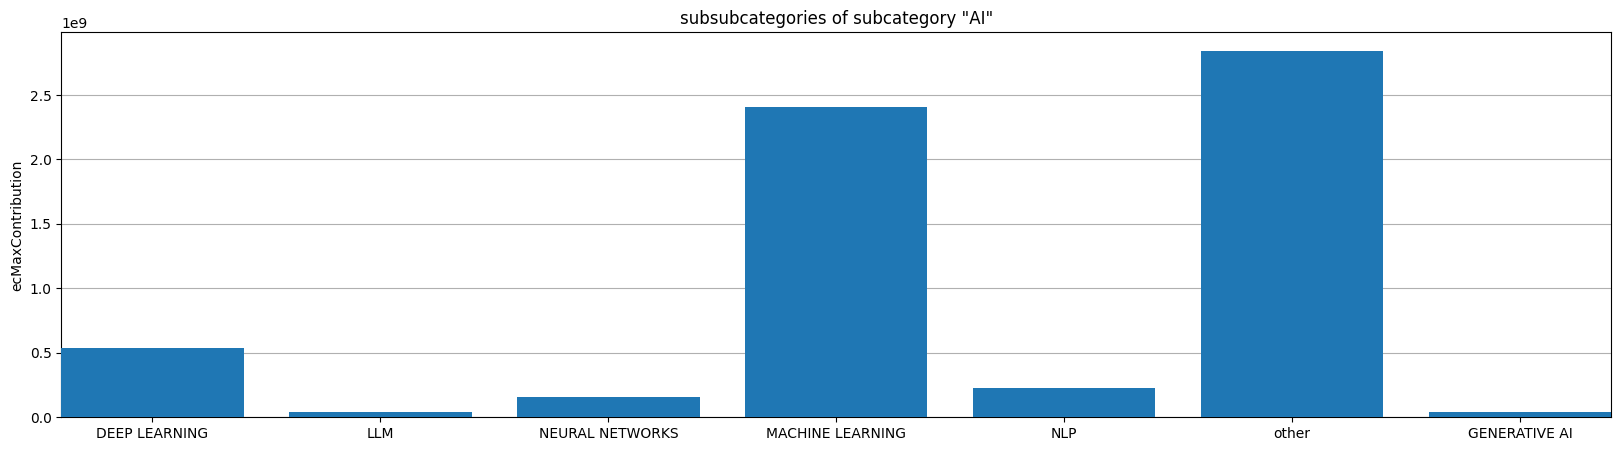

In [74]:
get_subsubcategories("AI")


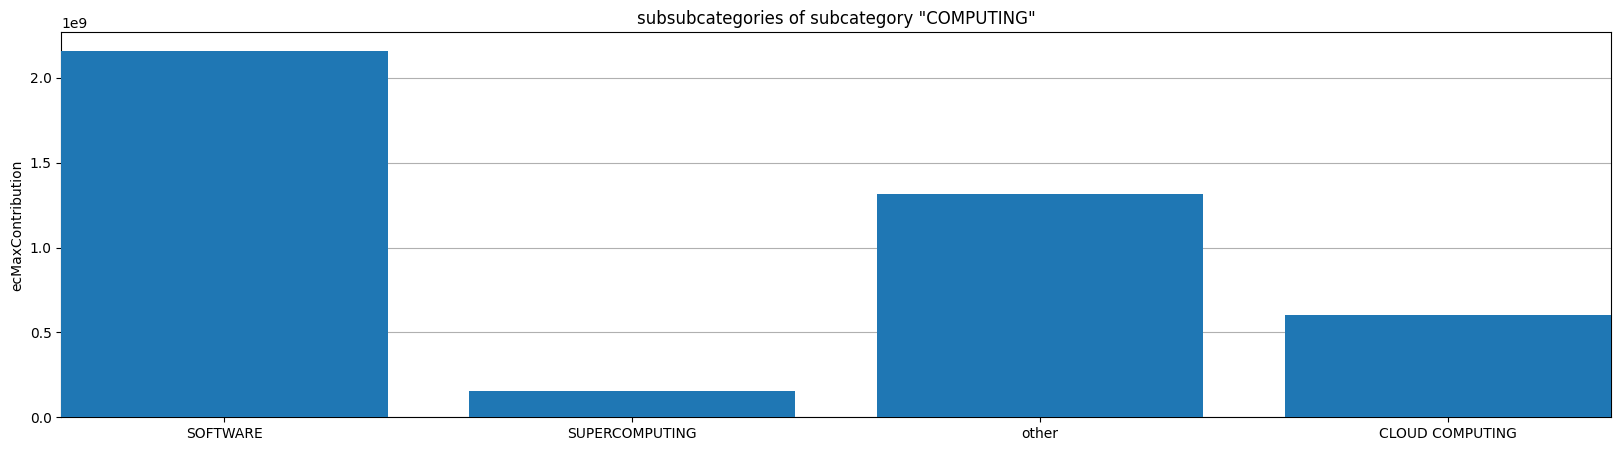

In [75]:
get_subsubcategories("COMPUTING", other=True)


## Fraction of cluster - category

In [76]:
def has_subcat(subcats, subcat):
    if subcats is None:
        return False

    return subcat in (np.array(subcats)[:, 1])

df["has_AI"] = df.apply(lambda row: has_subcat(row.subcategories, "AI"), axis=1)

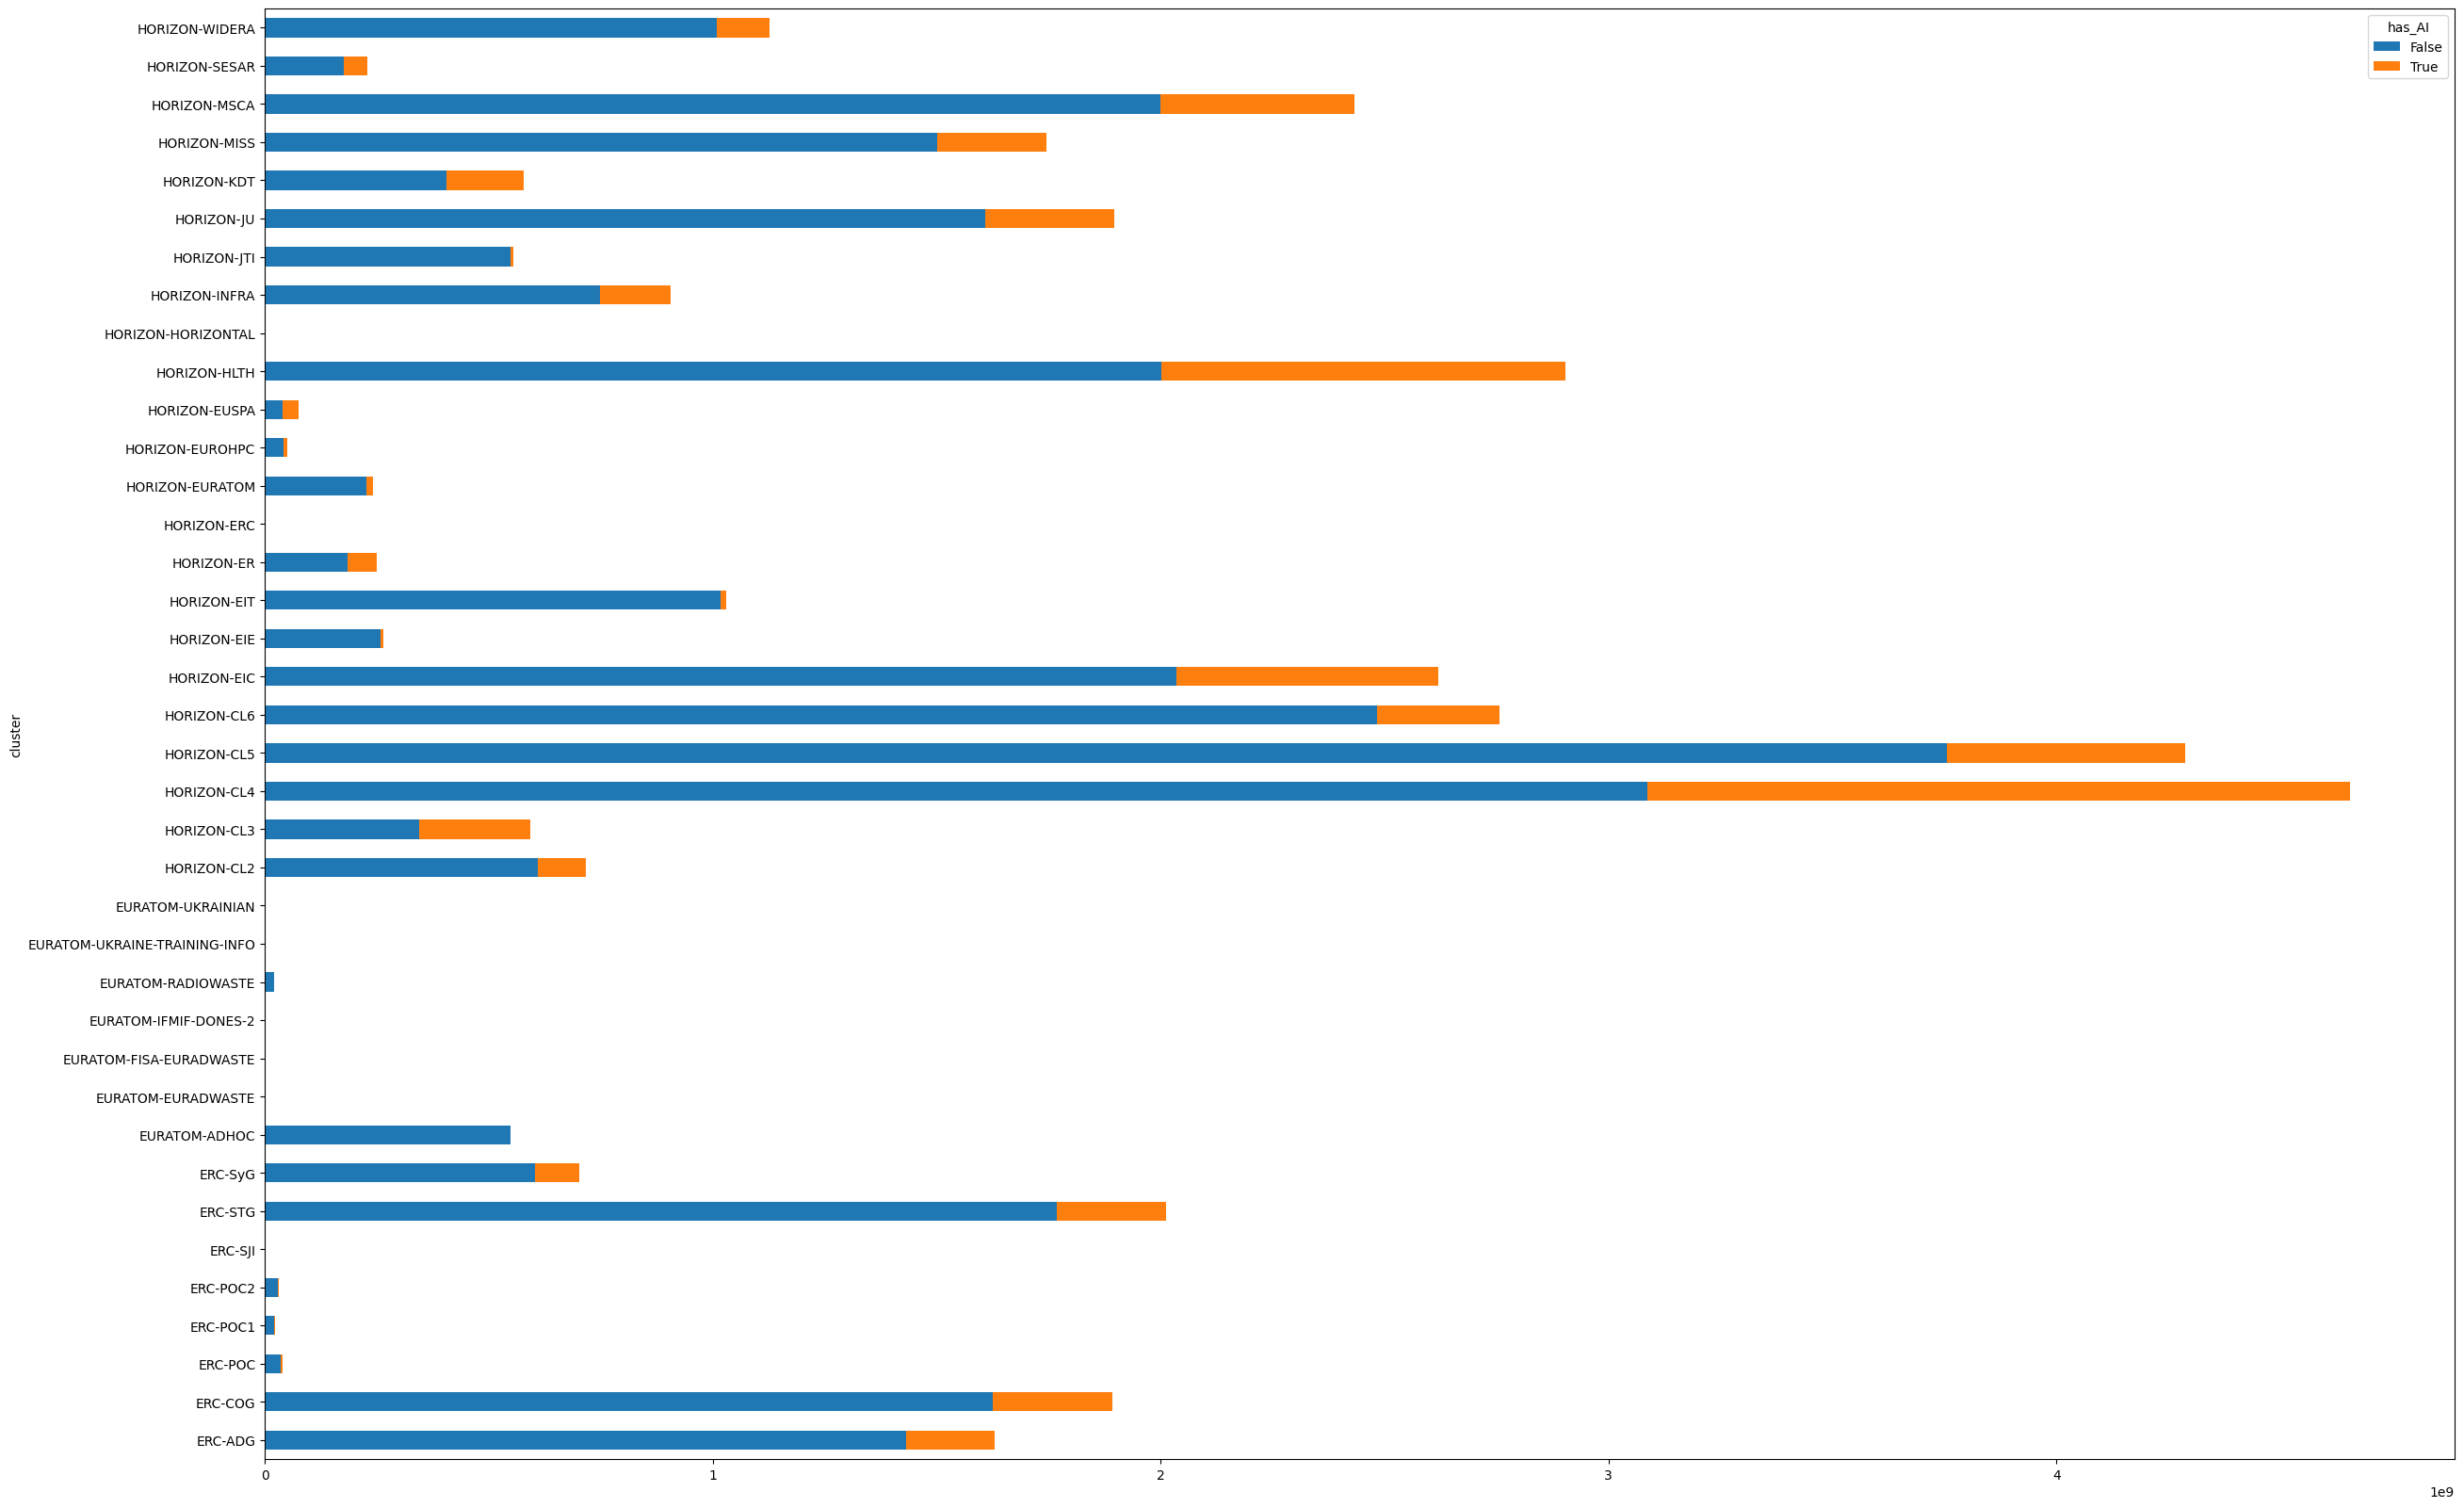

In [77]:
has_AI_per_cluster = df.groupby(["cluster", "has_AI"])["ecMaxContribution"].sum().unstack()
ax = has_AI_per_cluster.plot(kind="barh", stacked=True, figsize=((30,20)))

In [78]:
df_exploded = df.explode("categories").reset_index()
df_exploded = df_exploded.groupby(["categories", "cluster"]).agg(
    num_projects=("id", "count"),
    ecMaxContribution=("ecMaxContribution", "sum")
).reset_index()

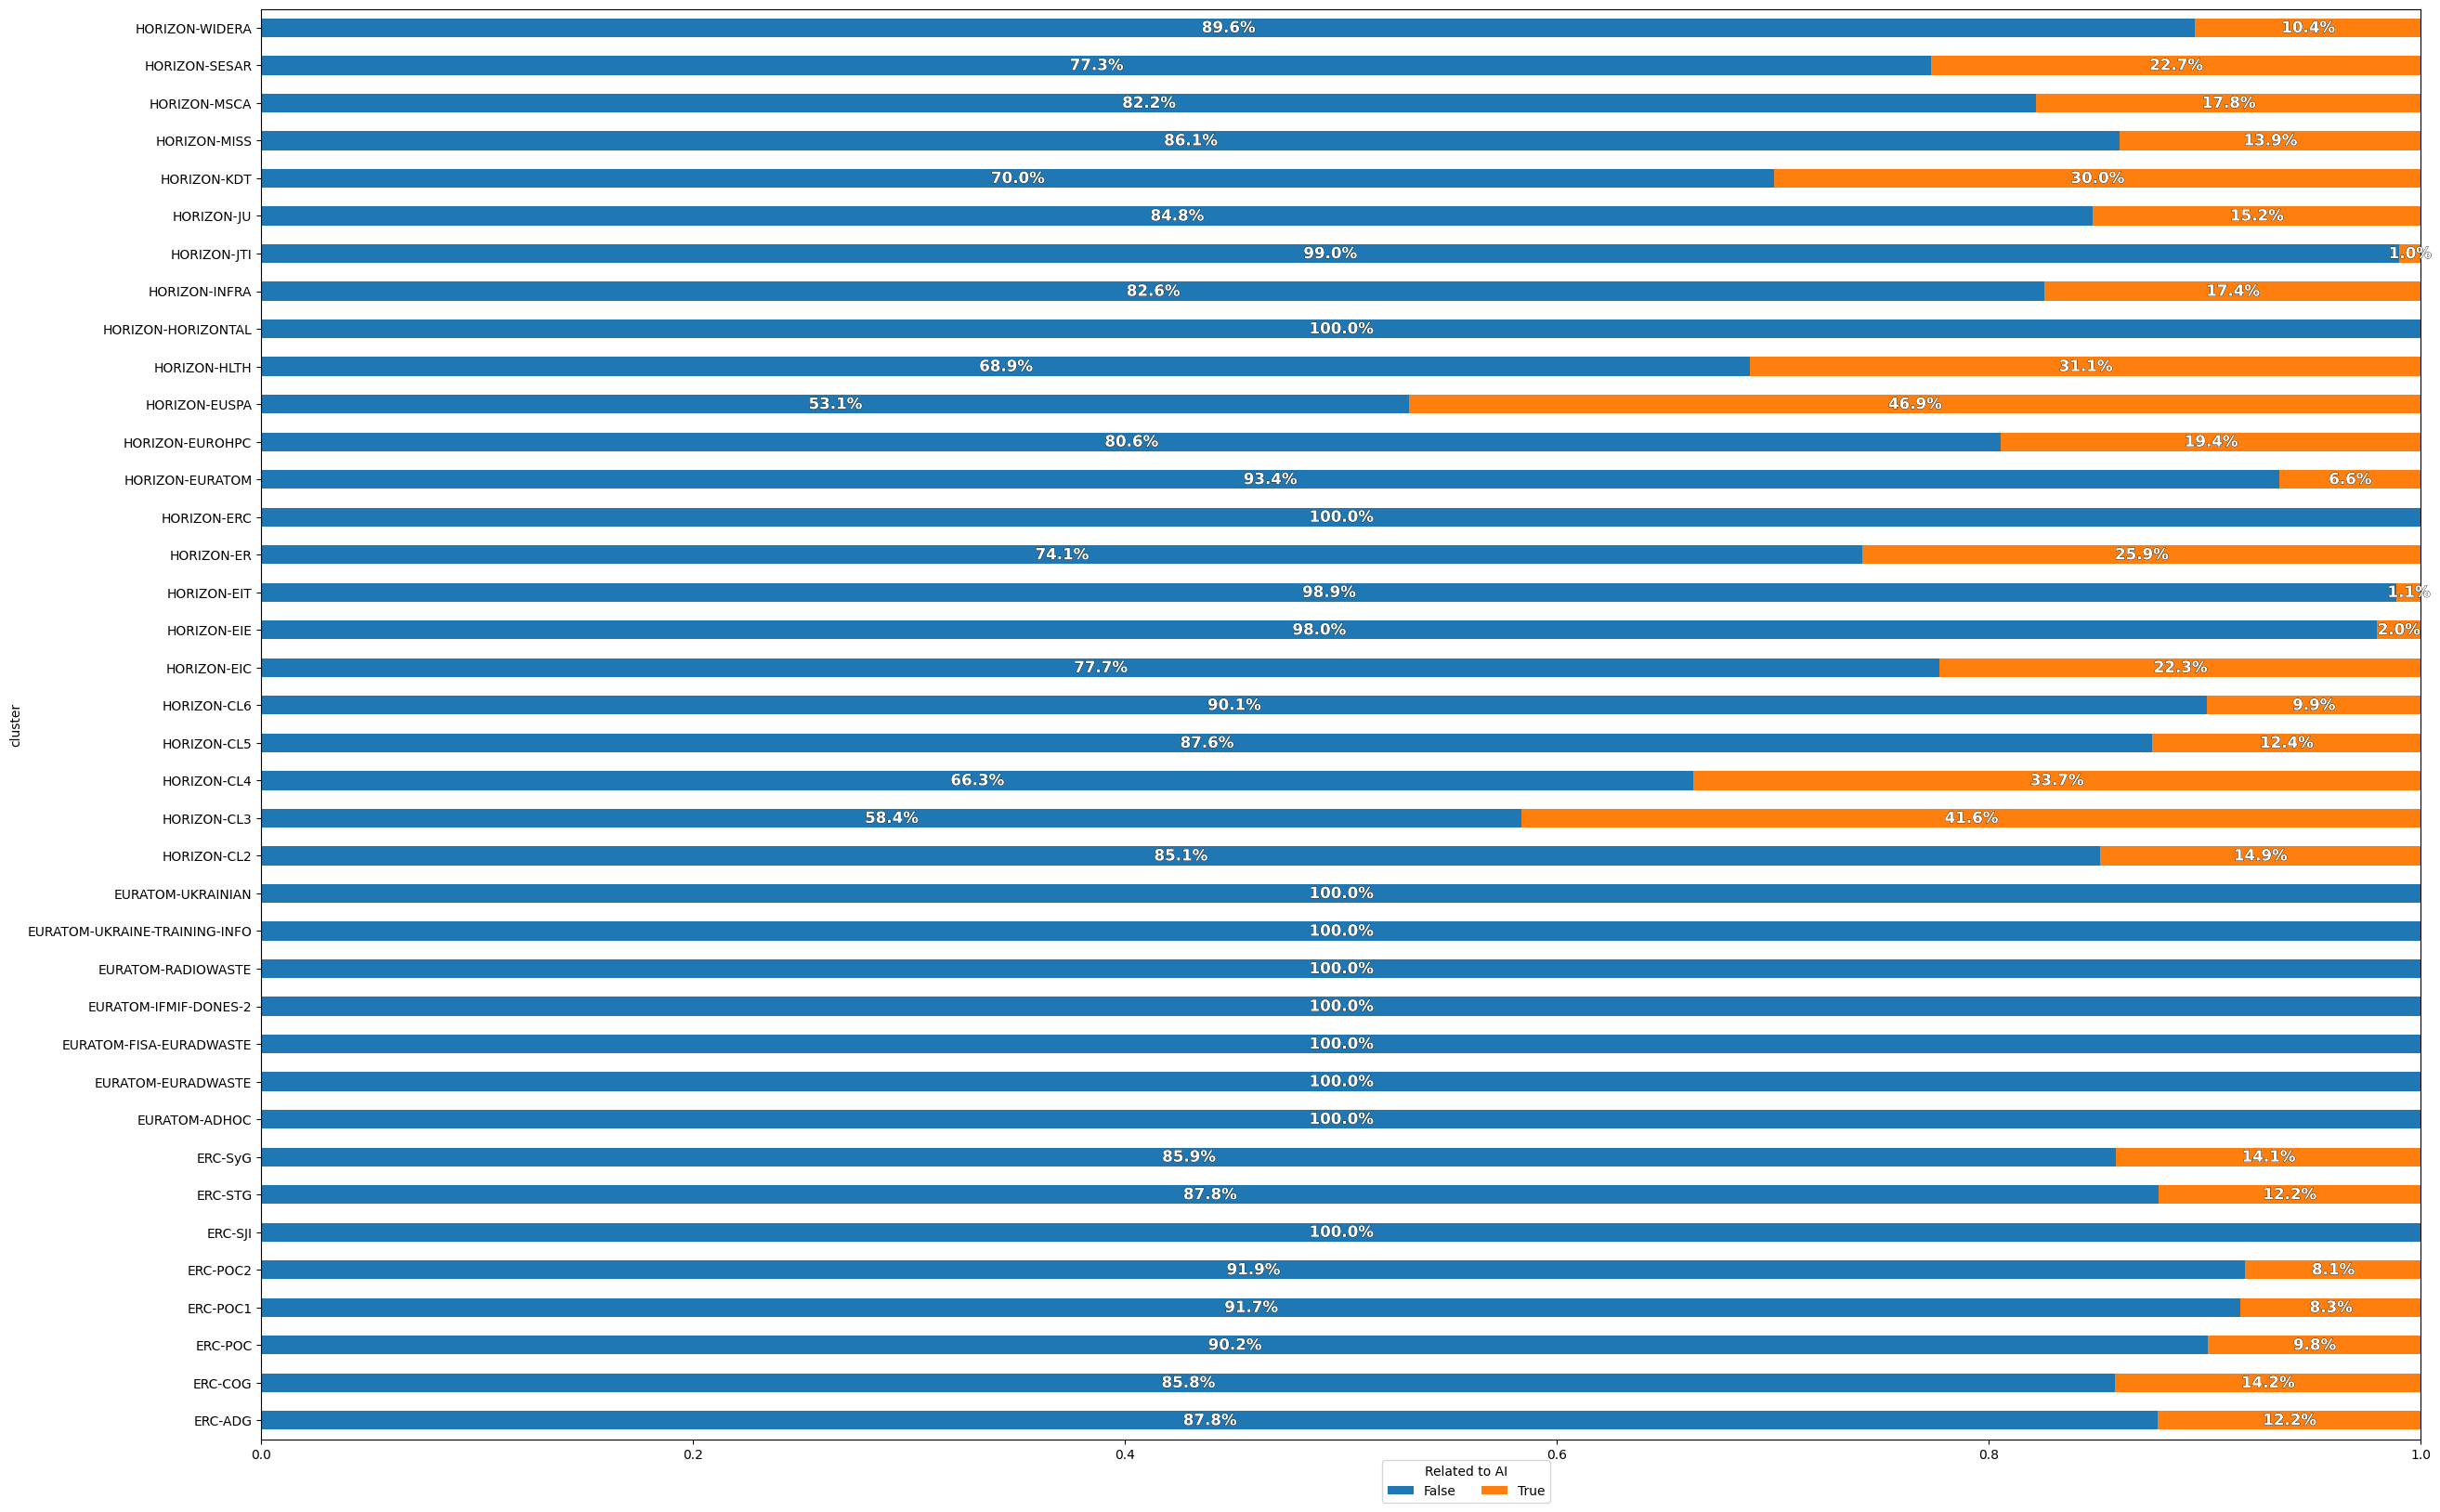

In [79]:
# has_AI_per_cluster = has_AI_per_cluster.groupby(["cluster", "categories"])["ecMaxContribution"].sum().unstack()
has_AI_per_cluster_perc = has_AI_per_cluster.div(has_AI_per_cluster.sum(axis=1), axis=0)
ax = has_AI_per_cluster_perc.plot(kind="barh", stacked=True, figsize=((30,20)))
ax.legend(title="Related to AI", ncol=5, bbox_to_anchor=(0.6, -0.01))

for c in ax.containers:
    labels = [f'{w*100:0.1f}%' if (w := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='white', fontsize=12, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])

ax.margins(x=0)
# ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


# Disruptive Technologies

In [80]:
disruptive = ["AI", "CYBERSECURITY", "IOT", "BLOCKCHAIN", "QUANTUM"]

def has_disruptive(row):    
    if row.categories is None:
        return False
    for d in disruptive:
        if d in row.categories:
            return True

    if row.subcategories is None:
        return False
    for d in disruptive:
        if d in np.array(row.subcategories)[:, 1]:
            return True
    
    if row.subsubcategories is None:
        return False
    for d in disruptive:
        if d in np.array(row.subsubcategories)[:, 1]:
            return True
    
    return False

df["has_disruptive"] = df.apply(lambda row: has_disruptive(row), axis=1)

In [81]:
print(f"Number of projects that have disruptive: {len(df[df['has_disruptive']])} ({len(df[df['has_disruptive']])/len(df)*100:.2f})%")
print(f"Total EcMaxContribution of projects that have disruptive: {df[df['has_disruptive']]['ecMaxContribution'].sum()} Euros ({df[df['has_disruptive']]['ecMaxContribution'].sum()/df['ecMaxContribution'].sum()*100:.2f})%")


Number of projects that have disruptive: 2795 (20.44)%
Total EcMaxContribution of projects that have disruptive: 8803525672.05 Euros (23.91)%


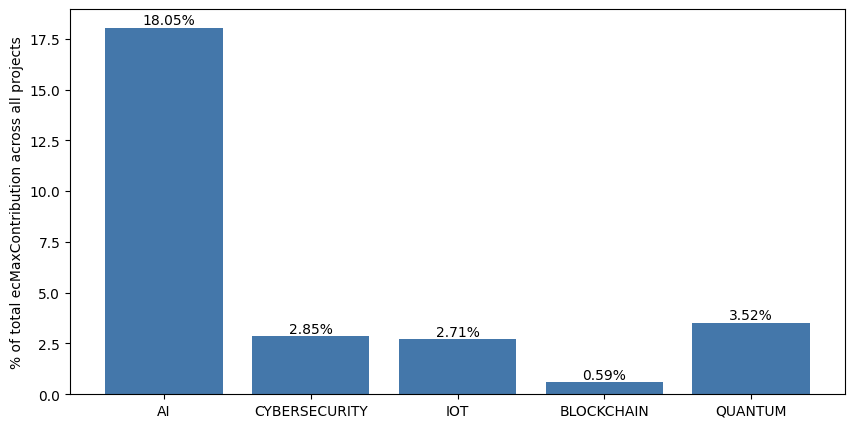

In [82]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

for d in disruptive:
    ax.bar(d, all_project_ecmax[d]/df['ecMaxContribution'].sum()*100, color=blue)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + 0.25, p.get_height() + 0.15))

ax.set_ylabel("% of total ecMaxContribution across all projects")
plt.show()

In [83]:
def has_any(row, cat):
    if row.categories is None:
        return False
    if cat in row.categories:
        return True

    if row.subcategories is None:
        return False
    if cat in np.array(row.subcategories)[:, 1]:
        return True
    
    if row.subsubcategories is None:
        return False
    if cat in np.array(row.subsubcategories)[:, 1]:
            return True
    
    return False


In [84]:
for d in disruptive:
    df[f"has_{d}"] = df.apply(lambda row: has_any(row, d), axis=1)

In [85]:
print(f"Average ecMax per project {'overall'.ljust(19)}{df['ecMaxContribution'].mean():>10.0f}")
for d in disruptive:
    print(f"Average ecMax per project for {d.ljust(15)}{df[df[f'has_{d}']]['ecMaxContribution'].mean():>10.0f}")



Average ecMax per project overall               2692689
Average ecMax per project for AI                3318341
Average ecMax per project for CYBERSECURITY     4060584
Average ecMax per project for IOT               4101232
Average ecMax per project for BLOCKCHAIN        4930843
Average ecMax per project for QUANTUM           2180675


In [86]:
def check_any(cat):
    cat_strip = cat.replace(" ", "")
    df[f"has_{cat_strip}"] = df.apply(lambda row: has_any(row, cat), axis=1)
    
    print(f"\n# of projects for {cat}: {len(df[df[f'has_{cat_strip}']])}")
    cat_ecmax = df[df[f"has_{cat_strip}"]]["ecMaxContribution"].sum()
    print(f"Total ecMaxContribution for {cat}: {cat_ecmax/df['ecMaxContribution'].sum()*100:.2f}%, €{cat_ecmax/(1000*1000):.2f} million = €{cat_ecmax/(1000*1000*1000)} billion.")


In [87]:
check_any("XR")
check_any("DIGITAL TWIN")
check_any("BLOCKCHAIN")
check_any("AI")



# of projects for XR: 152
Total ecMaxContribution for XR: 1.39%, €511.48 million = €0.51148213723 billion.

# of projects for DIGITAL TWIN: 224
Total ecMaxContribution for DIGITAL TWIN: 3.59%, €1320.84 million = €1.32084425523 billion.

# of projects for BLOCKCHAIN: 44
Total ecMaxContribution for BLOCKCHAIN: 0.59%, €216.96 million = €0.21695711295000003 billion.

# of projects for AI: 2003
Total ecMaxContribution for AI: 18.05%, €6646.64 million = €6.64663703113 billion.


In [88]:
check_any("REPAIRING")
check_any("OPEN")
check_any("PRIVACY")
check_any("INTEROPERABILITY")
check_any("USER")
check_any("SECURITY")



# of projects for REPAIRING: 143
Total ecMaxContribution for REPAIRING: 1.07%, €392.48 million = €0.39247721181 billion.

# of projects for OPEN: 304
Total ecMaxContribution for OPEN: 3.72%, €1370.87 million = €1.37087354607 billion.

# of projects for PRIVACY: 71
Total ecMaxContribution for PRIVACY: 0.83%, €304.56 million = €0.30455781864 billion.

# of projects for INTEROPERABILITY: 102
Total ecMaxContribution for INTEROPERABILITY: 1.68%, €618.16 million = €0.61815720766 billion.

# of projects for USER: 146
Total ecMaxContribution for USER: 1.67%, €616.61 million = €0.6166136399500001 billion.

# of projects for SECURITY: 1119
Total ecMaxContribution for SECURITY: 12.81%, €4715.66 million = €4.71565831977 billion.


In [89]:
check_any("ETHICS")
check_any("HUMAN")



# of projects for ETHICS: 351
Total ecMaxContribution for ETHICS: 2.70%, €995.16 million = €0.99516496056 billion.

# of projects for HUMAN: 802
Total ecMaxContribution for HUMAN: 4.81%, €1770.46 million = €1.770455873 billion.


In [90]:
check_any("6g")
check_any("5g")



# of projects for 6g: 16
Total ecMaxContribution for 6g: 0.20%, €72.82 million = €0.07282384269 billion.

# of projects for 5g: 6
Total ecMaxContribution for 5g: 0.06%, €21.08 million = €0.02108367788 billion.


In [91]:
def has_any_group(row, cats):
    if row.categories is None:
        return False
    
    for cat in cats:
        if cat in row.categories:
            return True

        if row.subcategories is None:
            continue
        if cat in np.array(row.subcategories)[:, 1]:
            return True

        if row.subsubcategories is None:
            continue
        if cat in np.array(row.subsubcategories)[:, 1]:
            return True
    
    return False

In [92]:
# Disruptive categories
disruptive_cats = ["AI", "XR", "DIGITAL TWIN", "BLOCKCHAIN", "CYBERSECURITY"]
df[f"has_disruptive"] = df.apply(lambda row: has_any_group(row, disruptive_cats), axis=1)
    
print(f"\n# of projects for Disruptive Categories: {len(df[df[f'has_disruptive']])}")
cat_ecmax = df[df[f"has_disruptive"]]["ecMaxContribution"].sum()
print(f"Total ecMaxContribution for Disruptive Categories: {cat_ecmax/df['ecMaxContribution'].sum()*100:.2f}%, €{cat_ecmax/(1000*1000):.2f} million = €{cat_ecmax/(1000*1000*1000)} billion.")




# of projects for Disruptive Categories: 2386
Total ecMaxContribution for Disruptive Categories: 22.66%, €8344.14 million = €8.34413998855 billion.


In [93]:
open_cats = ["OPEN", "INTEROPERABILITY", "REPAIRING"]
df[f"has_opens"] = df.apply(lambda row: has_any_group(row, open_cats), axis=1)
    
print(f"\n# of projects for Disruptive Categories: {len(df[df[f'has_opens']])}")
cat_ecmax = df[df[f"has_opens"]]["ecMaxContribution"].sum()
print(f"Total ecMaxContribution for Open-related Categories: {cat_ecmax/df['ecMaxContribution'].sum()*100:.2f}%, €{cat_ecmax/(1000*1000):.2f} million = €{cat_ecmax/(1000*1000*1000)} billion.")





# of projects for Disruptive Categories: 531
Total ecMaxContribution for Open-related Categories: 6.19%, €2278.41 million = €2.2784102685699996 billion.
